# BCR analysis (on B cell object)

CVID, revisions

analysis with scirpy

13.01.2021

In [1]:
import scirpy as ir # requires 'pip install scirpy'
import scanpy as sc
from glob import glob
import pandas as pd
import numpy as np
import tarfile
import anndata
import warnings
from numba import NumbaPerformanceWarning
import matplotlib.pyplot as plt

# ignore numba performance warnings
warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)

In [2]:
sc.settings.set_figure_params(dpi=100)


In [3]:
%%bash

pip freeze

aiohttp==3.6.2
airr==1.3.1
alembic==1.3.0
anndata==0.7.5
annoy==1.16.2
async-generator==1.10
async-timeout==3.0.1
attrs==19.3.0
backcall==0.1.0
bbknn==1.3.6
bleach==3.1.0
blinker==1.4
certifi==2019.9.11
certipy==0.1.3
cffi==1.13.2
chardet==3.0.4
Click==7.0
conda==4.7.12
conda-package-handling==1.6.0
cryptography==2.8
cycler==0.10.0
Cython==0.29.14
decorator==4.4.1
defusedxml==0.6.0
entrypoints==0.3
fbpca==1.0
geosketch==1.0
get-version==2.1
h5py==2.10.0
idna==2.8
importlib-metadata==0.23
intervaltree==2.1.0
ipykernel==5.1.3
ipython==7.9.0
ipython-genutils==0.2.0
jedi==0.15.1
Jinja2==2.10.3
joblib==0.14.0
json5==0.8.5
jsonschema==3.1.1
jupyter-client==5.3.3
jupyter-core==4.5.0
jupyter-rsession-proxy==1.0b6
jupyter-server-proxy==1.2.0
jupyterhub==1.0.0
jupyterlab==1.2.1
jupyterlab-server==1.0.6
kiwisolver==1.1.0
legacy-api-wrap==1.2
leidenalg==0.7.0
llvmlite==0.30.0
loompy==3.0.6
louvain==0.6.1
Mako==1.1.0
MarkupSafe==1.1.1
matplotlib==3.3.3
mistune==0.8.4
more-itertools==7.2.0
multidict

## Reading in the main transcriptomics object

In [4]:
save_path = '/lustre/scratch117/cellgen/team292/aa22/adata_objects/202009_CVID_revision/'

In [6]:
# object with all cells, norm., log tr and scaled gex counts in .X, norm. and log tr. gex counts in .raw.X, HVG-subsetted
adata = sc.read(save_path+'adata_hvg_bbknn_by_sample_nodoublets_20_PCs_GEX_and_SoupX_denoised_protein_all_samples_cleaned_up_final_20210111.h5ad')

In [10]:
# getting final annotation table:
annot_table = pd.read_csv(save_path + 'annotation_of_adata_hvg_BBKNN_GEX_and_SoupX_denoised_protein_all_samples_20210108.csv',
                         index_col=0)
annot_table

cell_type_final
AAACCTGAGAATGTGT-1        Monocytes_CD16+
AAACCTGAGACTAAGT-1                   cDC2
AAACCTGAGCCGCCTA-1               TCM_CD8+
AAACCTGAGCGCCTCA-1               TEM_CD8+
AAACCTGAGGATGTAT-1               TEM_CD8+
...                                   ...
TTTGTCATCGCCTGAG-1        doublets_by_TCR
TTTGTCATCGTCACGG-1-1  Monocytes_Classical
TTTGTCATCGTCTGCT-1-1           iNKT_cells
TTTGTCATCTACTTAC-1               doublets
TTTGTCATCTCTTATG-1     T_cells_CD4+_naive

[163320 rows x 1 columns]

In [11]:
adata.obs['cell_type_final'] = annot_table.loc[adata.obs_names,'cell_type_final']

In [12]:
np.unique(adata.obs['cell_type_final'])

array(['B_cells_memory', 'B_cells_naive', 'MAIT_cells', 'Macrophages',
       'Monocytes_CD16+', 'Monocytes_Classical', 'NK_CD16_bright',
       'NK_CD56_bright', 'Plasma_cells', 'Precursor_Cells', 'TCM_CD8+',
       'TEM_CD8+', 'TMRA_CD8+', 'T_cells_CD4+_activated',
       'T_cells_CD4+_memory', 'T_cells_CD4+_naive',
       'T_cells_CD8+_activated', 'T_cells_CD8+_naive', 'cDC1', 'cDC2',
       'gdT_cells', 'iNKT_cells', 'pDCs'], dtype=object)

### Loading data from cellranger output

#### general scRNA-seq

35008_CV005_RV9039258      unstim    

35008_CV005_RV9039259      unstim   

35008_CV005_RV9039260      CD40L

35008_CV005_RV9039261      CD40L    

35008_CV005_RV9039262      CD3    

35008_CV005_RV9039263      CD3    

35008_CV005_RV9039264      BCR

35008_CV005_RV9039265      BCR

35171_CV005_RV9039361      unstim

35171_CV005_RV9039362      CD40L

35171_CV005_RV9039363      CD3

35171_CV005_RV9039364      BCR

#### BCR enriched

35008_CV005_RV9039274      unstim

35008_CV005_RV9039275      unstim

35008_CV005_RV9039276      CD40L

35008_CV005_RV9039277      CD40L

35008_CV005_RV9039278      CD3

35008_CV005_RV9039279      CD3

35008_CV005_RV9039280      BCR

35008_CV005_RV9039281      BCR

35171_CV005_RV9039377      unstim

35171_CV005_RV9039378      CD40L

35171_CV005_RV9039379      CD3
 
35171_CV005_RV9039380      BCR


In [13]:
samples_enriched = ['35008_CV005_RV9039274',
                    '35008_CV005_RV9039275',
                    '35008_CV005_RV9039276',
                    '35008_CV005_RV9039277',
                    '35008_CV005_RV9039278',
                    '35008_CV005_RV9039279',
                    '35008_CV005_RV9039280',
                    '35008_CV005_RV9039281',
                   '35171_CV005_RV9039377',
                   '35171_CV005_RV9039378',
                   '35171_CV005_RV9039379',
                   '35171_CV005_RV9039380']

In [14]:
np.unique(adata.obs['sample'])

array(['35008_CV005_RV9039258_and_35008_CV005_RV9039282',
       '35008_CV005_RV9039259_and_35008_CV005_RV9039283',
       '35008_CV005_RV9039260_and_35008_CV005_RV9039284',
       '35008_CV005_RV9039261_and_35008_CV005_RV9039285',
       '35008_CV005_RV9039262_and_35008_CV005_RV9039286',
       '35008_CV005_RV9039263_and_35008_CV005_RV9039287',
       '35008_CV005_RV9039264_and_35008_CV005_RV9039288',
       '35008_CV005_RV9039265_and_35008_CV005_RV9039289',
       '35171_CV005_RV9039361', '35171_CV005_RV9039362',
       '35171_CV005_RV9039363', '35171_CV005_RV9039364'], dtype=object)

In [15]:
dict_samples_enrich_to_general =  {}

# BCR

dict_samples_enrich_to_general['35008_CV005_RV9039274'] = '35008_CV005_RV9039258_and_35008_CV005_RV9039282'
dict_samples_enrich_to_general['35008_CV005_RV9039275'] = '35008_CV005_RV9039259_and_35008_CV005_RV9039283'
dict_samples_enrich_to_general['35008_CV005_RV9039276'] = '35008_CV005_RV9039260_and_35008_CV005_RV9039284'
dict_samples_enrich_to_general['35008_CV005_RV9039277'] = '35008_CV005_RV9039261_and_35008_CV005_RV9039285'
dict_samples_enrich_to_general['35008_CV005_RV9039278'] = '35008_CV005_RV9039262_and_35008_CV005_RV9039286'
dict_samples_enrich_to_general['35008_CV005_RV9039279'] = '35008_CV005_RV9039263_and_35008_CV005_RV9039287'
dict_samples_enrich_to_general['35008_CV005_RV9039280'] = '35008_CV005_RV9039264_and_35008_CV005_RV9039288'
dict_samples_enrich_to_general['35008_CV005_RV9039281'] = '35008_CV005_RV9039265_and_35008_CV005_RV9039289'
dict_samples_enrich_to_general['35171_CV005_RV9039377'] = '35171_CV005_RV9039361'
dict_samples_enrich_to_general['35171_CV005_RV9039378'] = '35171_CV005_RV9039362'
dict_samples_enrich_to_general['35171_CV005_RV9039379'] = '35171_CV005_RV9039363'
dict_samples_enrich_to_general['35171_CV005_RV9039380'] = '35171_CV005_RV9039364'

In [16]:
list(dict_samples_enrich_to_general.keys())[:1]

['35008_CV005_RV9039274']

In [17]:
%%time

# Create a list of AnnData objects (one for each sample)
adatas_gex_with_bcr = {}
for sample_bcr, sample_gex in dict_samples_enrich_to_general.items():
    
    print('gex sample', sample_gex)
    print('BCR sample', sample_bcr)
    
    gex_path = '/lustre/scratch117/cellgen/team292/aa22/data/202009_CVID_revision/cellranger302_count_' + sample_gex + '_GRCh38-1_2_0/filtered_feature_bc_matrix.h5'
    bcr_path = '/lustre/scratch117/cellgen/team292/aa22/data/202009_CVID_revision/cellranger302_vdj_BCR_' + sample_bcr + '_GRCh38-alts-ensembl-2_0_0/filtered_contig_annotations.csv'
    
    print('reading files')
    
    adata_gex = sc.read_10x_h5(gex_path)
    # remembering the unique barcode_sample index
    adata_gex.obs['barcode_sample'] = [barcode + '_' + sample_gex for barcode in adata_gex.obs_names]
    adata_bcr = ir.io.read_10x_vdj(bcr_path)
    
    print('merging gex and BCR adatas')
    
    ir.pp.merge_with_ir(adata_gex, adata_bcr)
    
    print('done merging')
    
    # concatenation only works with unique gene names
    adata_gex.var_names_make_unique()
    adatas_gex_with_bcr[sample_gex] = adata_gex


gex sample 35008_CV005_RV9039258_and_35008_CV005_RV9039282
BCR sample 35008_CV005_RV9039274
reading files


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'IR_VJ_1_cdr3' as categorical
... storing 'IR_VJ_2_cdr3' as categorical
... storing 'IR_VDJ_1_cdr3' as categorical
... storing 'IR_VDJ_2_cdr3' as categorical
... storing 'IR_VJ_1_cdr3_nt' as categorical
... storing 'IR_VJ_2_cdr3_nt' as categorical
... storing 'IR_VDJ_1_cdr3_nt' as categorical
... storing 'IR_VDJ_2_cdr3_nt' as categorical
... storing 'IR_VJ_1_junction_ins' as categorical
... storing 'IR_VJ_2_junction_ins' as categorical
... storing 'IR_VDJ_1_junction_ins' as categorical
... storing 'IR_VDJ_2_junction_ins' as categorical


merging gex and BCR adatas


... storing 'multi_chain' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


done merging
gex sample 35008_CV005_RV9039259_and_35008_CV005_RV9039283
BCR sample 35008_CV005_RV9039275
reading files


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'IR_VJ_1_cdr3' as categorical
... storing 'IR_VJ_2_cdr3' as categorical
... storing 'IR_VDJ_1_cdr3' as categorical
... storing 'IR_VDJ_2_cdr3' as categorical
... storing 'IR_VJ_1_cdr3_nt' as categorical
... storing 'IR_VJ_2_cdr3_nt' as categorical
... storing 'IR_VDJ_1_cdr3_nt' as categorical
... storing 'IR_VDJ_2_cdr3_nt' as categorical
... storing 'IR_VJ_1_junction_ins' as categorical
... storing 'IR_VJ_2_junction_ins' as categorical
... storing 'IR_VDJ_1_junction_ins' as categorical
... storing 'IR_VDJ_2_junction_ins' as categorical


merging gex and BCR adatas


... storing 'multi_chain' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


done merging
gex sample 35008_CV005_RV9039260_and_35008_CV005_RV9039284
BCR sample 35008_CV005_RV9039276
reading files


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'IR_VJ_1_cdr3' as categorical
... storing 'IR_VJ_2_cdr3' as categorical
... storing 'IR_VDJ_1_cdr3' as categorical
... storing 'IR_VDJ_2_cdr3' as categorical
... storing 'IR_VJ_1_cdr3_nt' as categorical
... storing 'IR_VJ_2_cdr3_nt' as categorical
... storing 'IR_VDJ_1_cdr3_nt' as categorical
... storing 'IR_VDJ_2_cdr3_nt' as categorical
... storing 'IR_VJ_1_junction_ins' as categorical
... storing 'IR_VJ_2_junction_ins' as categorical
... storing 'IR_VDJ_1_junction_ins' as categorical
... storing 'IR_VDJ_2_junction_ins' as categorical


merging gex and BCR adatas


... storing 'multi_chain' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


done merging
gex sample 35008_CV005_RV9039261_and_35008_CV005_RV9039285
BCR sample 35008_CV005_RV9039277
reading files


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'IR_VJ_1_cdr3' as categorical
... storing 'IR_VJ_2_cdr3' as categorical
... storing 'IR_VDJ_1_cdr3' as categorical
... storing 'IR_VDJ_2_cdr3' as categorical
... storing 'IR_VJ_1_cdr3_nt' as categorical
... storing 'IR_VJ_2_cdr3_nt' as categorical
... storing 'IR_VDJ_1_cdr3_nt' as categorical
... storing 'IR_VDJ_2_cdr3_nt' as categorical
... storing 'IR_VJ_1_junction_ins' as categorical
... storing 'IR_VJ_2_junction_ins' as categorical
... storing 'IR_VDJ_1_junction_ins' as categorical
... storing 'IR_VDJ_2_junction_ins' as categorical


merging gex and BCR adatas


... storing 'multi_chain' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


done merging
gex sample 35008_CV005_RV9039262_and_35008_CV005_RV9039286
BCR sample 35008_CV005_RV9039278
reading files


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'IR_VJ_1_cdr3' as categorical
... storing 'IR_VJ_2_cdr3' as categorical
... storing 'IR_VDJ_1_cdr3' as categorical
... storing 'IR_VDJ_2_cdr3' as categorical
... storing 'IR_VJ_1_cdr3_nt' as categorical
... storing 'IR_VJ_2_cdr3_nt' as categorical
... storing 'IR_VDJ_1_cdr3_nt' as categorical
... storing 'IR_VDJ_2_cdr3_nt' as categorical
... storing 'IR_VJ_1_junction_ins' as categorical
... storing 'IR_VJ_2_junction_ins' as categorical
... storing 'IR_VDJ_1_junction_ins' as categorical
... storing 'IR_VDJ_2_junction_ins' as categorical


merging gex and BCR adatas


... storing 'multi_chain' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


done merging
gex sample 35008_CV005_RV9039263_and_35008_CV005_RV9039287
BCR sample 35008_CV005_RV9039279
reading files


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'IR_VJ_1_cdr3' as categorical
... storing 'IR_VJ_2_cdr3' as categorical
... storing 'IR_VDJ_1_cdr3' as categorical
... storing 'IR_VDJ_2_cdr3' as categorical
... storing 'IR_VJ_1_cdr3_nt' as categorical
... storing 'IR_VJ_2_cdr3_nt' as categorical
... storing 'IR_VDJ_1_cdr3_nt' as categorical
... storing 'IR_VDJ_2_cdr3_nt' as categorical
... storing 'IR_VJ_1_junction_ins' as categorical
... storing 'IR_VJ_2_junction_ins' as categorical
... storing 'IR_VDJ_1_junction_ins' as categorical
... storing 'IR_VDJ_2_junction_ins' as categorical


merging gex and BCR adatas


... storing 'multi_chain' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


done merging
gex sample 35008_CV005_RV9039264_and_35008_CV005_RV9039288
BCR sample 35008_CV005_RV9039280
reading files


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'IR_VJ_1_cdr3' as categorical
... storing 'IR_VJ_2_cdr3' as categorical
... storing 'IR_VDJ_1_cdr3' as categorical
... storing 'IR_VDJ_2_cdr3' as categorical
... storing 'IR_VJ_1_cdr3_nt' as categorical
... storing 'IR_VJ_2_cdr3_nt' as categorical
... storing 'IR_VDJ_1_cdr3_nt' as categorical
... storing 'IR_VDJ_2_cdr3_nt' as categorical
... storing 'IR_VJ_1_junction_ins' as categorical
... storing 'IR_VJ_2_junction_ins' as categorical
... storing 'IR_VDJ_1_junction_ins' as categorical
... storing 'IR_VDJ_2_junction_ins' as categorical


merging gex and BCR adatas


... storing 'multi_chain' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


done merging
gex sample 35008_CV005_RV9039265_and_35008_CV005_RV9039289
BCR sample 35008_CV005_RV9039281
reading files


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'IR_VJ_1_cdr3' as categorical
... storing 'IR_VJ_2_cdr3' as categorical
... storing 'IR_VDJ_1_cdr3' as categorical
... storing 'IR_VDJ_2_cdr3' as categorical
... storing 'IR_VJ_1_cdr3_nt' as categorical
... storing 'IR_VJ_2_cdr3_nt' as categorical
... storing 'IR_VDJ_1_cdr3_nt' as categorical
... storing 'IR_VDJ_2_cdr3_nt' as categorical
... storing 'IR_VJ_1_junction_ins' as categorical
... storing 'IR_VJ_2_junction_ins' as categorical
... storing 'IR_VDJ_1_junction_ins' as categorical
... storing 'IR_VDJ_2_junction_ins' as categorical


merging gex and BCR adatas


... storing 'multi_chain' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


done merging
gex sample 35171_CV005_RV9039361
BCR sample 35171_CV005_RV9039377
reading files


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'IR_VJ_1_cdr3' as categorical
... storing 'IR_VJ_2_cdr3' as categorical
... storing 'IR_VDJ_1_cdr3' as categorical
... storing 'IR_VDJ_2_cdr3' as categorical
... storing 'IR_VJ_1_cdr3_nt' as categorical
... storing 'IR_VJ_2_cdr3_nt' as categorical
... storing 'IR_VDJ_1_cdr3_nt' as categorical
... storing 'IR_VDJ_2_cdr3_nt' as categorical
... storing 'IR_VJ_1_junction_ins' as categorical
... storing 'IR_VJ_2_junction_ins' as categorical
... storing 'IR_VDJ_1_junction_ins' as categorical
... storing 'IR_VDJ_2_junction_ins' as categorical


merging gex and BCR adatas


... storing 'multi_chain' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


done merging
gex sample 35171_CV005_RV9039362
BCR sample 35171_CV005_RV9039378
reading files


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'IR_VJ_1_cdr3' as categorical
... storing 'IR_VJ_2_cdr3' as categorical
... storing 'IR_VDJ_1_cdr3' as categorical
... storing 'IR_VDJ_2_cdr3' as categorical
... storing 'IR_VJ_1_cdr3_nt' as categorical
... storing 'IR_VJ_2_cdr3_nt' as categorical
... storing 'IR_VDJ_1_cdr3_nt' as categorical
... storing 'IR_VDJ_2_cdr3_nt' as categorical
... storing 'IR_VJ_1_junction_ins' as categorical
... storing 'IR_VJ_2_junction_ins' as categorical
... storing 'IR_VDJ_1_junction_ins' as categorical
... storing 'IR_VDJ_2_junction_ins' as categorical


merging gex and BCR adatas


... storing 'multi_chain' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


done merging
gex sample 35171_CV005_RV9039363
BCR sample 35171_CV005_RV9039379
reading files


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'IR_VJ_1_cdr3' as categorical
... storing 'IR_VJ_2_cdr3' as categorical
... storing 'IR_VDJ_1_cdr3' as categorical
... storing 'IR_VDJ_2_cdr3' as categorical
... storing 'IR_VJ_1_cdr3_nt' as categorical
... storing 'IR_VJ_2_cdr3_nt' as categorical
... storing 'IR_VDJ_1_cdr3_nt' as categorical
... storing 'IR_VDJ_2_cdr3_nt' as categorical
... storing 'IR_VJ_1_junction_ins' as categorical
... storing 'IR_VJ_2_junction_ins' as categorical
... storing 'IR_VDJ_1_junction_ins' as categorical
... storing 'IR_VDJ_2_junction_ins' as categorical


merging gex and BCR adatas


... storing 'multi_chain' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


done merging
gex sample 35171_CV005_RV9039364
BCR sample 35171_CV005_RV9039380
reading files


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'IR_VJ_1_cdr3' as categorical
... storing 'IR_VJ_2_cdr3' as categorical
... storing 'IR_VDJ_1_cdr3' as categorical
... storing 'IR_VDJ_2_cdr3' as categorical
... storing 'IR_VJ_1_cdr3_nt' as categorical
... storing 'IR_VJ_2_cdr3_nt' as categorical
... storing 'IR_VDJ_1_cdr3_nt' as categorical
... storing 'IR_VDJ_2_cdr3_nt' as categorical
... storing 'IR_VJ_1_junction_ins' as categorical
... storing 'IR_VJ_2_junction_ins' as categorical
... storing 'IR_VDJ_1_junction_ins' as categorical
... storing 'IR_VDJ_2_junction_ins' as categorical


merging gex and BCR adatas


... storing 'multi_chain' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


done merging
CPU times: user 2min 6s, sys: 3.4 s, total: 2min 9s
Wall time: 2min 21s


In [18]:
# Merge anndata objects
adata_with_bcr = list(adatas_gex_with_bcr.values())[0].concatenate(list(adatas_gex_with_bcr.values())[1:])

In [19]:
adata_with_bcr

AnnData object with n_obs × n_vars = 255313 × 33694
    obs: 'barcode_sample', 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_cdr3', 'IR_VJ_2_cdr3', 'IR_VDJ_1_cdr3', 'IR_VDJ_2_cdr3', 'IR_VJ_1_cdr3_nt', 'IR_VJ_2_cdr3_nt', 'IR_VDJ_1_cdr3_nt', 'IR_VDJ_2_cdr3_nt', 'IR_VJ_1_expr', 'IR_VJ_2_expr', 'IR_VDJ_1_expr', 'IR_VDJ_2_expr', 'IR_VJ_1_expr_raw', 'IR_VJ_2_expr_raw', 'IR_VDJ_1_expr_raw', 'IR_VDJ_2_expr_raw', 'IR_VJ_1_v_gene', 'IR_VJ_2_v_gene', 'IR_VDJ_1_v_gene', 'IR_VDJ_2_v_gene', 'IR_VJ_1_d_gene', 'IR_VJ_2_d_gene', 'IR_VDJ_1_d_gene', 'IR_VDJ_2_d_gene', 'IR_VJ_1_j_gene', 'IR_VJ_2_j_gene', 'IR_VDJ_1_j_gene', 'IR_VDJ_2_j_gene', 'IR_VJ_1_c_gene', 'IR_VJ_2_c_gene', 'IR_VDJ_1_c_gene', 'IR_VDJ_2_c_gene', 'IR_VJ_1_junction_ins', 'IR_VJ_2_junction_ins', 'IR_VDJ_1_junction_ins', 'IR_VDJ_2_junction_ins', 'has_ir', 'multi_chain', 'batch'
    var: 'gene_ids', 'feature_types', 'genome'

In [20]:
adata_with_bcr.obs

barcode_sample  \
AAACCTGAGAATGTGT-1-0   AAACCTGAGAATGTGT-1_35008_CV005_RV9039258_and_3...   
AAACCTGAGACTAAGT-1-0   AAACCTGAGACTAAGT-1_35008_CV005_RV9039258_and_3...   
AAACCTGAGATCCCGC-1-0   AAACCTGAGATCCCGC-1_35008_CV005_RV9039258_and_3...   
AAACCTGAGCCGCCTA-1-0   AAACCTGAGCCGCCTA-1_35008_CV005_RV9039258_and_3...   
AAACCTGAGCGCCTCA-1-0   AAACCTGAGCGCCTCA-1_35008_CV005_RV9039258_and_3...   
...                                                                  ...   
TTTGTCATCGTCACGG-1-11           TTTGTCATCGTCACGG-1_35171_CV005_RV9039364   
TTTGTCATCGTCTGCT-1-11           TTTGTCATCGTCTGCT-1_35171_CV005_RV9039364   
TTTGTCATCTACTTAC-1-11           TTTGTCATCTACTTAC-1_35171_CV005_RV9039364   
TTTGTCATCTCTGTCG-1-11           TTTGTCATCTCTGTCG-1_35171_CV005_RV9039364   
TTTGTCATCTCTTATG-1-11           TTTGTCATCTCTTATG-1_35171_CV005_RV9039364   

                      IR_VJ_1_locus IR_VJ_2_locus IR_VDJ_1_locus  \
AAACCTGAGAATGTGT-1-0            NaN           NaN            NaN   
AAACCTGAGACTAAGT-1-0            NaN           NaN            NaN   
AAACCTGAGATCCCGC-1-0            NaN           NaN            NaN   
AAACCTGAGCCGCCTA-1-0            NaN           NaN            NaN   
AAACCTGAGCGCCTCA-1-0            NaN           NaN            NaN   
...                             ...           ...            ...   
TTTGTCATCGTCACGG-1-11           NaN           NaN            NaN   
TTTGTCATCGTCTGCT-1-11           NaN           NaN            NaN   
TTTGTCATCTACTTAC-1-11           NaN           NaN            NaN   
TTTGTCATCTCTGTCG-1-11           NaN           NaN            NaN   
TTTGTCATCTCTTATG-1-11           NaN           NaN            NaN   

                      IR_VDJ_2_locus IR_VJ_1_cdr3 IR_VJ_2_cdr3 IR_VDJ_1_cdr3  \
AAACCTGAGAATGTGT-1-0             NaN          NaN          NaN           NaN   
AAACCTGAGACTAAGT-1-0             NaN          NaN          NaN           NaN   
AAACCTGAGATCCCGC-1-0             NaN          NaN          NaN           NaN   
AAACCTGAGCCGCCTA-1-0             NaN          NaN          NaN           NaN   
AAACCTGAGCGCCTCA-1-0             NaN          NaN          NaN           NaN   
...                              ...          ...          ...           ...   
TTTGTCATCGTCACGG-1-11            NaN          NaN          NaN           NaN   
TTTGTCATCGTCTGCT-1-11            NaN          NaN          NaN           NaN   
TTTGTCATCTACTTAC-1-11            NaN          NaN          NaN           NaN   
TTTGTCATCTCTGTCG-1-11            NaN          NaN          NaN           NaN   
TTTGTCATCTCTTATG-1-11            NaN          NaN          NaN           NaN   

                      IR_VDJ_2_cdr3 IR_VJ_1_cdr3_nt  ... IR_VJ_2_c_gene  \
AAACCTGAGAATGTGT-1-0            NaN             NaN  ...            NaN   
AAACCTGAGACTAAGT-1-0            NaN             NaN  ...            NaN   
AAACCTGAGATCCCGC-1-0            NaN             NaN  ...            NaN   
AAACCTGAGCCGCCTA-1-0            NaN             NaN  ...            NaN   
AAACCTGAGCGCCTCA-1-0            NaN             NaN  ...            NaN   
...                             ...             ...  ...            ...   
TTTGTCATCGTCACGG-1-11           NaN             NaN  ...            NaN   
TTTGTCATCGTCTGCT-1-11           NaN             NaN  ...            NaN   
TTTGTCATCTACTTAC-1-11           NaN             NaN  ...            NaN   
TTTGTCATCTCTGTCG-1-11           NaN             NaN  ...            NaN   
TTTGTCATCTCTTATG-1-11           NaN             NaN  ...            NaN   

                      IR_VDJ_1_c_gene IR_VDJ_2_c_gene  IR_VJ_1_junction_ins  \
AAACCTGAGAATGTGT-1-0              NaN             NaN                   NaN   
AAACCTGAGACTAAGT-1-0              NaN             NaN                   NaN   
AAACCTGAGATCCCGC-1-0              NaN             NaN                   NaN   
AAACCTGAGCCGCCTA-1-0              NaN             NaN                   NaN   
AAACCTGAGCGCCTCA-1-0              NaN             NaN                  

In [21]:
BCR_table = adata_with_bcr.obs.set_index('barcode_sample', drop=True)

In [22]:
BCR_table

IR_VJ_1_locus  \
barcode_sample                                                     
AAACCTGAGAATGTGT-1_35008_CV005_RV9039258_and_35...           NaN   
AAACCTGAGACTAAGT-1_35008_CV005_RV9039258_and_35...           NaN   
AAACCTGAGATCCCGC-1_35008_CV005_RV9039258_and_35...           NaN   
AAACCTGAGCCGCCTA-1_35008_CV005_RV9039258_and_35...           NaN   
AAACCTGAGCGCCTCA-1_35008_CV005_RV9039258_and_35...           NaN   
...                                                          ...   
TTTGTCATCGTCACGG-1_35171_CV005_RV9039364                     NaN   
TTTGTCATCGTCTGCT-1_35171_CV005_RV9039364                     NaN   
TTTGTCATCTACTTAC-1_35171_CV005_RV9039364                     NaN   
TTTGTCATCTCTGTCG-1_35171_CV005_RV9039364                     NaN   
TTTGTCATCTCTTATG-1_35171_CV005_RV9039364                     NaN   

                                                   IR_VJ_2_locus  \
barcode_sample                                                     
AAACCTGAGAATGTGT-1_35008_CV005_RV9039258_and_35...           NaN   
AAACCTGAGACTAAGT-1_35008_CV005_RV9039258_and_35...           NaN   
AAACCTGAGATCCCGC-1_35008_CV005_RV9039258_and_35...           NaN   
AAACCTGAGCCGCCTA-1_35008_CV005_RV9039258_and_35...           NaN   
AAACCTGAGCGCCTCA-1_35008_CV005_RV9039258_and_35...           NaN   
...                                                          ...   
TTTGTCATCGTCACGG-1_35171_CV005_RV9039364                     NaN   
TTTGTCATCGTCTGCT-1_35171_CV005_RV9039364                     NaN   
TTTGTCATCTACTTAC-1_35171_CV005_RV9039364                     NaN   
TTTGTCATCTCTGTCG-1_35171_CV005_RV9039364                     NaN   
TTTGTCATCTCTTATG-1_35171_CV005_RV9039364                     NaN   

                                                   IR_VDJ_1_locus  \
barcode_sample                                                      
AAACCTGAGAATGTGT-1_35008_CV005_RV9039258_and_35...            NaN   
AAACCTGAGACTAAGT-1_35008_CV005_RV9039258_and_35...            NaN   
AAACCTGAGATCCCGC-1_35008_CV005_RV9039258_and_35...            NaN   
AAACCTGAGCCGCCTA-1_35008_CV005_RV9039258_and_35...            NaN   
AAACCTGAGCGCCTCA-1_35008_CV005_RV9039258_and_35...            NaN   
...                                                           ...   
TTTGTCATCGTCACGG-1_35171_CV005_RV9039364                      NaN   
TTTGTCATCGTCTGCT-1_35171_CV005_RV9039364                      NaN   
TTTGTCATCTACTTAC-1_35171_CV005_RV9039364                      NaN   
TTTGTCATCTCTGTCG-1_35171_CV005_RV9039364                      NaN   
TTTGTCATCTCTTATG-1_35171_CV005_RV9039364                      NaN   

                                                   IR_VDJ_2_locus  \
barcode_sample                                                      
AAACCTGAGAATGTGT-1_35008_CV005_RV9039258_and_35...            NaN   
AAACCTGAGACTAAGT-1_35008_CV005_RV9039258_and_35...            NaN   
AAACCTGAGATCCCGC-1_35008_CV005_RV9039258_and_35...            NaN   
AAACCTGAGCCGCCTA-1_35008_CV005_RV9039258_and_35...            NaN   
AAACCTGAGCGCCTCA-1_35008_CV005_RV9039258_and_35...            NaN   
...                                                           ...   
TTTGTCATCGTCACGG-1_35171_CV005_RV9039364                      NaN   
TTTGTCATCGTCTGCT-1_35171_CV005_RV9039364                      NaN   
TTTGTCATCTACTTAC-1_35171_CV005_RV9039364                      NaN   
TTTGTCATCTCTGTCG-1_35171_CV005_RV9039364                      NaN   
TTTGTCATCTCTTATG-1_35171_CV005_RV9039364                      NaN   

                                                   IR_VJ_1_cdr3 IR_VJ_2_cdr3  \
barcode_sample                                                                 
AAACCTGAGAATGTGT-1_35008_CV005_RV9039258_and_35...          NaN          NaN   
AAACCTGAGACTAAGT-1_35008_CV005_RV9039258_and_35...          NaN          NaN   
AAACCTGAGATCCCGC-1_35008_CV005_RV9039258_and_35...          NaN          NaN   
AAACCTGAGCCGCCTA-1_35008_CV005_RV9039258_and_35...          NaN          NaN   
AAACC

In [23]:
# adding all the BCR info to the final adata object .obs table

def add_BCR_info(adata_obj, barcode_sample, column):
    
    if barcode_sample in BCR_table.index:
        value = BCR_table.loc[barcode_sample, column]
        return(value)
    else:
        return('none')

In [24]:
%%time

# adding BCR data to adata.obs table

for col in BCR_table.columns:
    print(col)
    adata.obs[col] = adata.obs['cell_id'].apply(lambda x: add_BCR_info(adata, x, column=col))

IR_VJ_1_locus
IR_VJ_2_locus
IR_VDJ_1_locus
IR_VDJ_2_locus
IR_VJ_1_cdr3
IR_VJ_2_cdr3
IR_VDJ_1_cdr3
IR_VDJ_2_cdr3
IR_VJ_1_cdr3_nt
IR_VJ_2_cdr3_nt
IR_VDJ_1_cdr3_nt
IR_VDJ_2_cdr3_nt
IR_VJ_1_expr
IR_VJ_2_expr
IR_VDJ_1_expr
IR_VDJ_2_expr
IR_VJ_1_expr_raw
IR_VJ_2_expr_raw
IR_VDJ_1_expr_raw
IR_VDJ_2_expr_raw
IR_VJ_1_v_gene
IR_VJ_2_v_gene
IR_VDJ_1_v_gene
IR_VDJ_2_v_gene
IR_VJ_1_d_gene
IR_VJ_2_d_gene
IR_VDJ_1_d_gene
IR_VDJ_2_d_gene
IR_VJ_1_j_gene
IR_VJ_2_j_gene
IR_VDJ_1_j_gene
IR_VDJ_2_j_gene
IR_VJ_1_c_gene
IR_VJ_2_c_gene
IR_VDJ_1_c_gene
IR_VDJ_2_c_gene
IR_VJ_1_junction_ins
IR_VJ_2_junction_ins
IR_VDJ_1_junction_ins
IR_VDJ_2_junction_ins
has_ir
multi_chain
batch
CPU times: user 41.6 s, sys: 189 ms, total: 41.8 s
Wall time: 41.8 s


In [25]:
ir.tl.chain_qc(adata)


In [26]:
adata

AnnData object with n_obs × n_vars = 145823 × 2696
    obs: 'n_genes', 'stimulation', 'sample', 'cell_id', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'cell_type_final', 'S_score', 'G2M_score', 'phase', 'louvain', 'n_counts_protein', 'n_counts_protein_lognorm', 'donor', 'Age', 'Sex', 'Age of disease onset', 'Autoimmunity', 'Gastrointestinal disease', 'Lung disease (bronchiectasis)', 'Lymphoadenopathy ', 'Splenomegaly', 'History of hypogammaglobulinemia, IgA deficiency or immunodeficiency in other family members', 'CVID_status', 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_cdr3', 'IR_VJ_2_cdr3', 'IR_VDJ_1_cdr3', 'IR_VDJ_2_cdr3', 'IR_VJ_1_cdr3_nt', 'IR_VJ_2_cdr3_nt', 'IR_VDJ_1_cdr3_nt', 'IR_VDJ_2_cdr3_nt', 'IR_VJ_1_expr', 'IR_VJ_2_expr', 'IR_VDJ_1_expr', 'IR_VDJ_2_expr', 'IR_VJ_1_expr_raw', 'IR_VJ_2_expr_raw', 'IR_VDJ_1_expr_raw', 'IR_VDJ_2_expr_raw', 'IR_VJ_1_v_gene', 

In [27]:
np.unique(adata.obs['donor'])

array(['CONTROL1', 'CONTROL2', 'CONTROL3', 'CONTROL4', 'CONTROL5',
       'CONTROL6', 'CONTROL7', 'CONTROL8', 'CONTROL9', 'CONTROL_twin',
       'CVID1', 'CVID18', 'CVID23', 'CVID25', 'CVID29', 'CVID3', 'CVID33',
       'CVID34', 'CVID36', 'CVID37', 'CVID_twin'], dtype=object)

In [28]:
np.unique(adata.obs['cell_type_final'])

array(['B_cells_memory', 'B_cells_naive', 'MAIT_cells', 'Macrophages',
       'Monocytes_CD16+', 'Monocytes_Classical', 'NK_CD16_bright',
       'NK_CD56_bright', 'Plasma_cells', 'Precursor_Cells', 'TCM_CD8+',
       'TEM_CD8+', 'TMRA_CD8+', 'T_cells_CD4+_activated',
       'T_cells_CD4+_memory', 'T_cells_CD4+_naive',
       'T_cells_CD8+_activated', 'T_cells_CD8+_naive', 'cDC1', 'cDC2',
       'gdT_cells', 'iNKT_cells', 'pDCs'], dtype=object)

In [29]:
# subsetting only to B cell clusters (according to cell_type_final)
adata = adata[adata.obs['cell_type_final'].isin(['B_cells_memory', 'B_cells_naive', 'Plasma_cells'])].copy()

In [31]:
# ading a joint key of celltype + condition
adata.obs['celltype_condition'] = [i + '_' + j for i,j in zip(adata.obs['cell_type_final'], adata.obs['CVID_status'])]

In [32]:
# also separating data from twins only

adata_twins = adata[adata.obs['donor'].isin(['CVID_twin','CONTROL_twin'])].copy()

... storing 'batch' as categorical
... storing 'cell_type_final' as categorical
... storing 'IR_VJ_1_locus' as categorical
... storing 'IR_VJ_2_locus' as categorical
... storing 'IR_VDJ_1_locus' as categorical
... storing 'IR_VDJ_2_locus' as categorical
... storing 'IR_VJ_1_cdr3' as categorical
... storing 'IR_VJ_2_cdr3' as categorical
... storing 'IR_VDJ_1_cdr3' as categorical
... storing 'IR_VDJ_2_cdr3' as categorical
... storing 'IR_VJ_1_cdr3_nt' as categorical
... storing 'IR_VJ_2_cdr3_nt' as categorical
... storing 'IR_VDJ_1_cdr3_nt' as categorical
... storing 'IR_VDJ_2_cdr3_nt' as categorical
... storing 'IR_VJ_1_v_gene' as categorical
... storing 'IR_VJ_2_v_gene' as categorical
... storing 'IR_VDJ_1_v_gene' as categorical
... storing 'IR_VDJ_2_v_gene' as categorical
... storing 'IR_VJ_1_d_gene' as categorical
... storing 'IR_VJ_2_d_gene' as categorical
... storing 'IR_VDJ_1_d_gene' as categorical
... storing 'IR_VDJ_2_d_gene' as categorical
... storing 'IR_VJ_1_j_gene' as catego

<AxesSubplot:title={'center':'Number of cells in receptor_subtype by celltype_condition'}, xlabel='receptor_subtype', ylabel='Number of cells'>

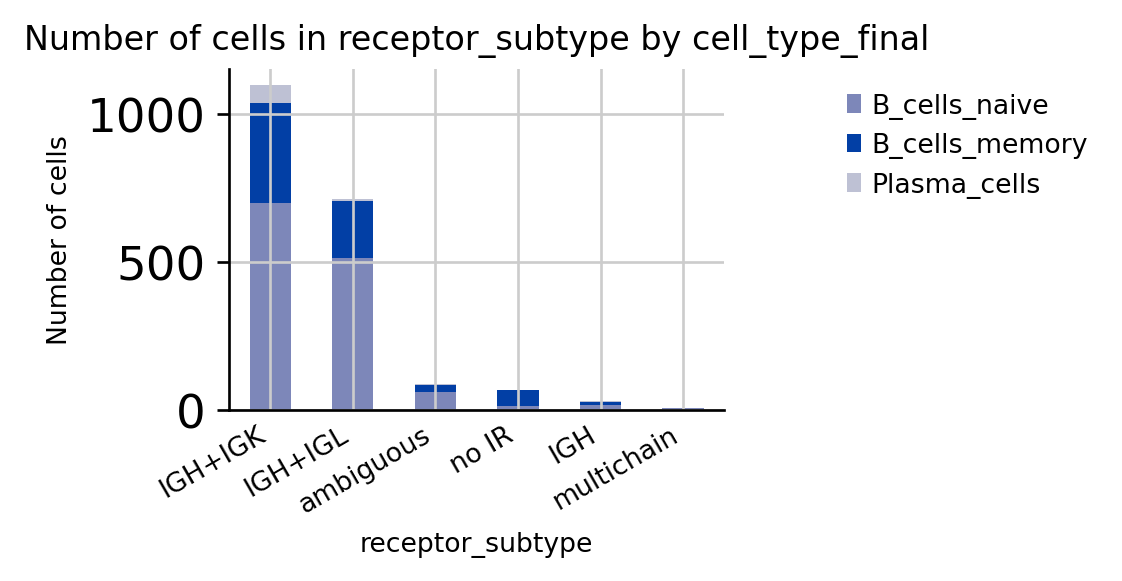

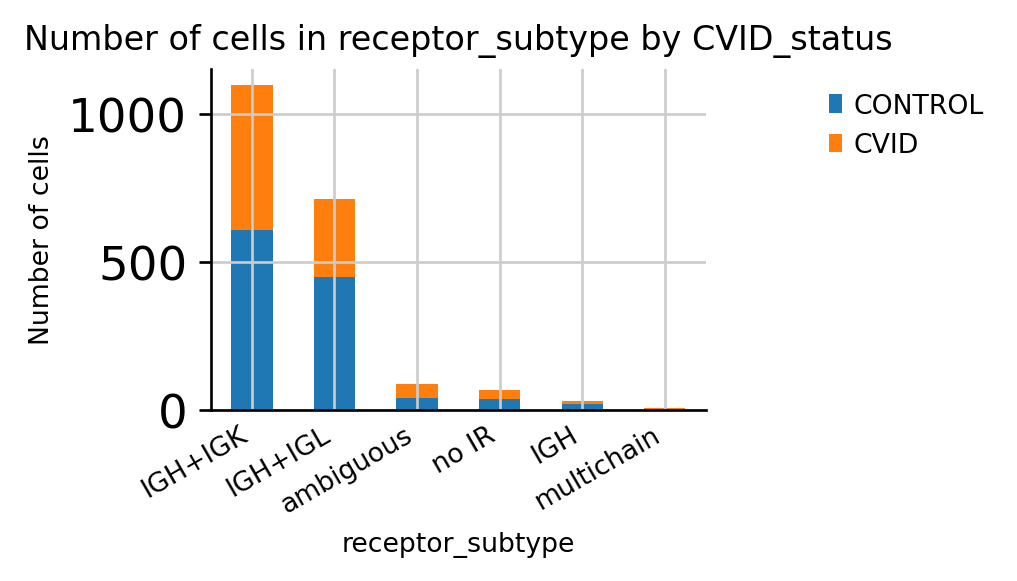

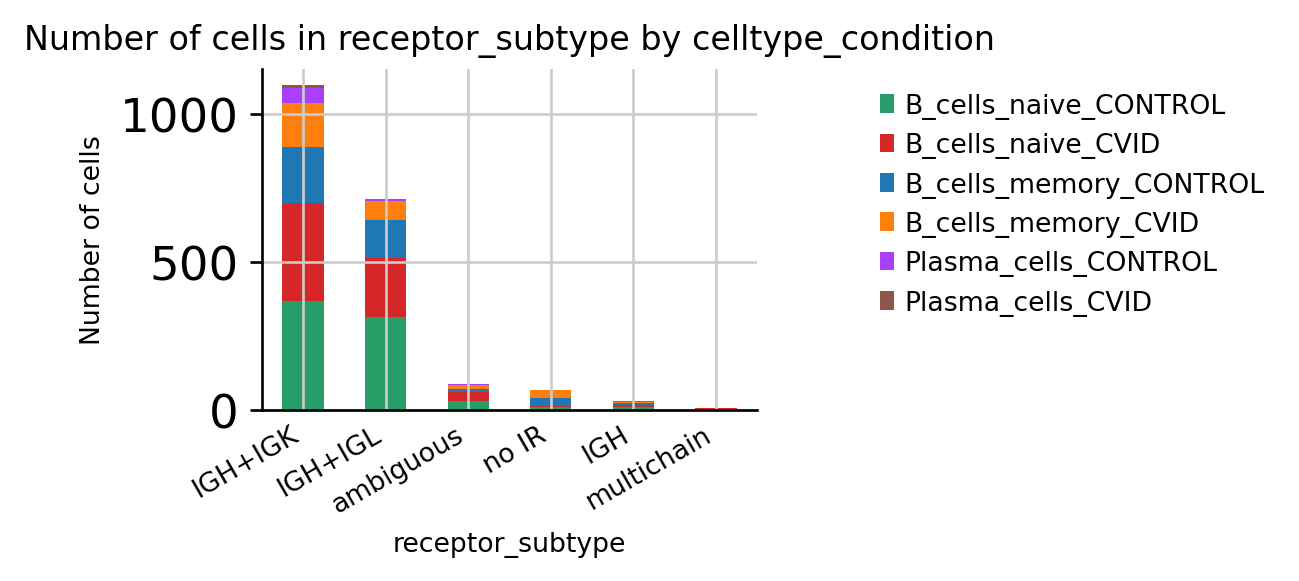

In [33]:
ir.pl.group_abundance(adata_twins, groupby="receptor_subtype", target_col="cell_type_final")
ir.pl.group_abundance(adata_twins, groupby="receptor_subtype", target_col="CVID_status")
ir.pl.group_abundance(adata_twins, groupby="receptor_subtype", target_col="celltype_condition")


... storing 'batch' as categorical
... storing 'cell_type_final' as categorical
... storing 'IR_VJ_1_locus' as categorical
... storing 'IR_VJ_2_locus' as categorical
... storing 'IR_VDJ_1_locus' as categorical
... storing 'IR_VDJ_2_locus' as categorical
... storing 'IR_VJ_1_cdr3' as categorical
... storing 'IR_VJ_2_cdr3' as categorical
... storing 'IR_VDJ_1_cdr3' as categorical
... storing 'IR_VDJ_2_cdr3' as categorical
... storing 'IR_VJ_1_cdr3_nt' as categorical
... storing 'IR_VJ_2_cdr3_nt' as categorical
... storing 'IR_VDJ_1_cdr3_nt' as categorical
... storing 'IR_VDJ_2_cdr3_nt' as categorical
... storing 'IR_VJ_1_v_gene' as categorical
... storing 'IR_VJ_2_v_gene' as categorical
... storing 'IR_VDJ_1_v_gene' as categorical
... storing 'IR_VDJ_2_v_gene' as categorical
... storing 'IR_VJ_1_d_gene' as categorical
... storing 'IR_VJ_2_d_gene' as categorical
... storing 'IR_VDJ_1_d_gene' as categorical
... storing 'IR_VDJ_2_d_gene' as categorical
... storing 'IR_VJ_1_j_gene' as catego

<AxesSubplot:title={'center':'Number of cells in receptor_subtype by celltype_condition'}, xlabel='receptor_subtype', ylabel='Number of cells'>

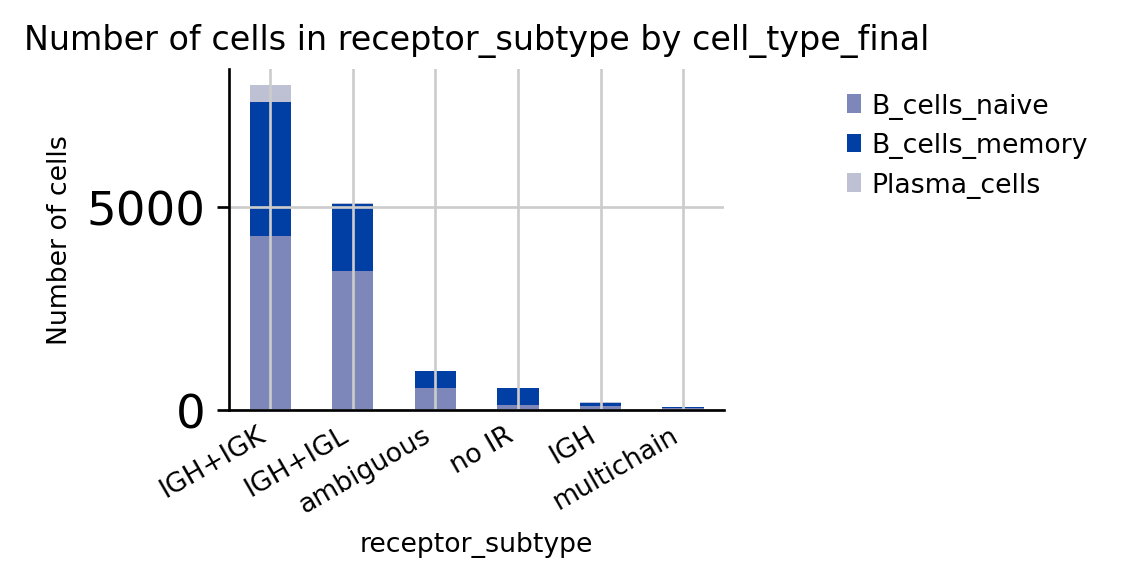

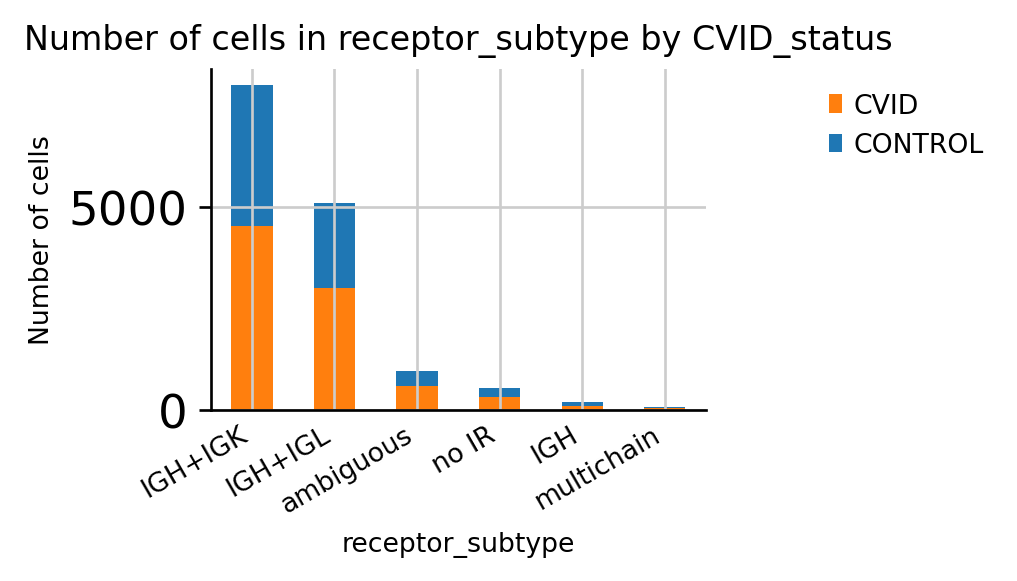

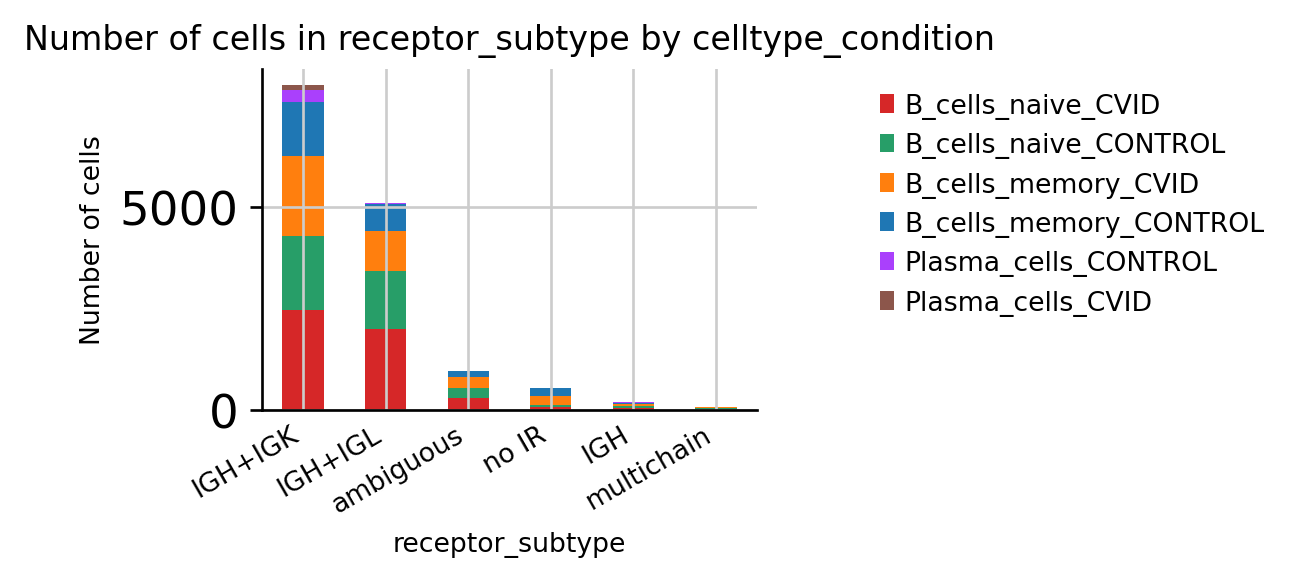

In [34]:
ir.pl.group_abundance(adata, groupby="receptor_subtype", target_col="cell_type_final")
ir.pl.group_abundance(adata, groupby="receptor_subtype", target_col="CVID_status")
ir.pl.group_abundance(adata, groupby="receptor_subtype", target_col="celltype_condition")


In [35]:
adata

AnnData object with n_obs × n_vars = 14862 × 2696
    obs: 'n_genes', 'stimulation', 'sample', 'cell_id', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'cell_type_final', 'S_score', 'G2M_score', 'phase', 'louvain', 'n_counts_protein', 'n_counts_protein_lognorm', 'donor', 'Age', 'Sex', 'Age of disease onset', 'Autoimmunity', 'Gastrointestinal disease', 'Lung disease (bronchiectasis)', 'Lymphoadenopathy ', 'Splenomegaly', 'History of hypogammaglobulinemia, IgA deficiency or immunodeficiency in other family members', 'CVID_status', 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_cdr3', 'IR_VJ_2_cdr3', 'IR_VDJ_1_cdr3', 'IR_VDJ_2_cdr3', 'IR_VJ_1_cdr3_nt', 'IR_VJ_2_cdr3_nt', 'IR_VDJ_1_cdr3_nt', 'IR_VDJ_2_cdr3_nt', 'IR_VJ_1_expr', 'IR_VJ_2_expr', 'IR_VDJ_1_expr', 'IR_VDJ_2_expr', 'IR_VJ_1_expr_raw', 'IR_VJ_2_expr_raw', 'IR_VDJ_1_expr_raw', 'IR_VDJ_2_expr_raw', 'IR_VJ_1_v_gene', '

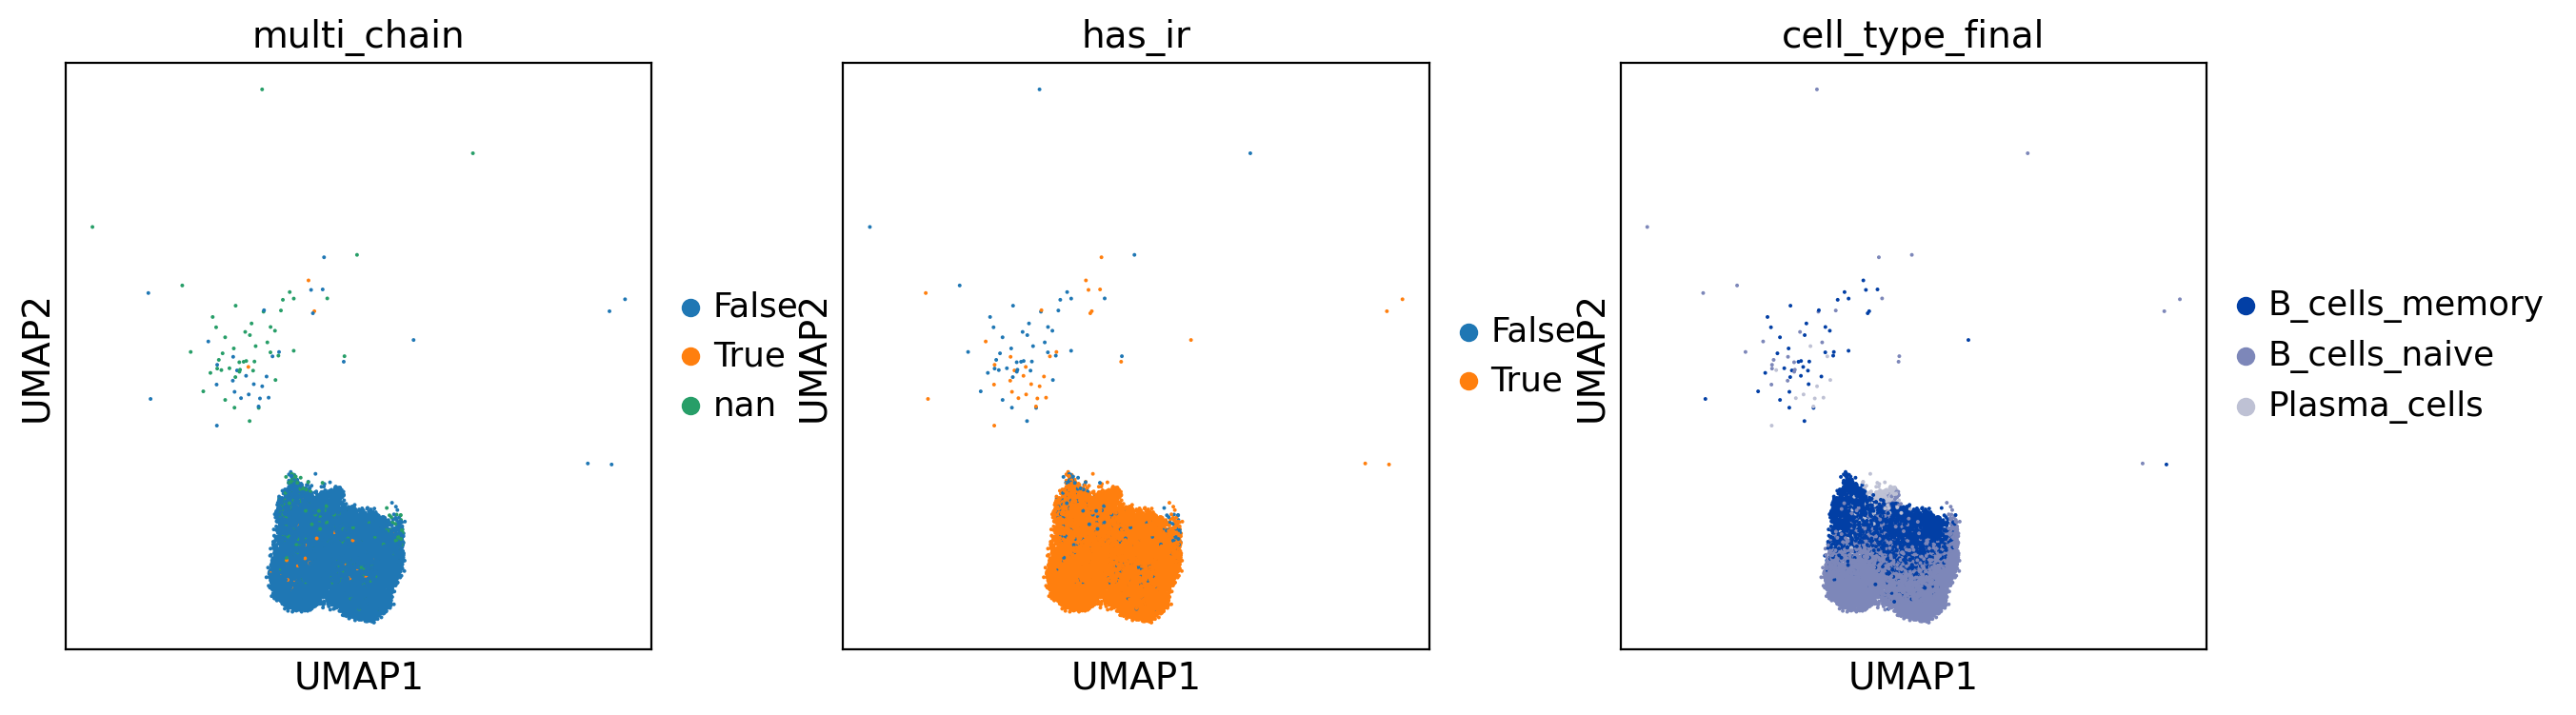

In [36]:
sc.pl.umap(adata, color=['multi_chain','has_ir','cell_type_final'])


# Define clonotypes and clonotype clusters


### Compute CDR3 neighborhood graph and define clonotypes


In [37]:
# using default parameters, `ir_neighbors` will compute nucleotide sequence identity
ir.pp.ir_neighbors(adata, receptor_arms="all", dual_ir="primary_only")
ir.tl.define_clonotypes(adata)

100%|██████████| 181127/181127 [00:03<00:00, 57561.65it/s]


... storing 'clonotype' as categorical


array([<AxesSubplot:title={'center':'clonotype'}, xlabel='clonotype_network1', ylabel='clonotype_network2'>],
      dtype=object)

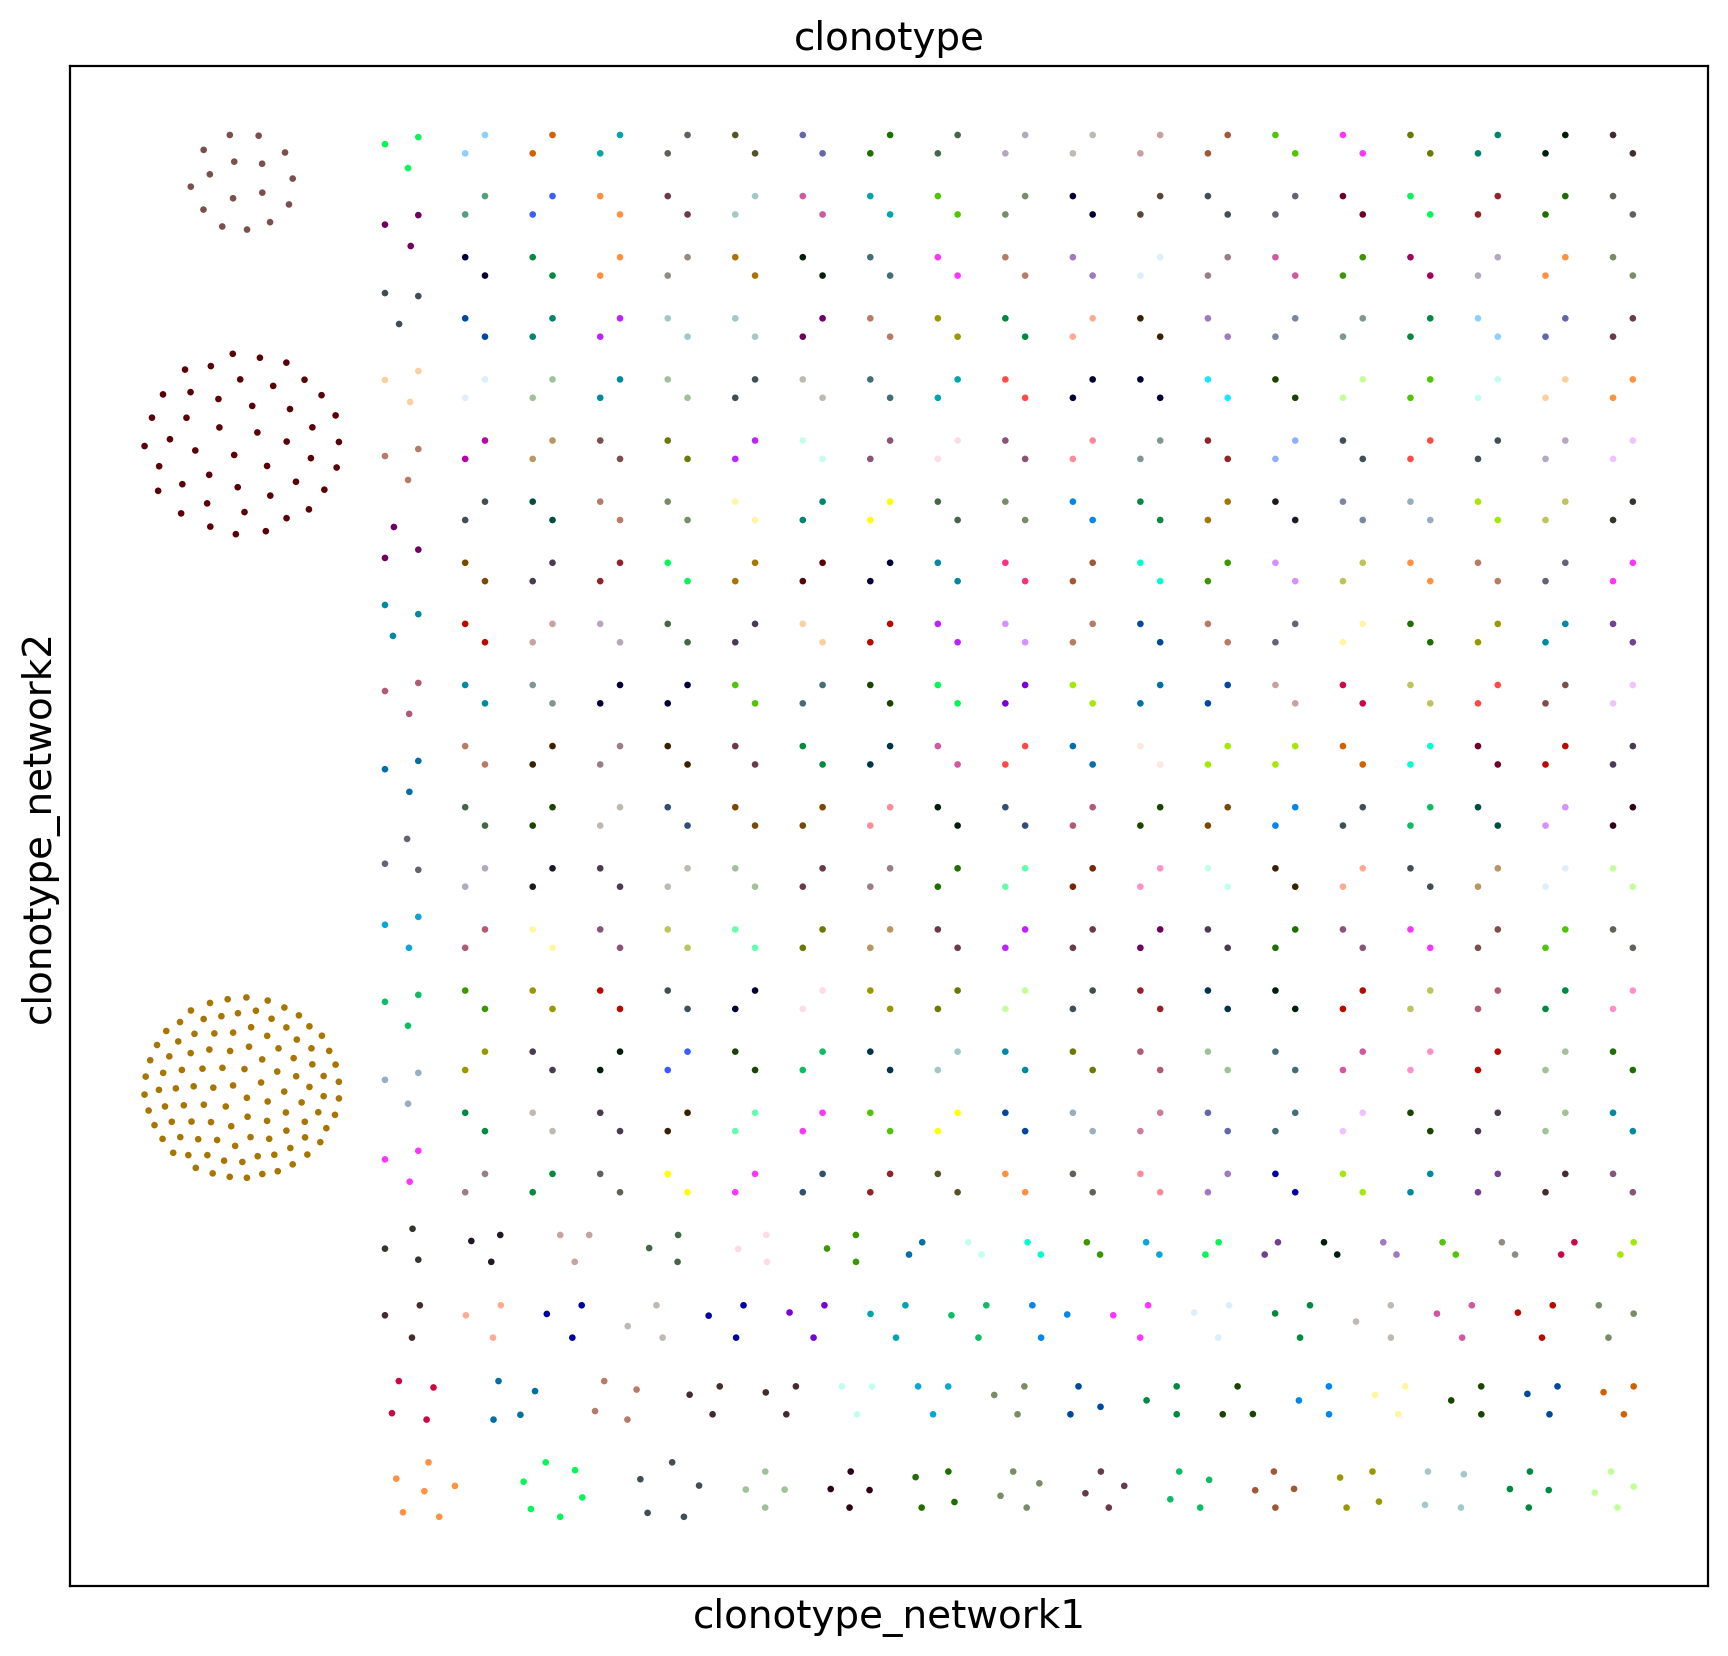

In [38]:
ir.tl.clonotype_network(adata, min_size=2)
ir.pl.clonotype_network(adata, color="clonotype", legend_loc="none")

In [56]:
# using default parameters, `ir_neighbors` will compute nucleotide sequence identity
ir.pp.ir_neighbors(adata_twins, receptor_arms="all", dual_ir="primary_only")
ir.tl.define_clonotypes(adata_twins)

100%|██████████| 5703/5703 [00:00<00:00, 86491.60it/s]


... storing 'clonotype' as categorical


array([<AxesSubplot:title={'center':'clonotype'}, xlabel='clonotype_network1', ylabel='clonotype_network2'>],
      dtype=object)

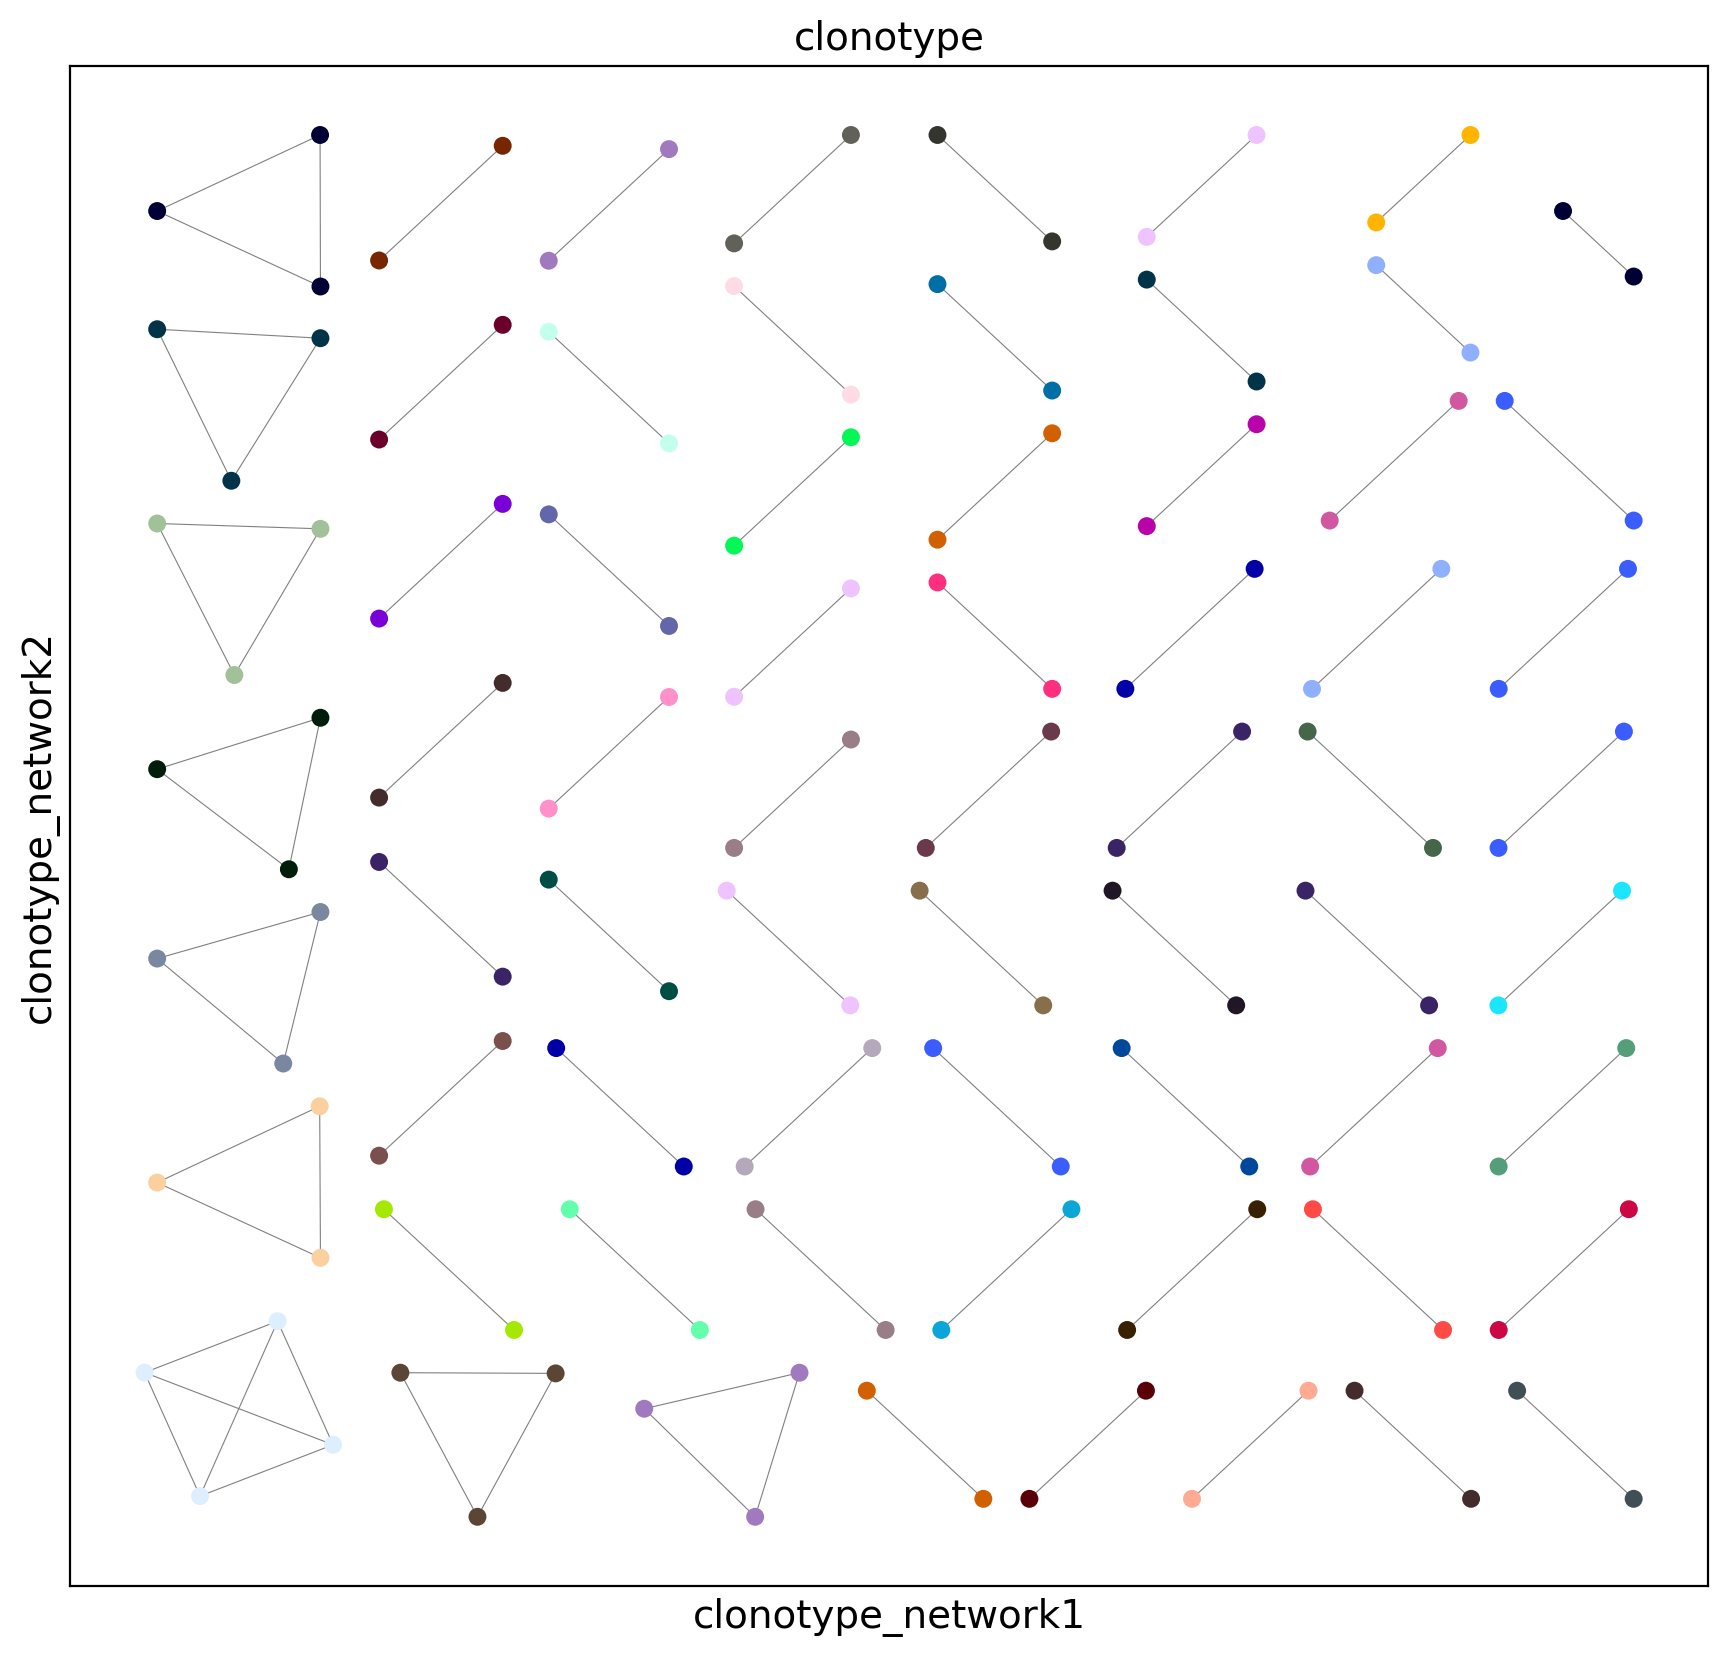

In [40]:
ir.tl.clonotype_network(adata_twins, min_size=2)
ir.pl.clonotype_network(adata_twins, color="clonotype", legend_loc="none")

## Re-compute CDR3 neighborhood graph and define clonotype clusters


In [41]:
ir.pp.ir_neighbors(
    adata,
    metric="alignment",
    sequence="aa",
    cutoff=15,
    receptor_arms="all",
    dual_ir="all",
)
ir.tl.define_clonotype_clusters(
    adata, partitions="connected", sequence="aa", metric="alignment", within_group=None
)

100%|██████████| 6697177/6697177 [01:22<00:00, 81440.95it/s] 


In [42]:
ir.tl.clonotype_network(adata, min_size=4, sequence="aa", metric="alignment")


... storing 'ct_cluster_aa_alignment' as categorical


array([<AxesSubplot:title={'center':'ct_cluster_aa_alignment'}, xlabel='clonotype_network1', ylabel='clonotype_network2'>],
      dtype=object)

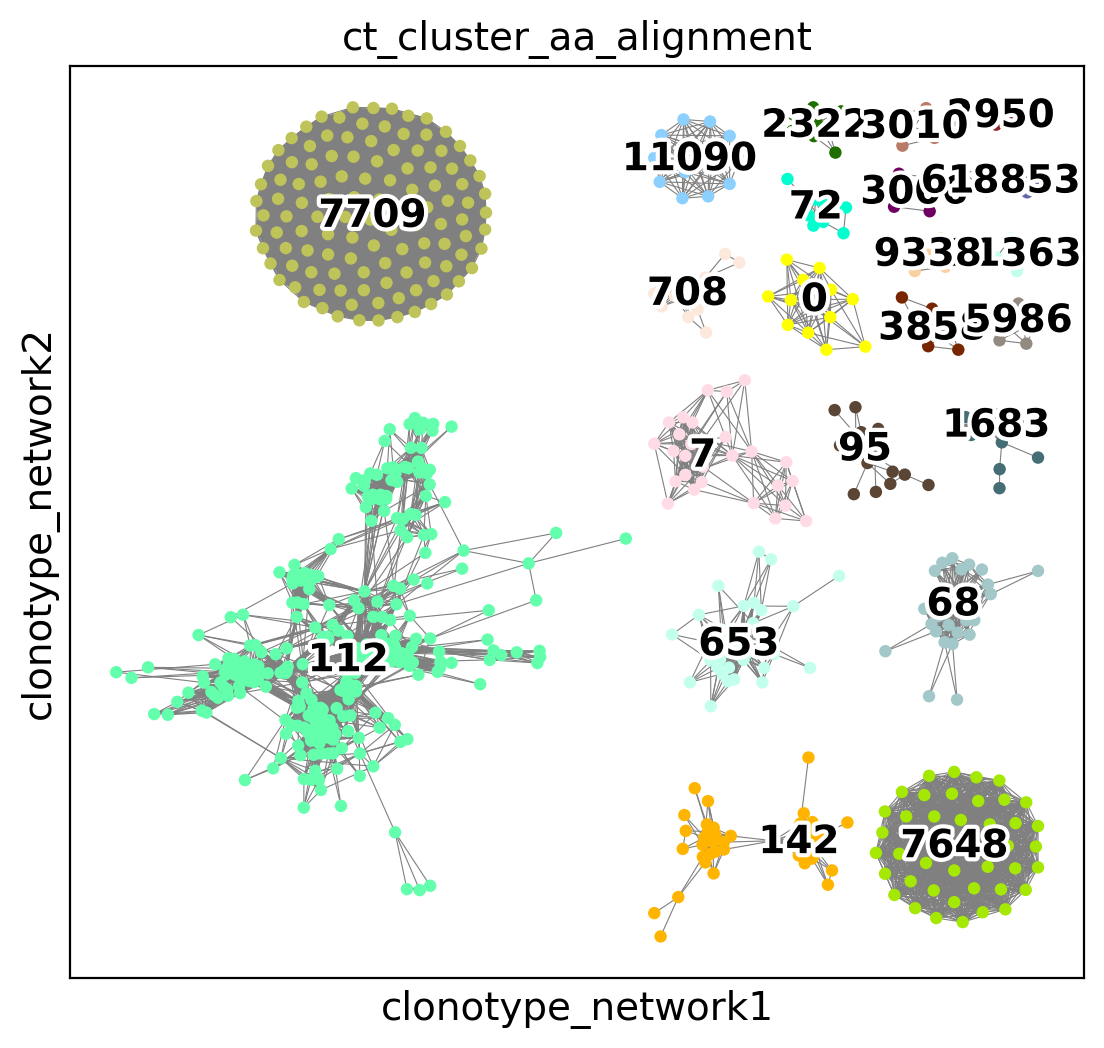

In [43]:
ir.pl.clonotype_network(
    adata,
    color="ct_cluster_aa_alignment",
    legend_fontoutline=3,
    size=80,
    panel_size=(6, 6),
    legend_loc="on data",
)

array([<AxesSubplot:title={'center':'donor'}, xlabel='clonotype_network1', ylabel='clonotype_network2'>],
      dtype=object)

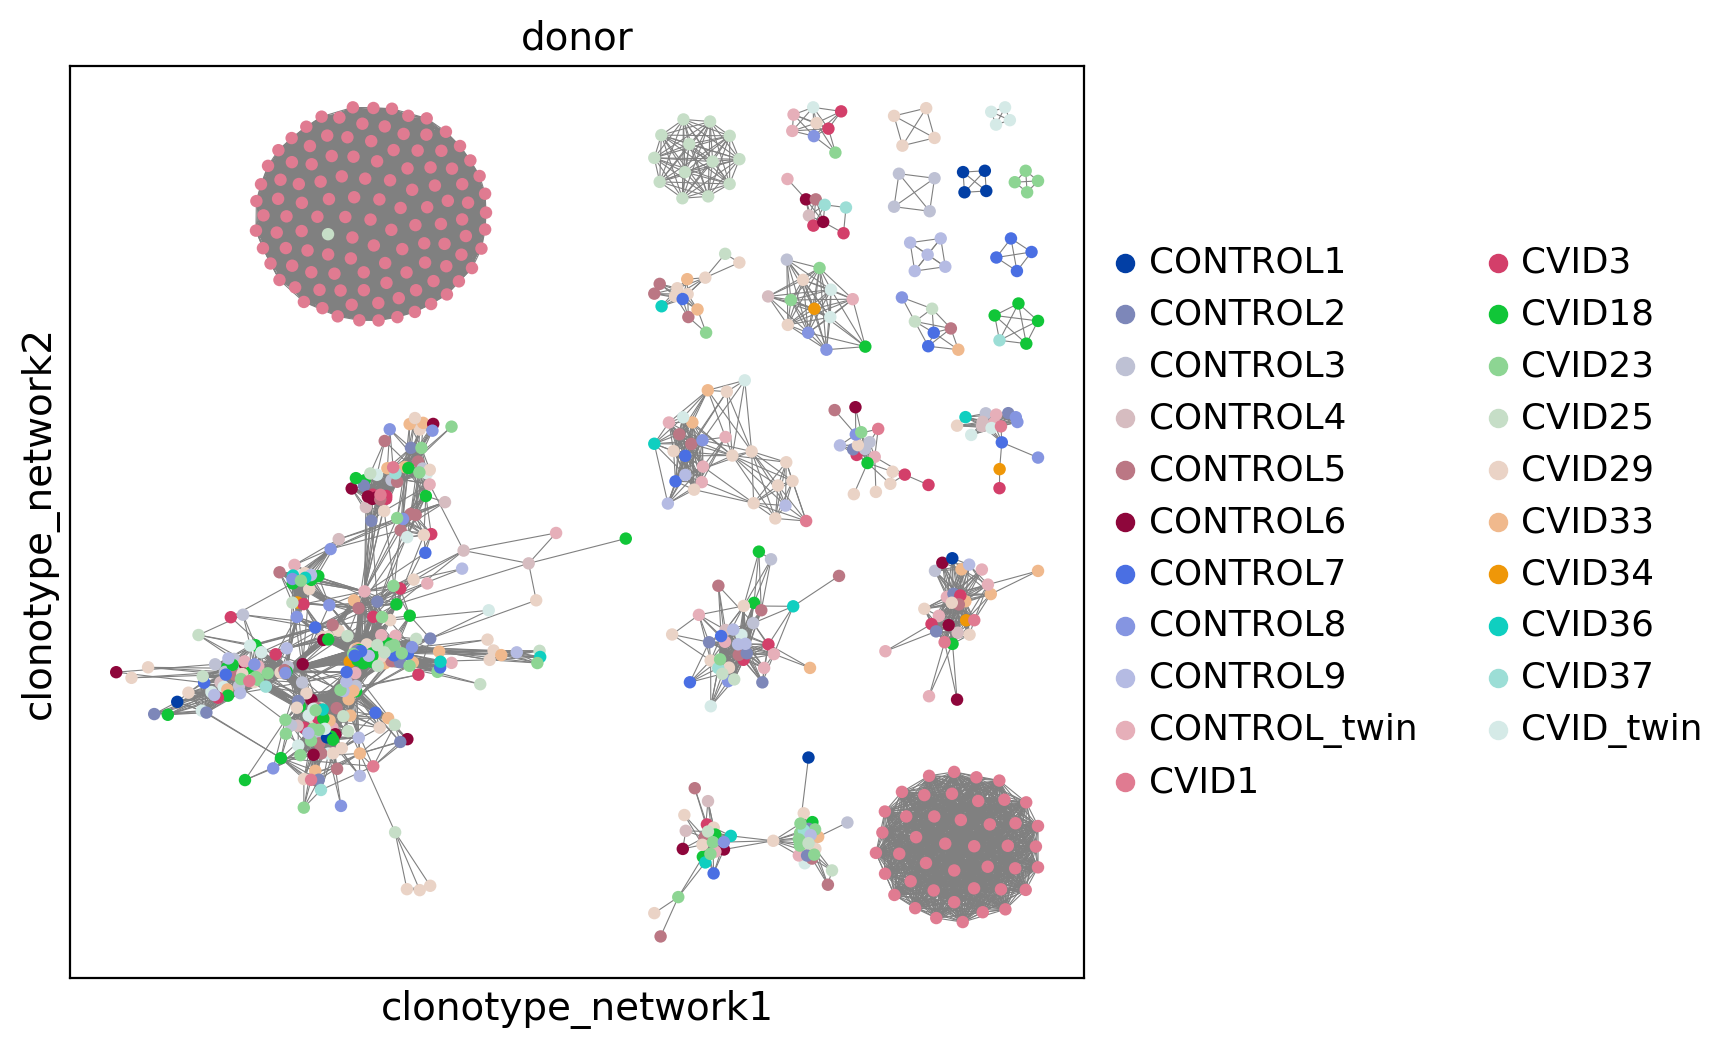

In [44]:
# to rerun
ir.pl.clonotype_network(adata, color="donor", size=80, panel_size=(6, 6))


array([<AxesSubplot:title={'center':'CVID_status'}, xlabel='clonotype_network1', ylabel='clonotype_network2'>],
      dtype=object)

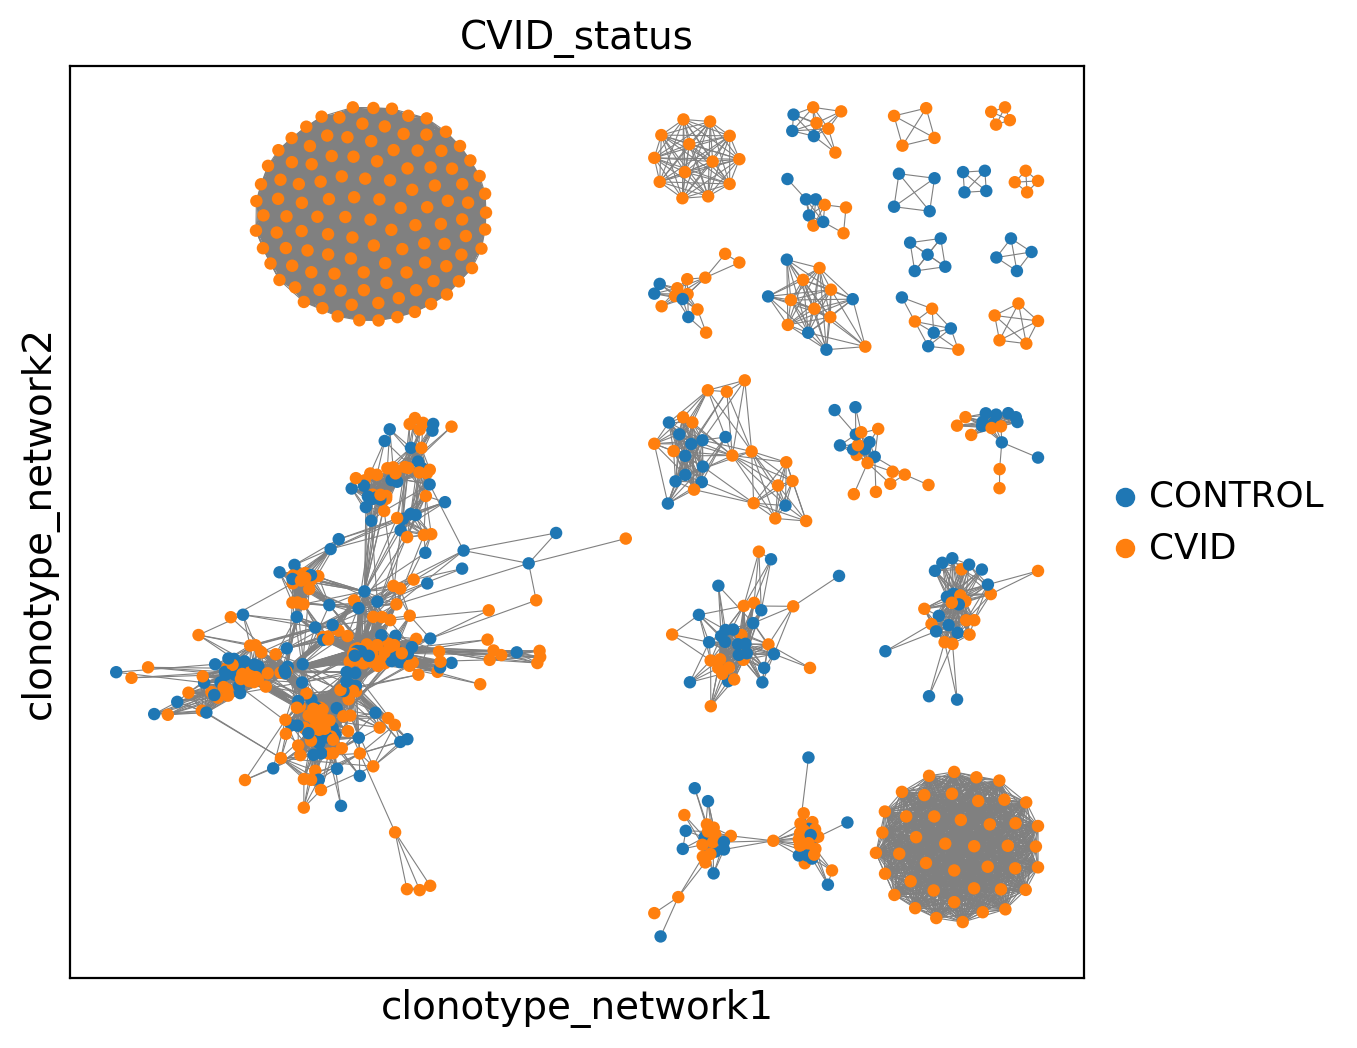

In [45]:
# to rerun
ir.pl.clonotype_network(adata, color="CVID_status", size=80, panel_size=(6, 6))


array([<AxesSubplot:title={'center':'stimulation'}, xlabel='clonotype_network1', ylabel='clonotype_network2'>],
      dtype=object)

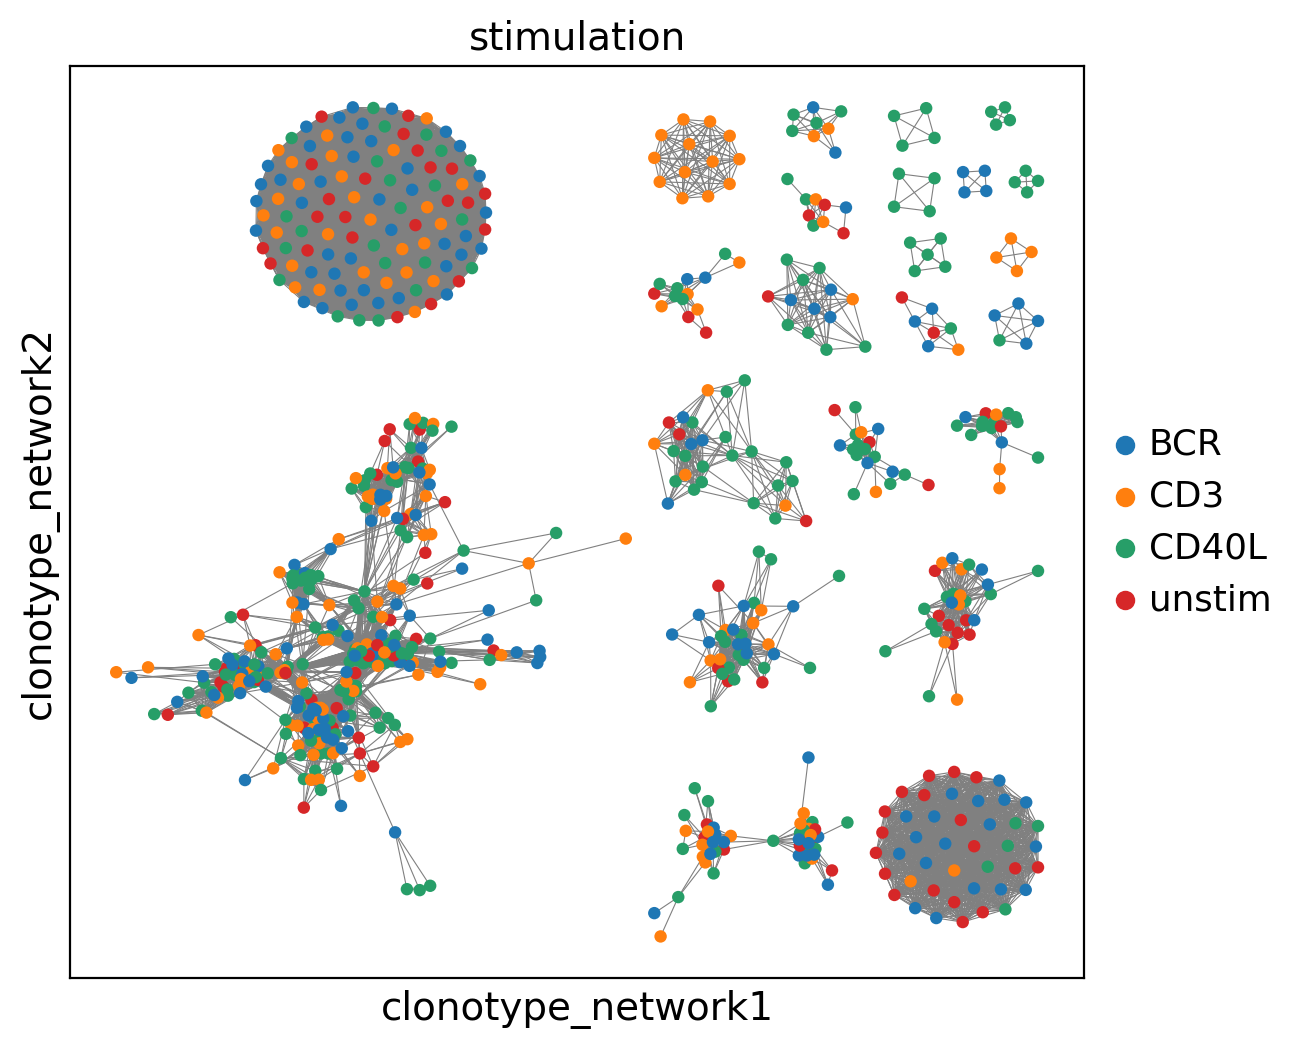

In [46]:
# to rerun
ir.pl.clonotype_network(adata, color="stimulation", size=80, panel_size=(6, 6))


array([<AxesSubplot:title={'center':'cell_type_final'}, xlabel='clonotype_network1', ylabel='clonotype_network2'>],
      dtype=object)

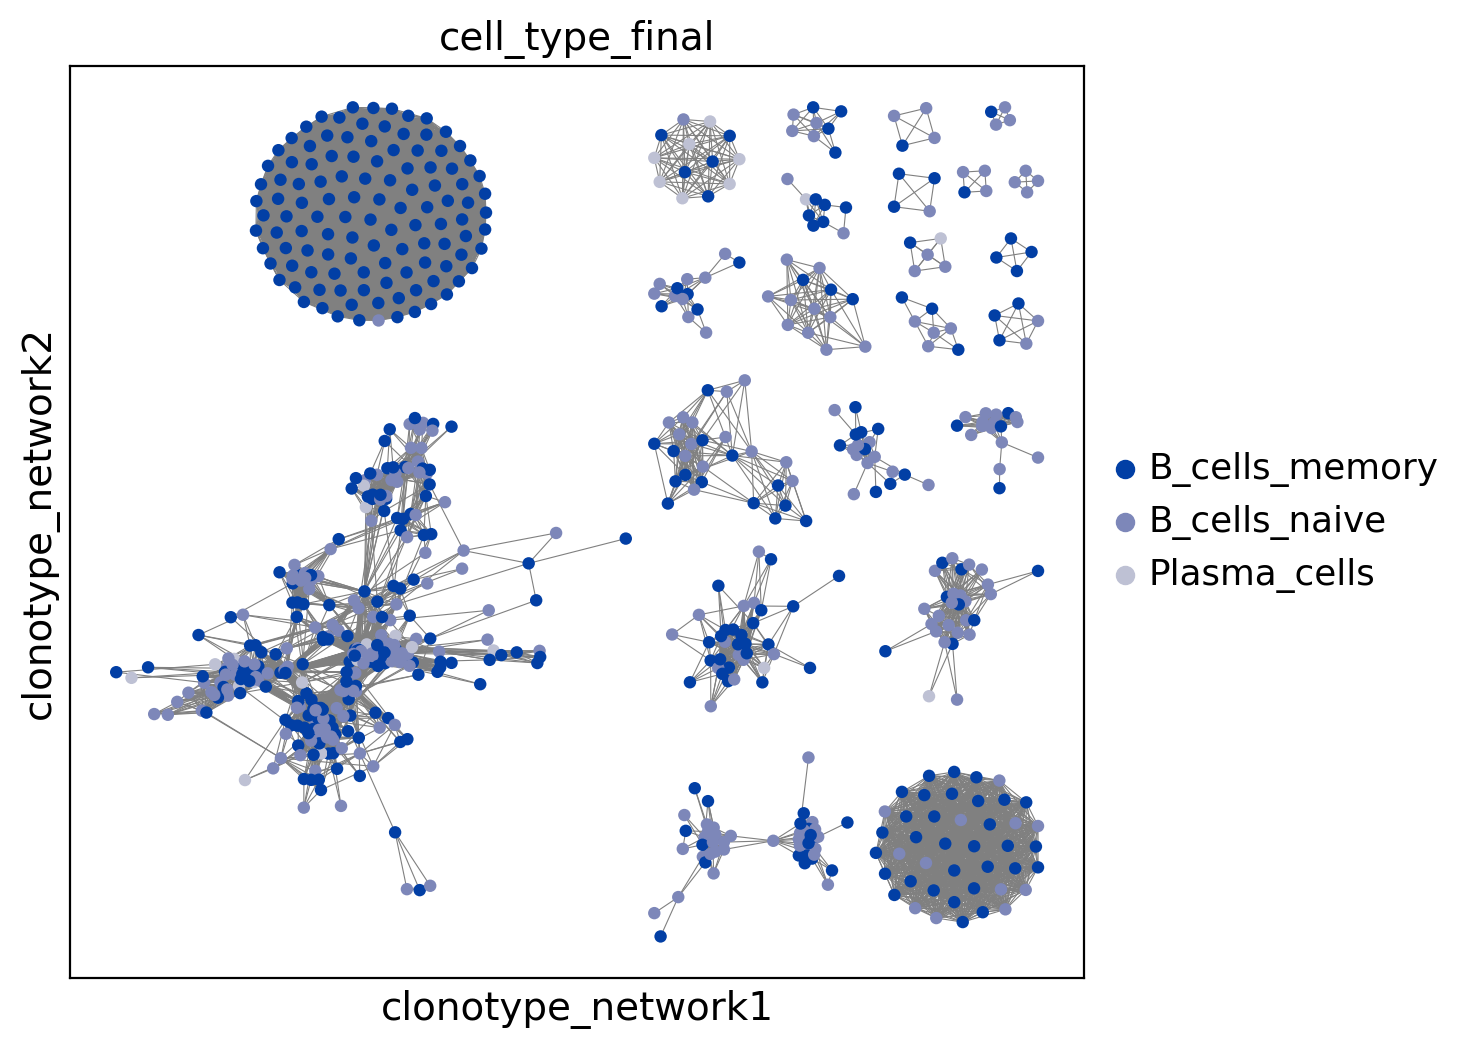

In [47]:
# to rerun
ir.pl.clonotype_network(adata, color="cell_type_final", size=80, panel_size=(6, 6))


array([<AxesSubplot:title={'center':'celltype_condition'}, xlabel='clonotype_network1', ylabel='clonotype_network2'>],
      dtype=object)

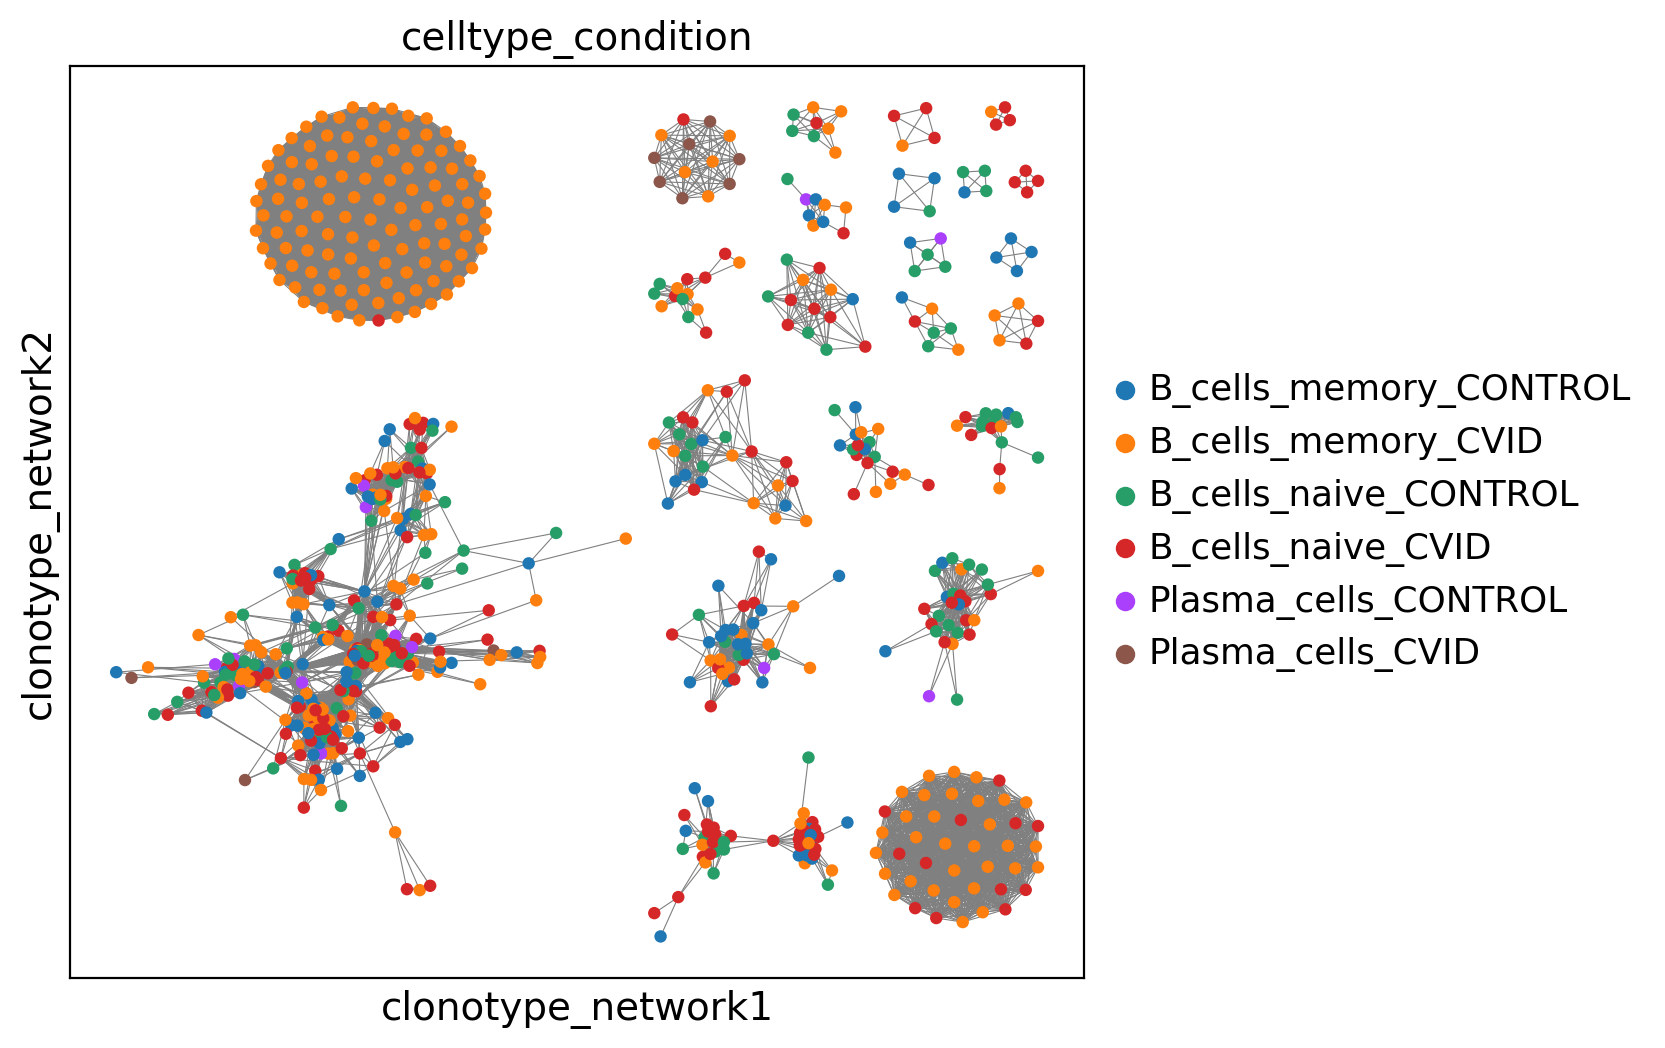

In [48]:
# to rerun
ir.pl.clonotype_network(adata, color="celltype_condition", size=80, panel_size=(6, 6))


In [54]:
adata.obs.loc[
    adata.obs["ct_cluster_aa_alignment"] == "117",
    [
        "IR_VJ_1_cdr3",
        "IR_VJ_2_cdr3",
        "IR_VDJ_1_cdr3",
        "IR_VDJ_2_cdr3",
        "receptor_subtype",
    ],
]

IR_VJ_1_cdr3 IR_VJ_2_cdr3 IR_VDJ_1_cdr3 IR_VDJ_2_cdr3  \
AGGGATGTCACGGTTA-1     CQQYGSSPFLTF         None          None          None   
CCAGCGACACGTGAGA-1    CQQYNNWPPMYTF         None          None          None   
CCCATACAGACGCTTT-1      CQQYYTTPWTF         None          None          None   
CGAGAAGAGTCCATAC-1       CQQLNSPWTF         None          None          None   
CGGACTGCATGCATGT-1      CQQYYSSPLTF         None          None          None   
...                             ...          ...           ...           ...   
TCAACGAGTCGGATCC-1      CQQYGSTPRTF         None          None          None   
TCTCATATCGCCAAAT-1-1    CLQHNSYPQTF         None          None          None   
TGACAACGTTCCACTC-1-1    CQQYNSYPITF         None          None          None   
TGAGGGACAAGAAAGG-1     CQQRSNWPVVTF         None          None          None   
TGGGCGTCACGGCCAT-1      CQQANSFPYTF         None          None          None   

                     receptor_subtype  
AGGGATGTCACGGTTA-1            IGH+IGK  
CCAGCGACACGTGAGA-1            IGH+IGK  
CCCATACAGACGCTTT-1            IGH+IGK  
CGAGAAGAGTCCATAC-1            IGH+IGK  
CGGACTGCATGCATGT-1            IGH+IGK  
...                               ...  
TCAACGAGTCGGATCC-1            IGH+IGK  
TCTCATATCGCCAAAT-1-1          IGH+IGK  
TGACAACGTTCCACTC-1-1          IGH+IGK  
TGAGGGACAAGAAAGG-1            IGH+IGK  
TGGGCGTCACGGCCAT-1            IGH+IGK  

[379 rows x 5 columns]

In [53]:
# and separately for twins only

In [63]:
ir.pp.ir_neighbors(
    adata_twins,
    metric="alignment",
    sequence="aa",
    cutoff=15,
    receptor_arms="all",
    dual_ir="all",
)
ir.tl.define_clonotype_clusters(
    adata_twins, partitions="connected", sequence="aa", metric="alignment", within_group=None
)

100%|██████████| 119427/119427 [00:01<00:00, 96916.41it/s]


In [64]:
ir.tl.clonotype_network(adata_twins, min_size=4, sequence="aa", metric="alignment")


... storing 'clonotype' as categorical
... storing 'ct_cluster_aa_alignment' as categorical


array([<AxesSubplot:title={'center':'ct_cluster_aa_alignment'}, xlabel='clonotype_network1', ylabel='clonotype_network2'>],
      dtype=object)

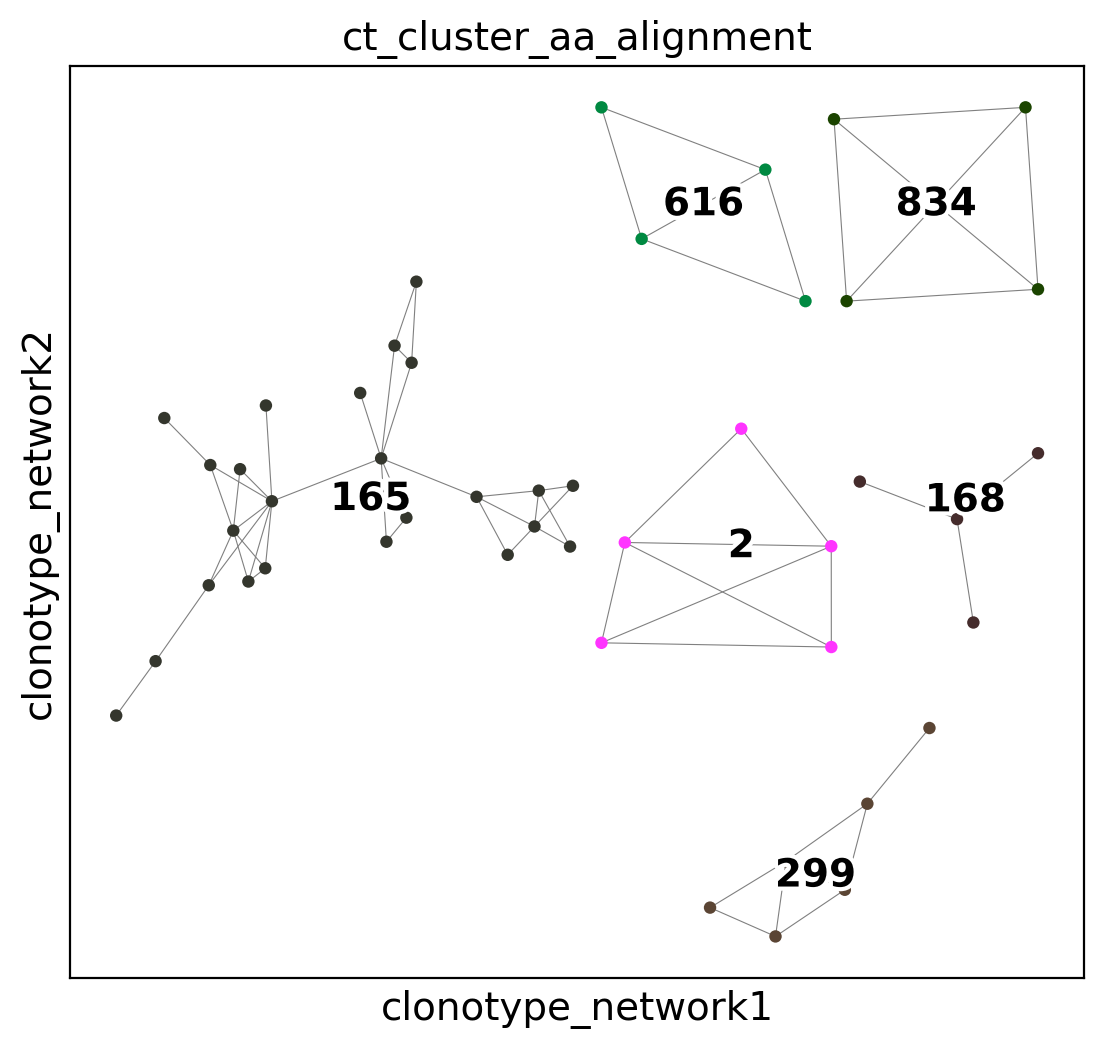

In [65]:
ir.pl.clonotype_network(
    adata_twins,
    color="ct_cluster_aa_alignment",
    legend_fontoutline=3,
    size=80,
    panel_size=(6, 6),
    legend_loc="on data",
)

array([<AxesSubplot:title={'center':'donor'}, xlabel='clonotype_network1', ylabel='clonotype_network2'>],
      dtype=object)

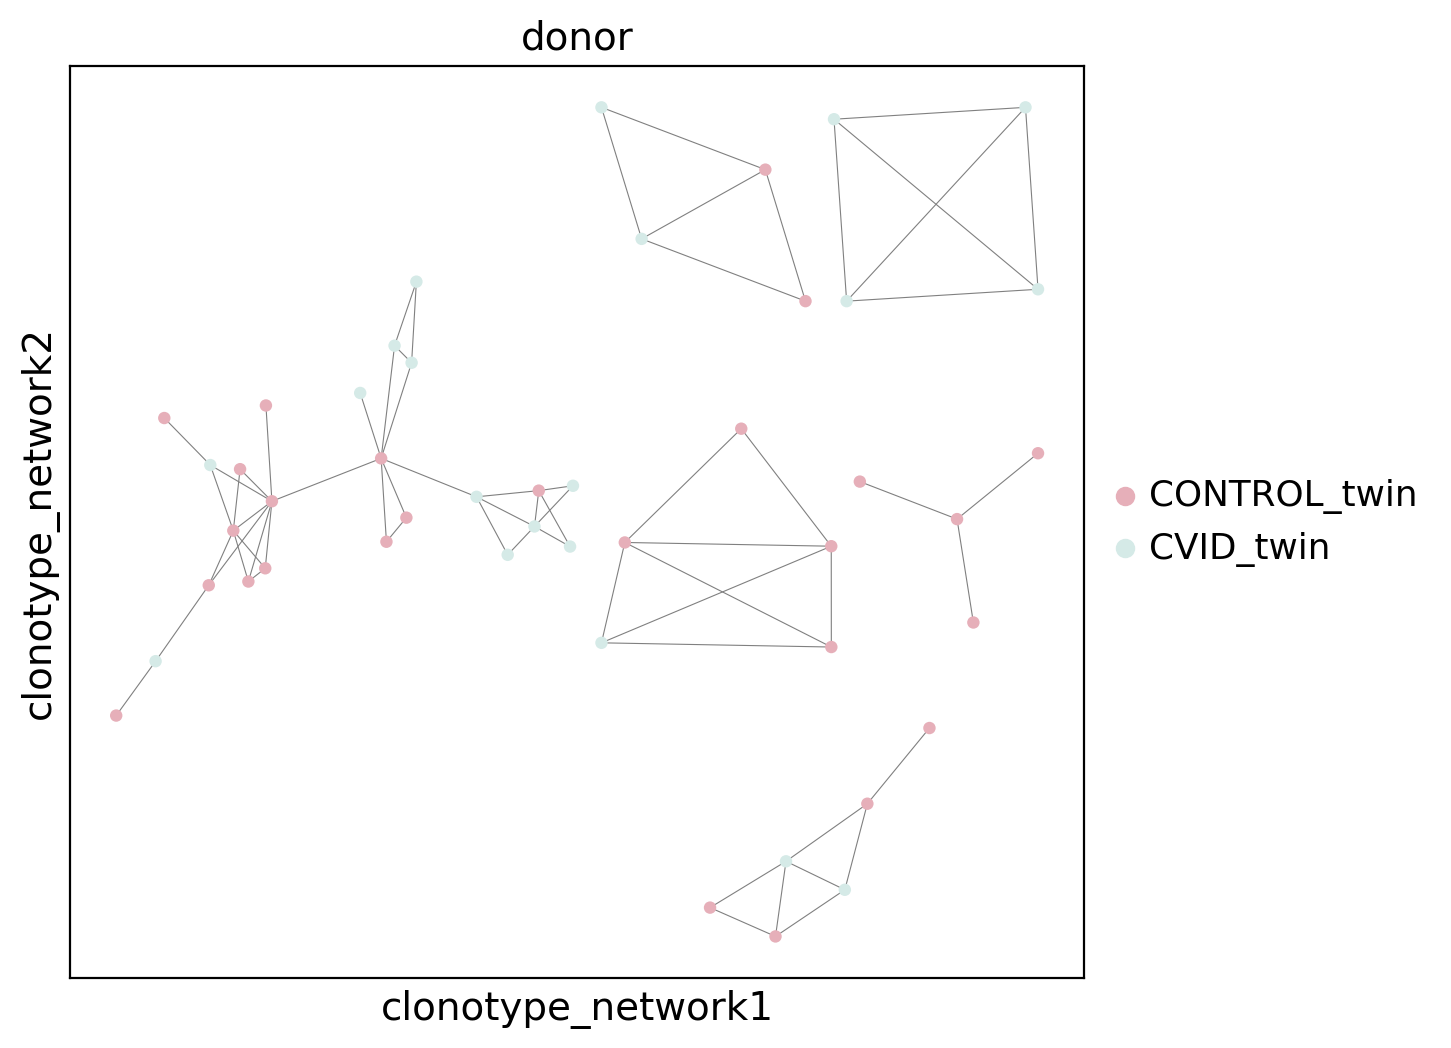

In [66]:
# to rerun
ir.pl.clonotype_network(adata_twins, color="donor", size=80, panel_size=(6, 6))


array([<AxesSubplot:title={'center':'CVID_status'}, xlabel='clonotype_network1', ylabel='clonotype_network2'>],
      dtype=object)

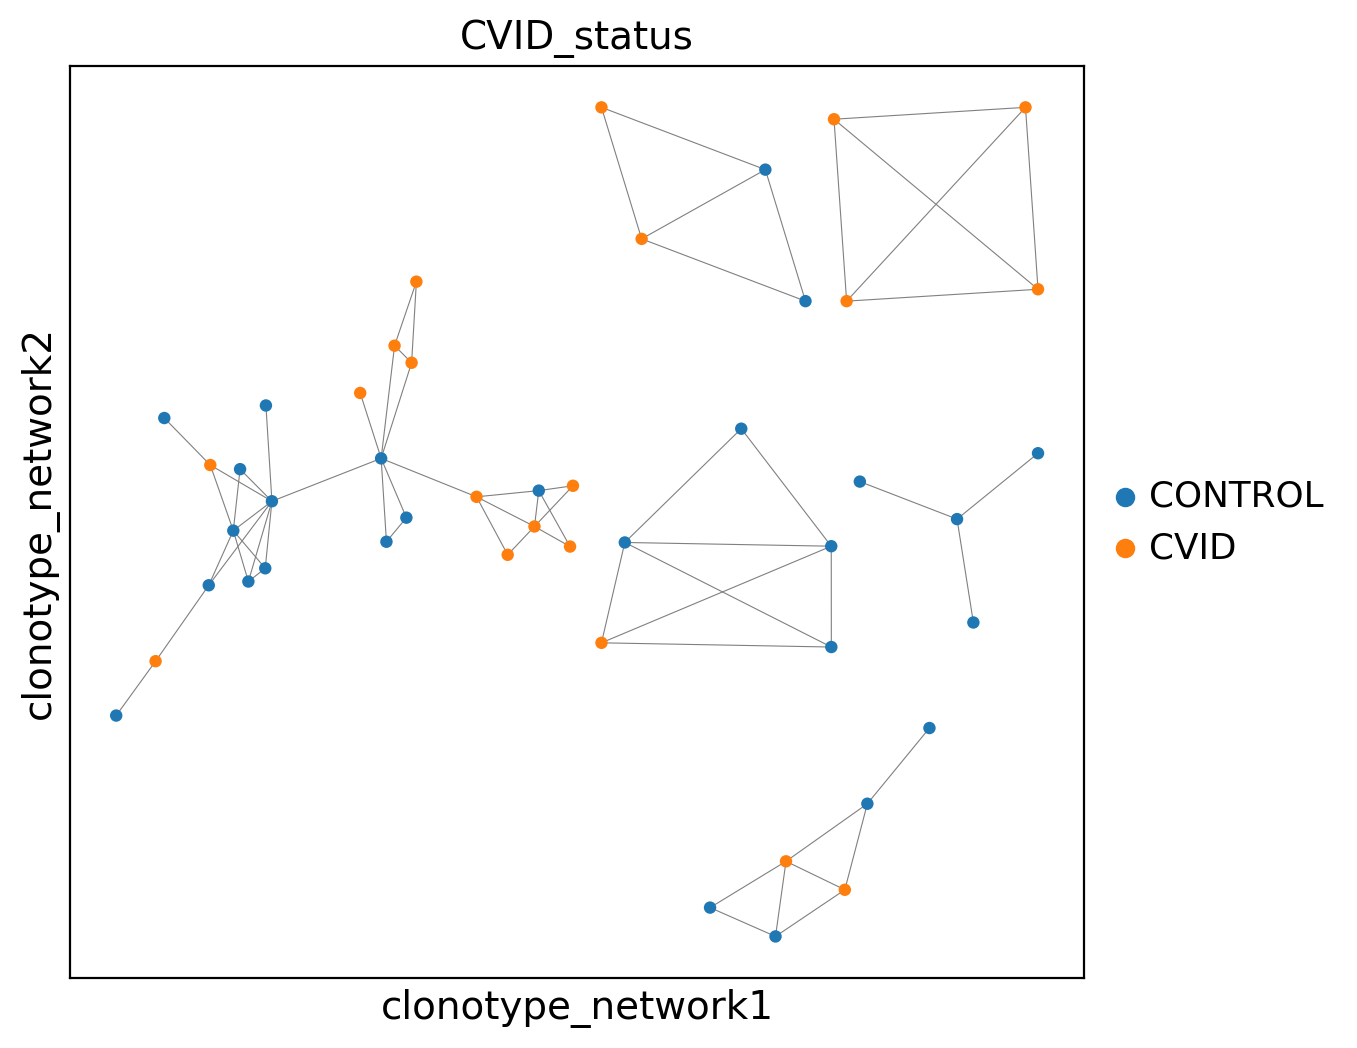

In [67]:
# to rerun
ir.pl.clonotype_network(adata_twins, color="CVID_status", size=80, panel_size=(6, 6))


array([<AxesSubplot:title={'center':'stimulation'}, xlabel='clonotype_network1', ylabel='clonotype_network2'>],
      dtype=object)

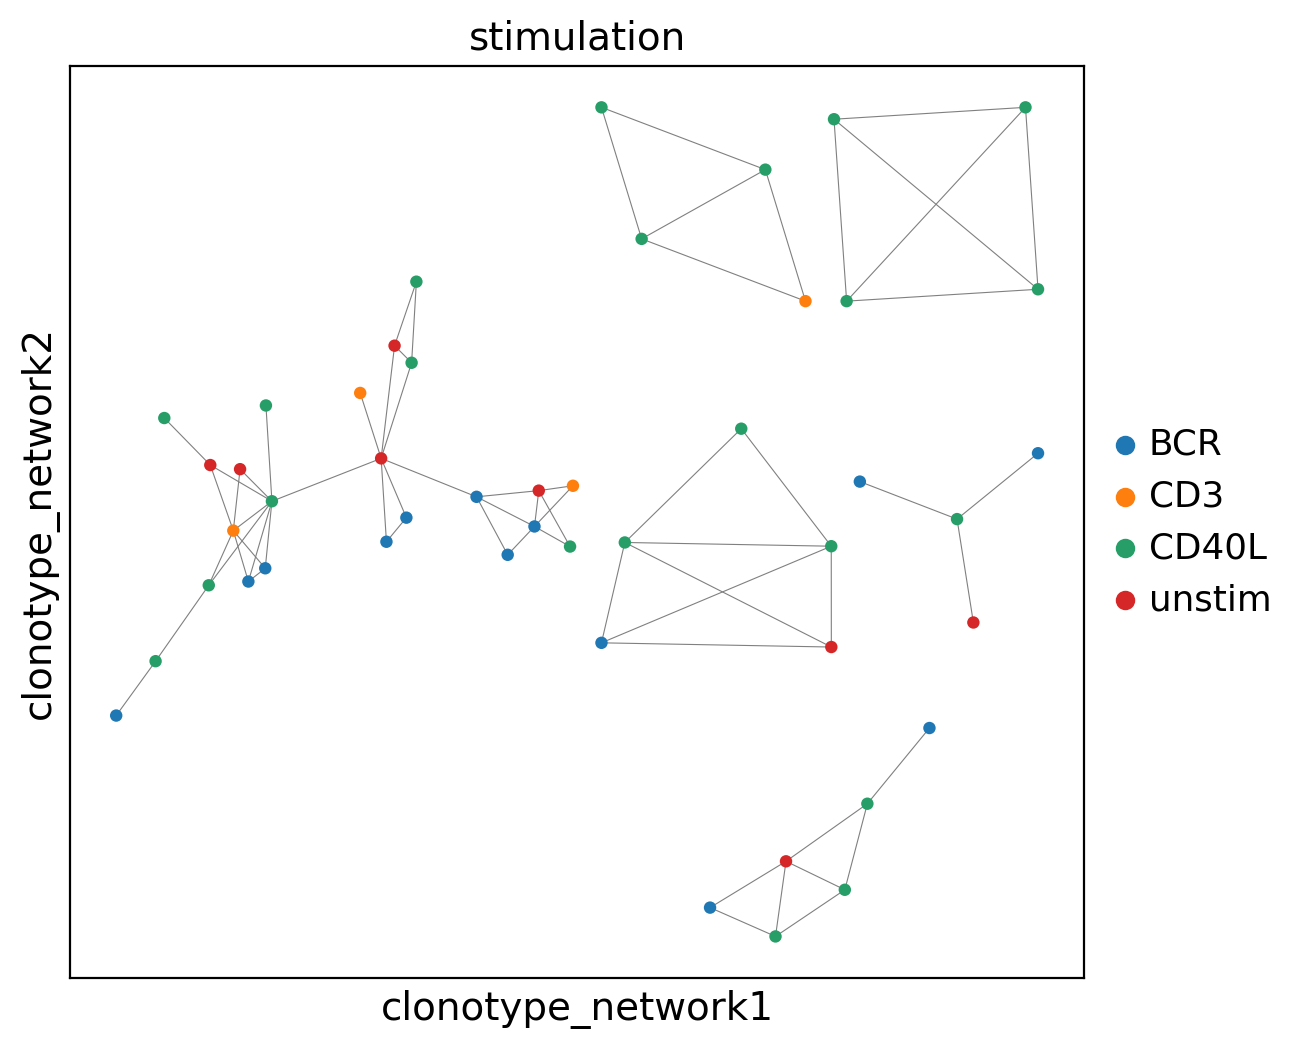

In [68]:
# to rerun
ir.pl.clonotype_network(adata_twins, color="stimulation", size=80, panel_size=(6, 6))


array([<AxesSubplot:title={'center':'cell_type_final'}, xlabel='clonotype_network1', ylabel='clonotype_network2'>],
      dtype=object)

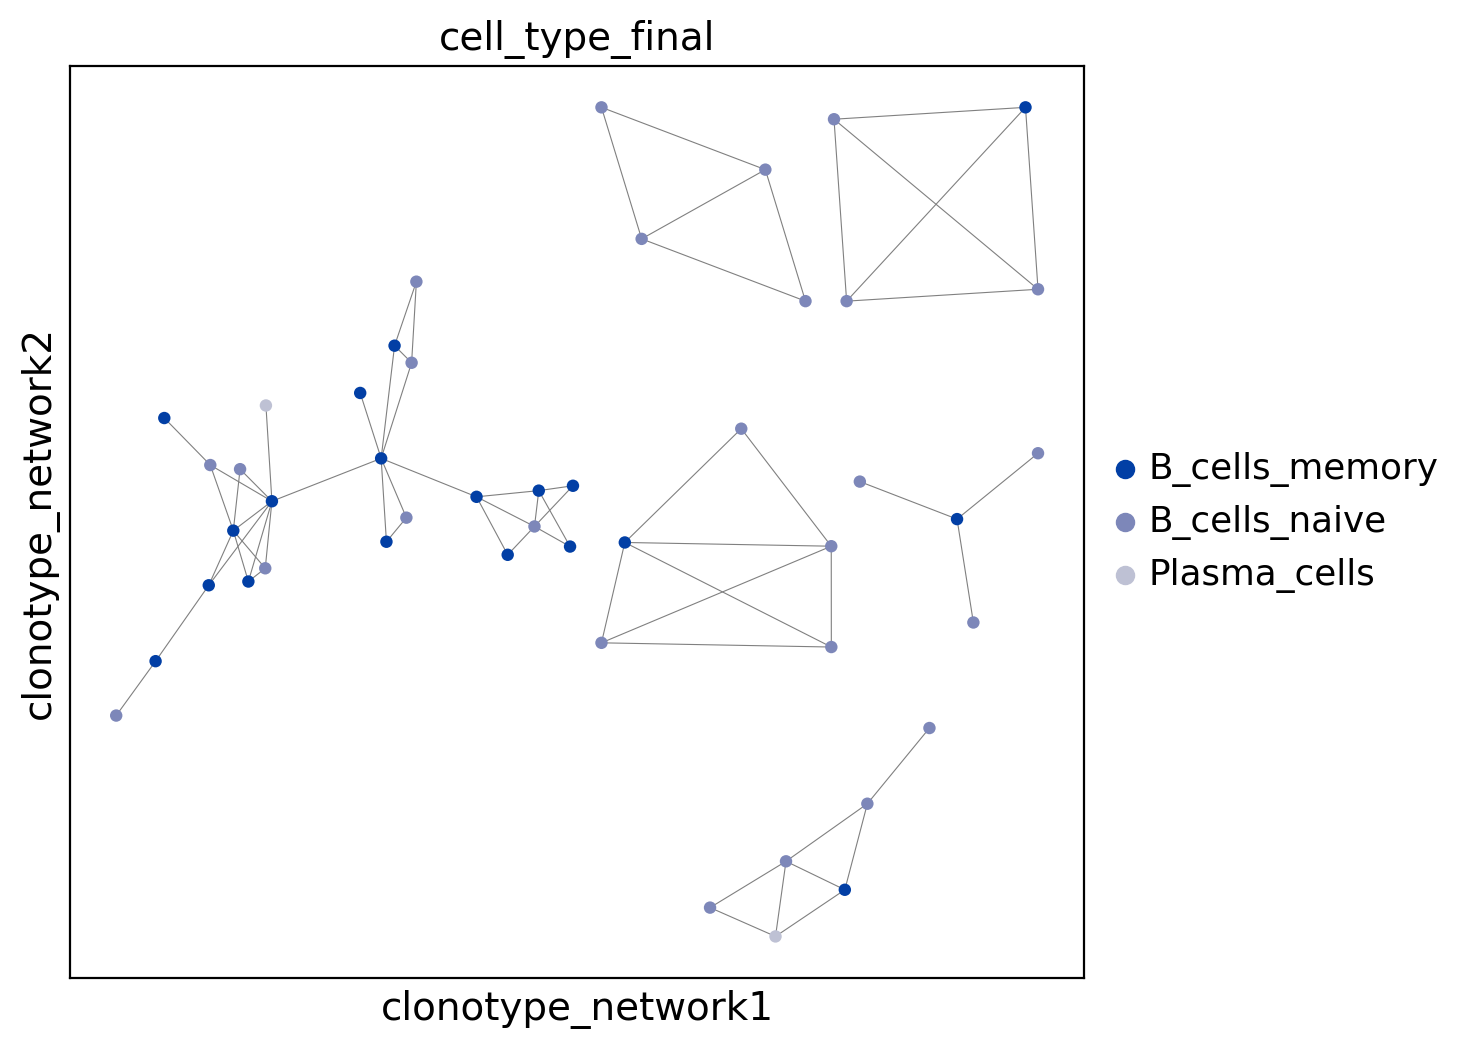

In [69]:
# to rerun
ir.pl.clonotype_network(adata_twins, color="cell_type_final", size=80, panel_size=(6, 6))


array([<AxesSubplot:title={'center':'celltype_condition'}, xlabel='clonotype_network1', ylabel='clonotype_network2'>],
      dtype=object)

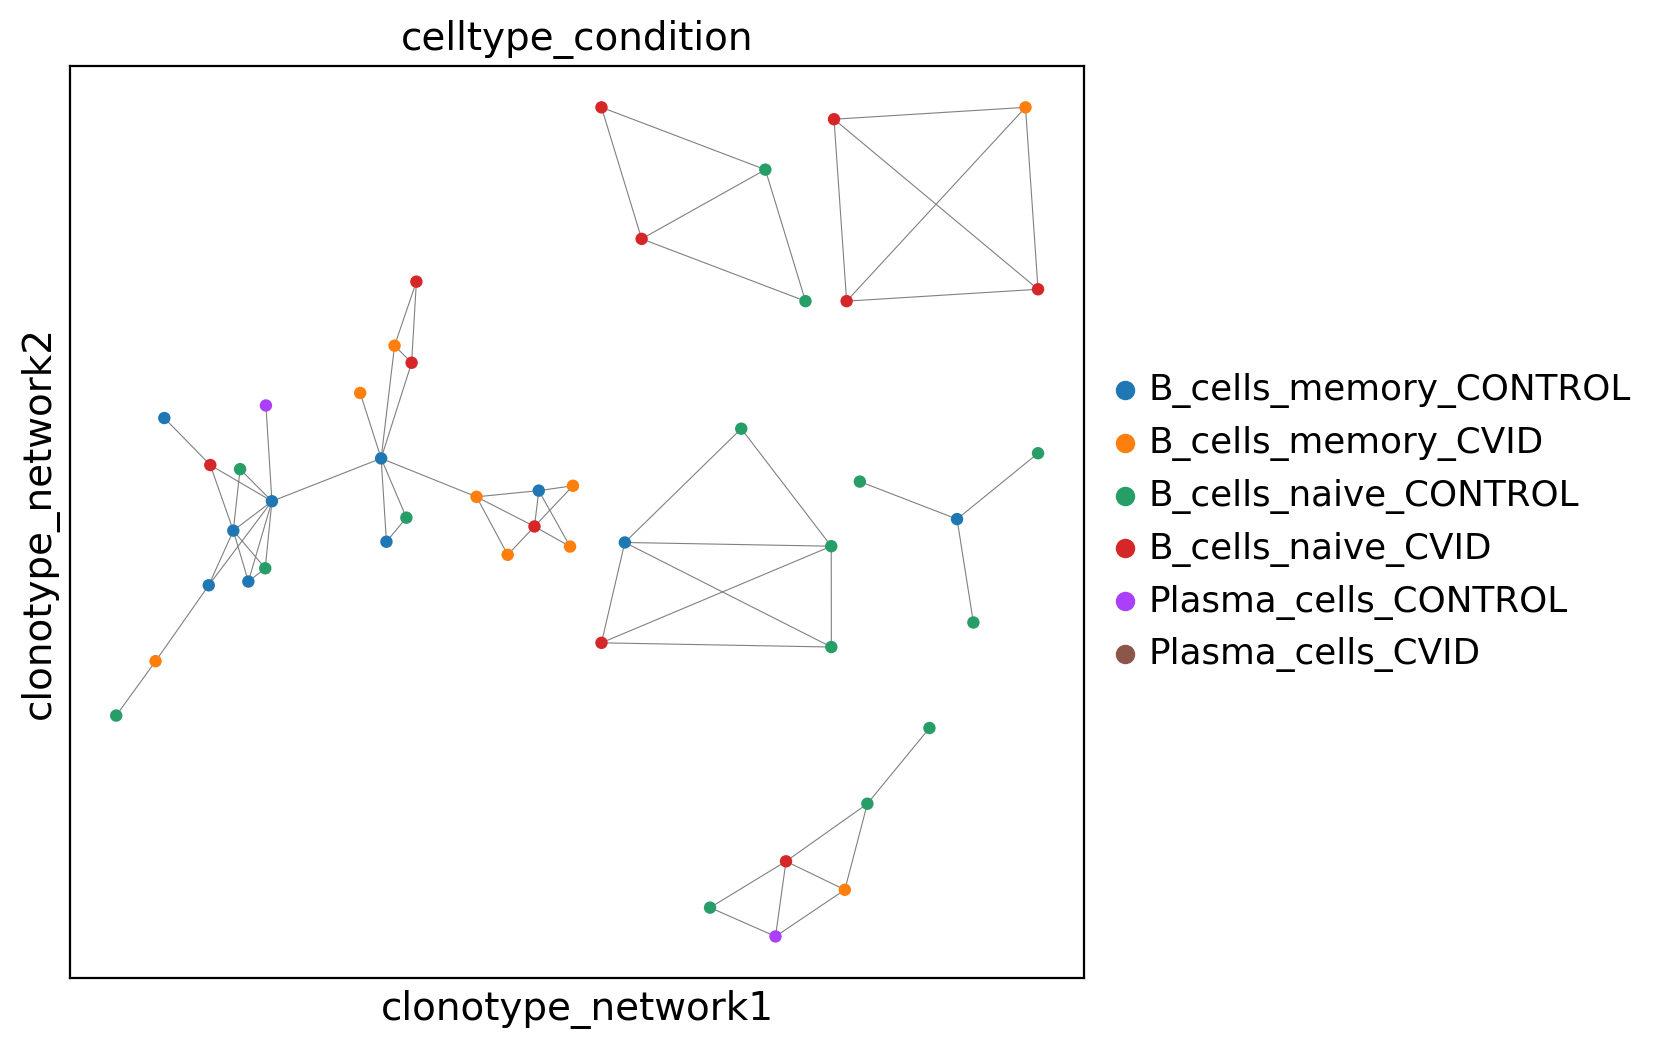

In [70]:
# to rerun
ir.pl.clonotype_network(adata_twins, color="celltype_condition", size=80, panel_size=(6, 6))


In [71]:
adata_twins.obs.loc[
    adata_twins.obs["ct_cluster_aa_alignment"] == "117",
    [
        "IR_VJ_1_cdr3",
        "IR_VJ_2_cdr3",
        "IR_VDJ_1_cdr3",
        "IR_VDJ_2_cdr3",
        "receptor_subtype",
    ],
]

IR_VJ_1_cdr3 IR_VJ_2_cdr3          IR_VDJ_1_cdr3  \
GACTAACGTGTAACGG-1  CQQYNSYPRTF         None  CARGVYCSGGSCYGAESIDYW   

                   IR_VDJ_2_cdr3 receptor_subtype  
GACTAACGTGTAACGG-1          None          IGH+IGK

## Including the V-gene in clonotype definition


In [49]:
ir.tl.define_clonotype_clusters(
    adata,
    sequence="aa",
    metric="alignment",
    same_v_gene="primary_only",
    key_added="ct_cluster_aa_alignment_same_v",
)

In [50]:
# find clonotypes with more than one `clonotype_same_v`
ct_different_v = adata.obs.groupby("ct_cluster_aa_alignment").apply(
    lambda x: x["ct_cluster_aa_alignment_same_v"].unique().size > 1
)
ct_different_v = ct_different_v[ct_different_v].index.values
ct_different_v

['0', '43', '68', '95', '112', ..., '6560', '8320', '8326', '8340', '11048']
Length: 25
Categories (13768, object): ['0', '1', '2', '3', ..., '13764', '13765', '13766', '13767']

In [51]:
# Display the first 2 clonotypes with different v genes
adata.obs.loc[
    adata.obs["ct_cluster_aa_alignment"].isin(ct_different_v[:2]),
    [
        "ct_cluster_aa_alignment",
        "ct_cluster_aa_alignment_same_v",
        "IR_VJ_1_v_gene",
        "IR_VDJ_1_v_gene",
    ],
].sort_values("ct_cluster_aa_alignment").drop_duplicates().reset_index(drop=True)

ct_cluster_aa_alignment ct_cluster_aa_alignment_same_v IR_VJ_1_v_gene  \
0                       0             0_IGLV3-25_nan_BCR       IGLV3-25   
1                       0             0_IGLV3-16_nan_BCR       IGLV3-16   
2                      43        43_IGKV1-5_IGHV4-34_BCR        IGKV1-5   
3                      43       43_IGKV3-20_IGHV4-34_BCR       IGKV3-20   

  IR_VDJ_1_v_gene  
0             nan  
1             nan  
2        IGHV4-34  
3        IGHV4-34

In [72]:
ir.tl.define_clonotype_clusters(
    adata_twins,
    sequence="aa",
    metric="alignment",
    same_v_gene="primary_only",
    key_added="ct_cluster_aa_alignment_same_v",
)

In [73]:
# find clonotypes with more than one `clonotype_same_v`
ct_different_v = adata_twins.obs.groupby("ct_cluster_aa_alignment").apply(
    lambda x: x["ct_cluster_aa_alignment_same_v"].unique().size > 1
)
ct_different_v = ct_different_v[ct_different_v].index.values
ct_different_v

['165', '299', '891']
Categories (1882, object): ['0', '1', '2', '3', ..., '1878', '1879', '1880', '1881']

In [74]:
ir.tl.define_clonotype_clusters(
    adata_twins,
    sequence="aa",
    metric="alignment",
    same_v_gene="primary_only",
    key_added="ct_cluster_aa_alignment_same_v",
)

In [75]:
# Display the first 2 clonotypes with different v genes
adata_twins.obs.loc[
    adata_twins.obs["ct_cluster_aa_alignment"].isin(ct_different_v[:2]),
    [
        "ct_cluster_aa_alignment",
        "ct_cluster_aa_alignment_same_v",
        "IR_VJ_1_v_gene",
        "IR_VDJ_1_v_gene",
    ],
].sort_values("ct_cluster_aa_alignment").drop_duplicates().reset_index(drop=True)

ct_cluster_aa_alignment ct_cluster_aa_alignment_same_v IR_VJ_1_v_gene  \
0                      165          165_IGKV1D-39_nan_BCR      IGKV1D-39   
1                      165            165_IGKV4-1_nan_BCR        IGKV4-1   
2                      165           165_IGKV3-20_nan_BCR       IGKV3-20   
3                      165           165_IGKV1-33_nan_BCR       IGKV1-33   
4                      165            165_IGKV1-5_nan_BCR        IGKV1-5   
5                      165           165_IGKV1-16_nan_BCR       IGKV1-16   
6                      165           165_IGKV1-12_nan_BCR       IGKV1-12   
7                      165           165_IGKV1-17_nan_BCR       IGKV1-17   
8                      165           165_IGKV3-15_nan_BCR       IGKV3-15   
9                      299          299_IGKV2D-28_nan_BCR      IGKV2D-28   
10                     299          299_IGKV2D-29_nan_BCR      IGKV2D-29   

   IR_VDJ_1_v_gene  
0              nan  
1              nan  
2              nan  
3              nan  
4              nan  
5              nan  
6              nan  
7              nan  
8              nan  
9              nan  
10             nan

# Clonotype analysis


### Clonal expansion


In [76]:
ir.tl.clonal_expansion(adata)
ir.tl.clonal_expansion(adata_twins)


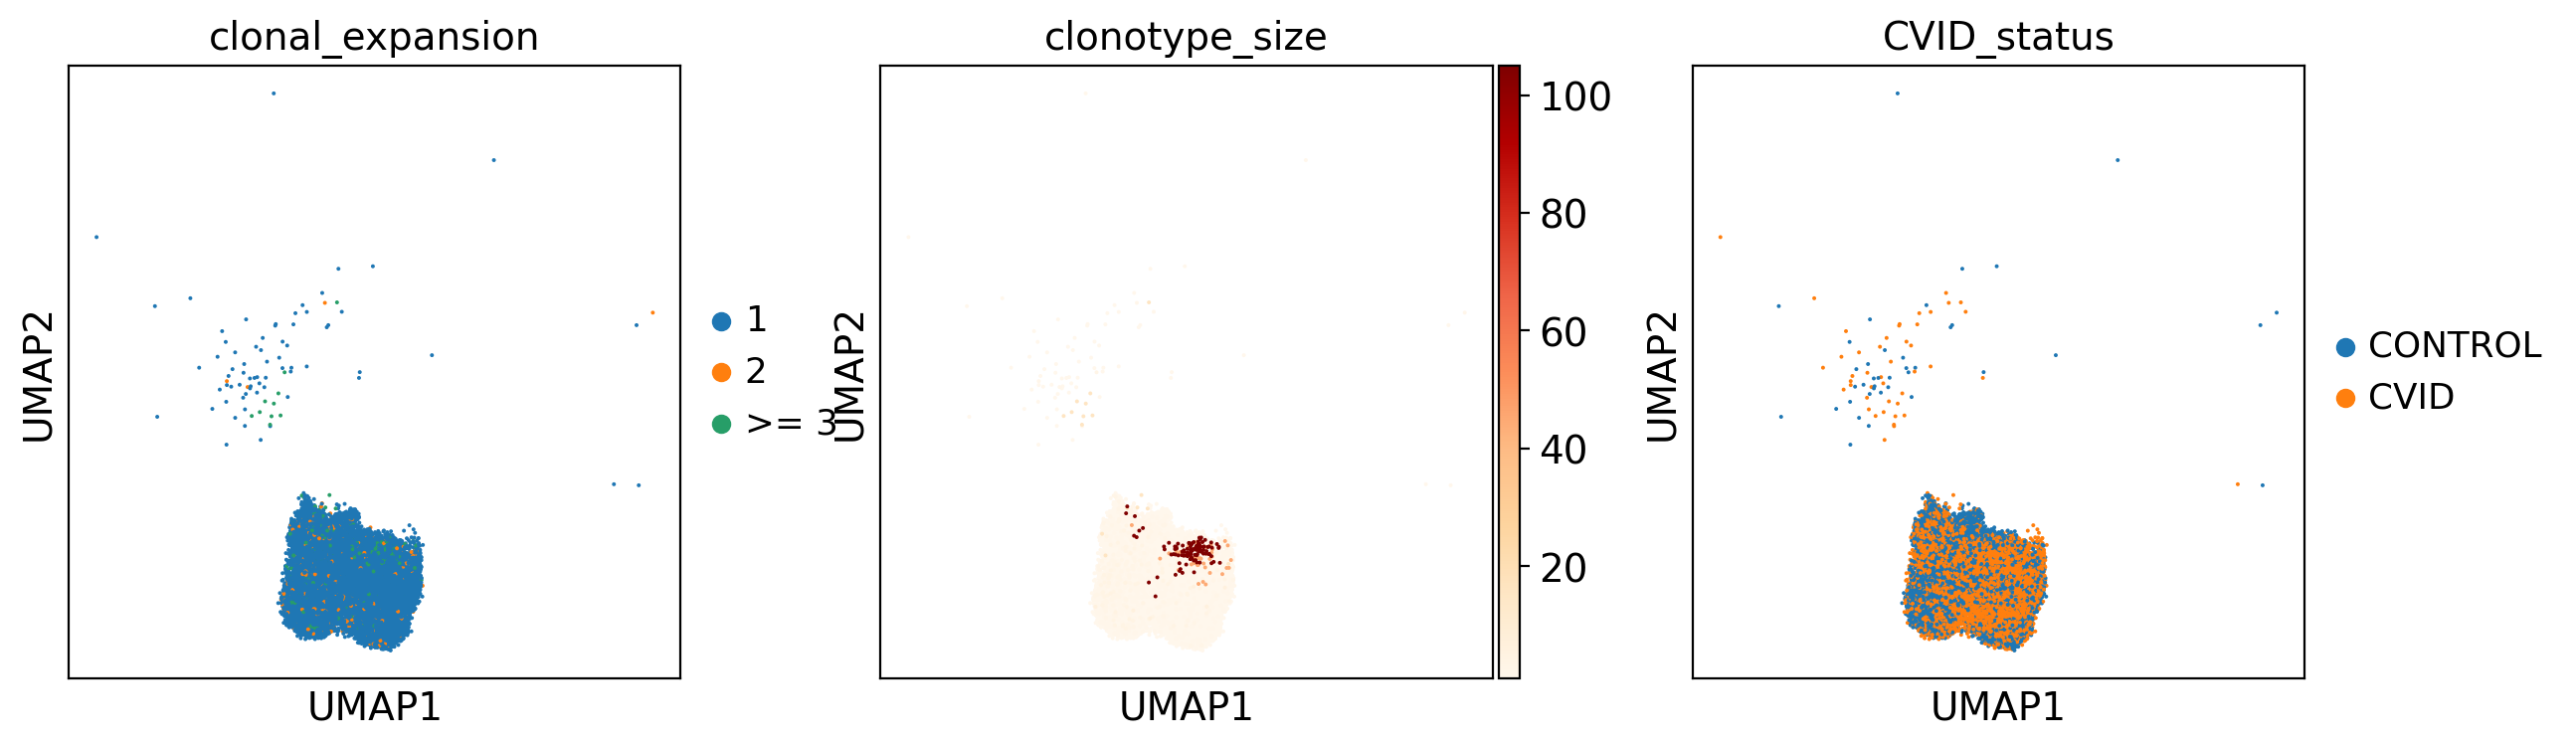

In [80]:
sc.pl.umap(adata, color=["clonal_expansion", "clonotype_size",'CVID_status'], cmap='OrRd')


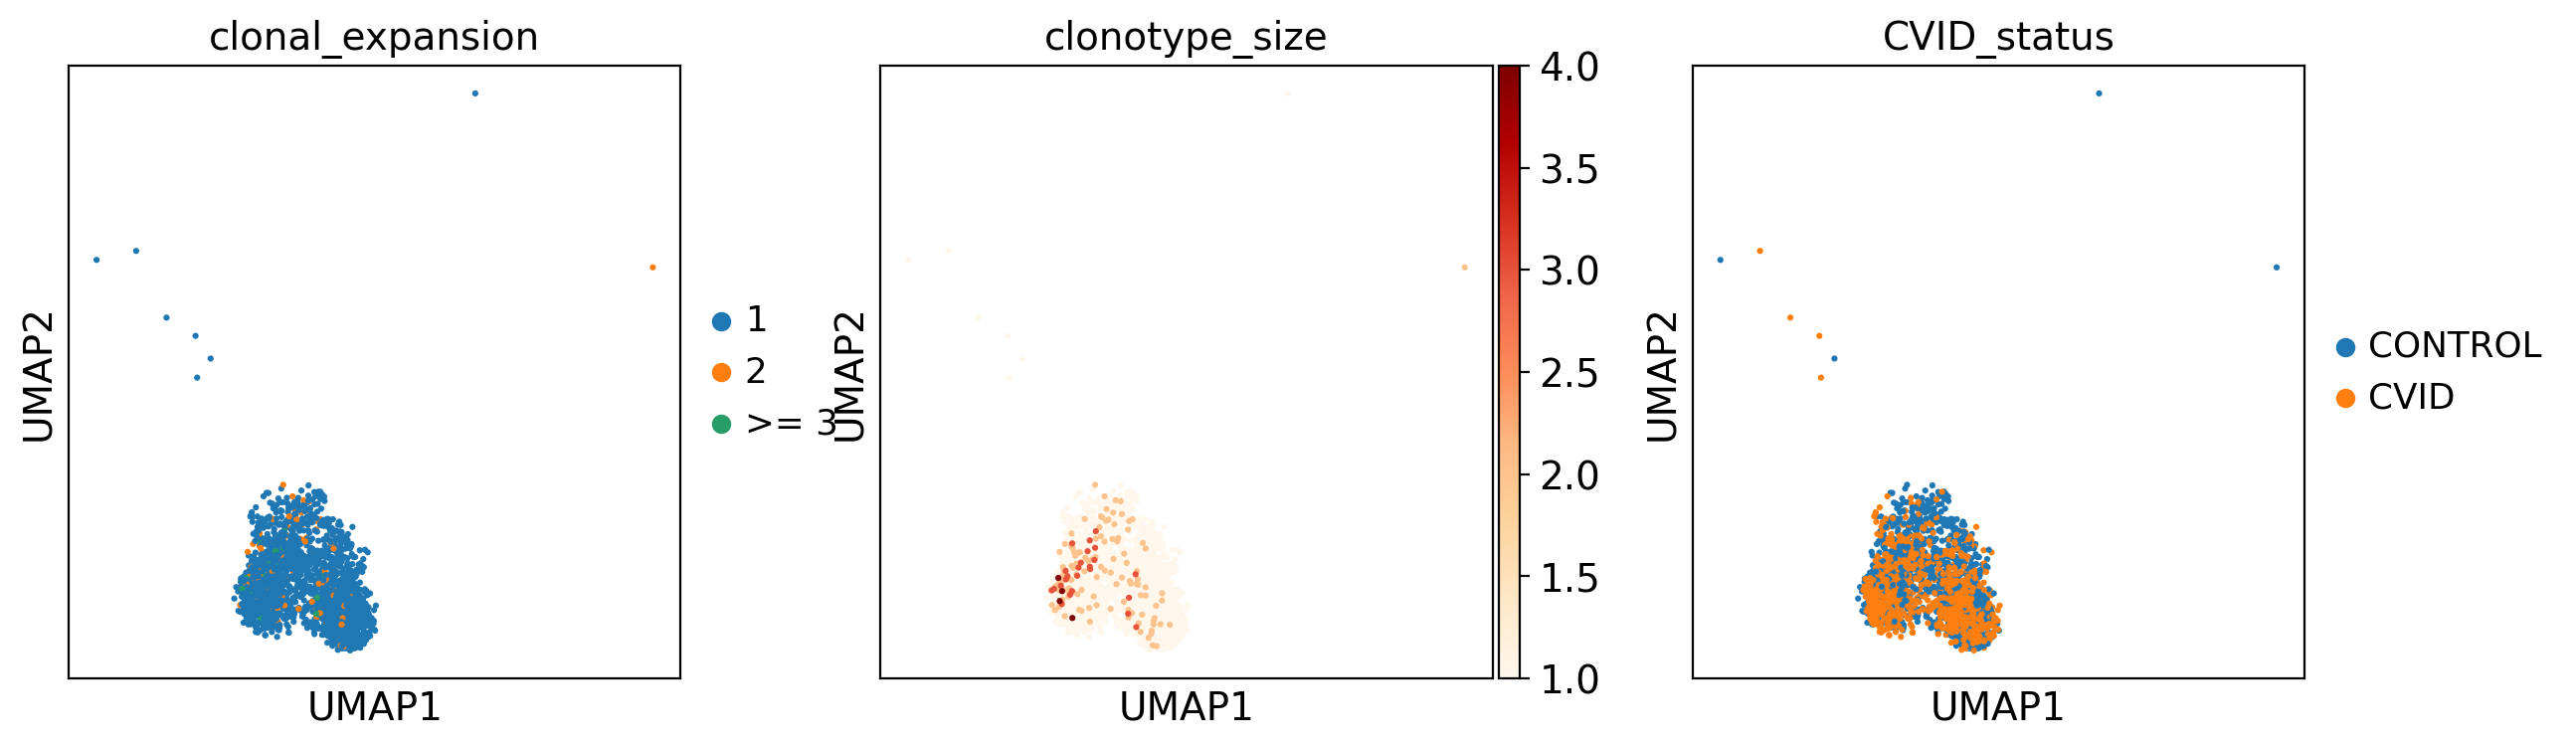

In [13]:
sc.pl.umap(adata_twins, color=["clonal_expansion", "clonotype_size",'CVID_status'], cmap='OrRd',
          size=20)


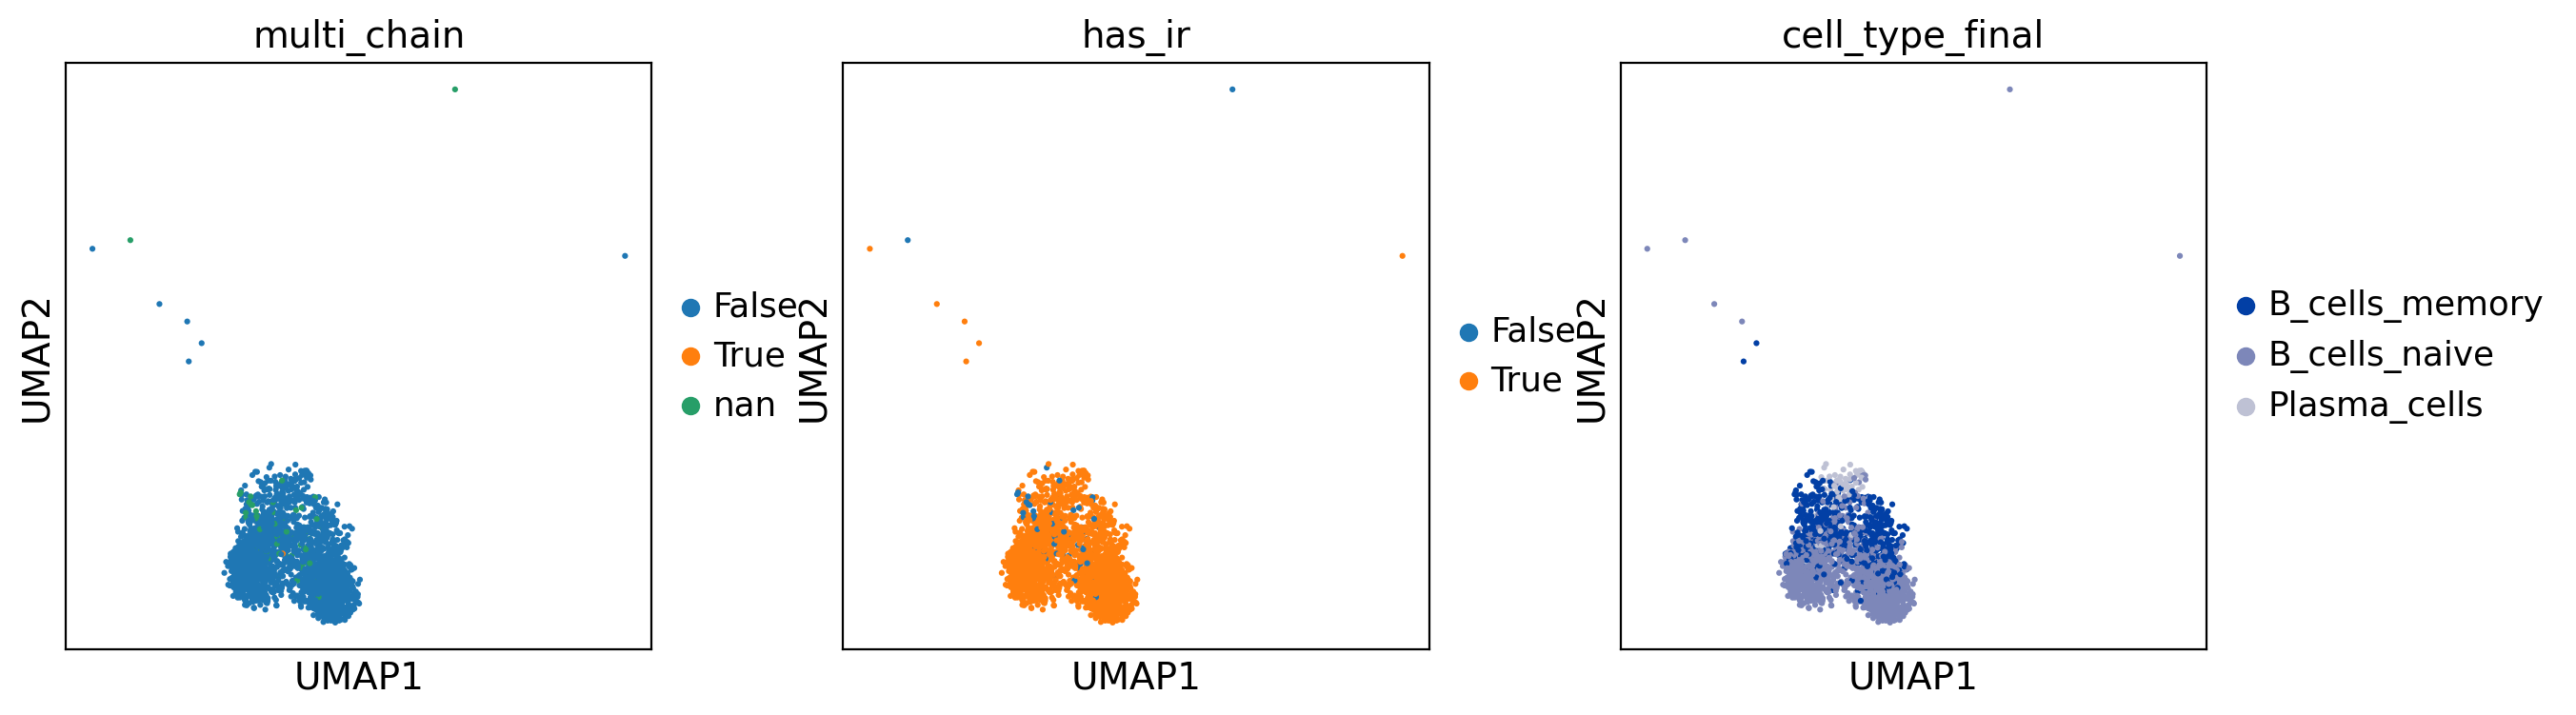

In [14]:
sc.pl.umap(adata_twins, color=["multi_chain", "has_ir",'cell_type_final'], cmap='OrRd',
          size=20)


<AxesSubplot:>

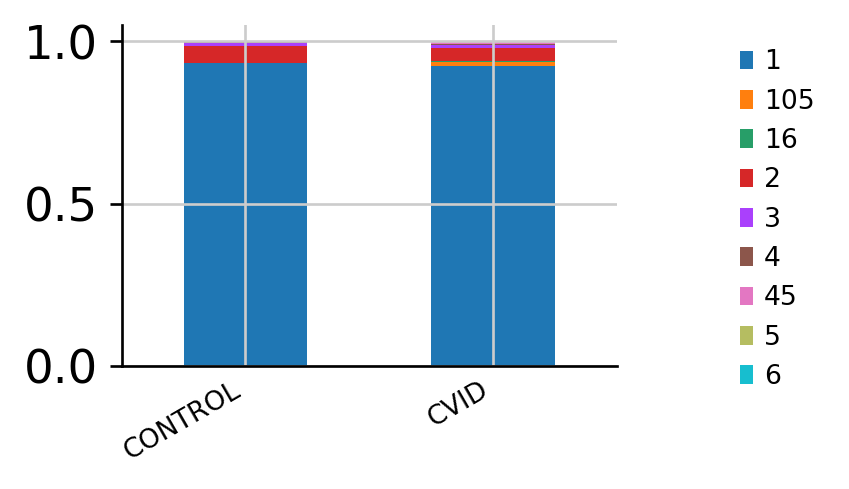

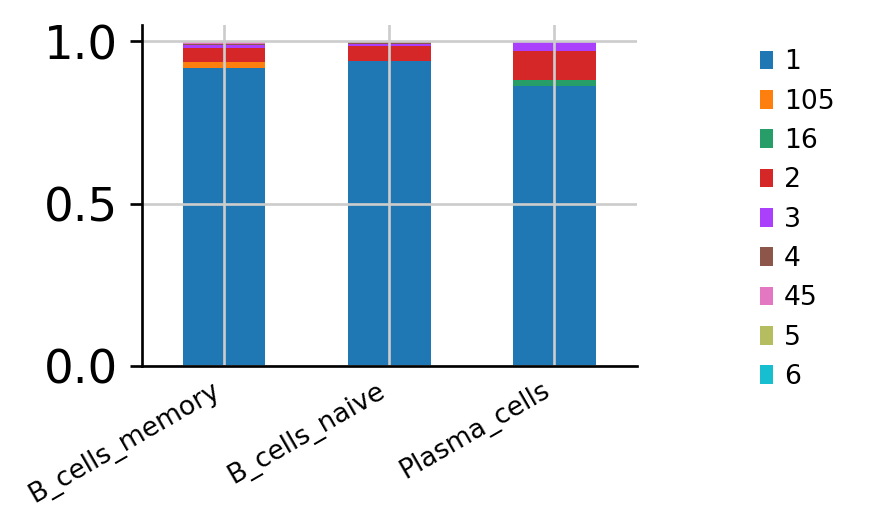

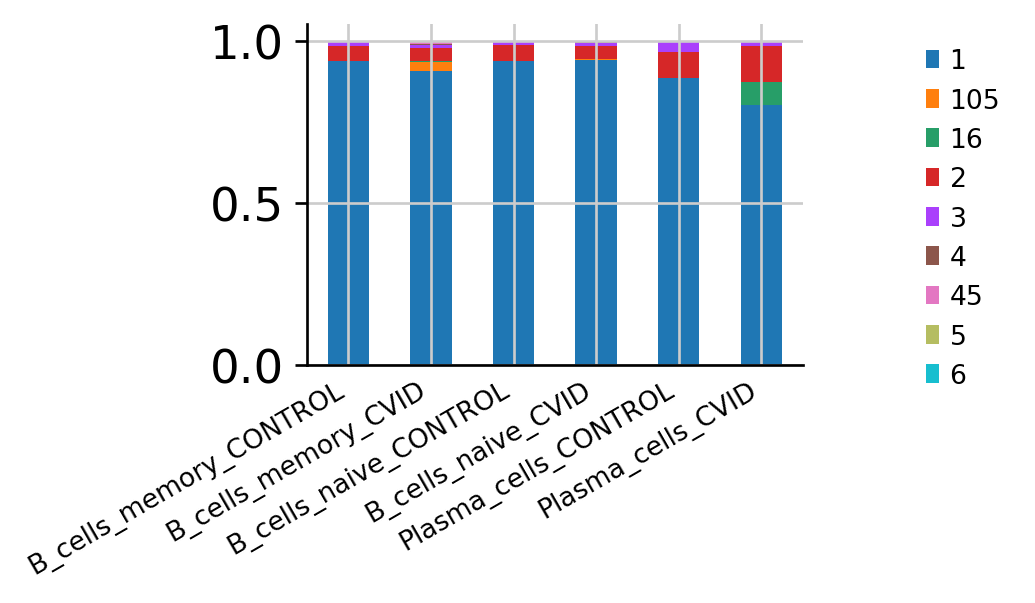

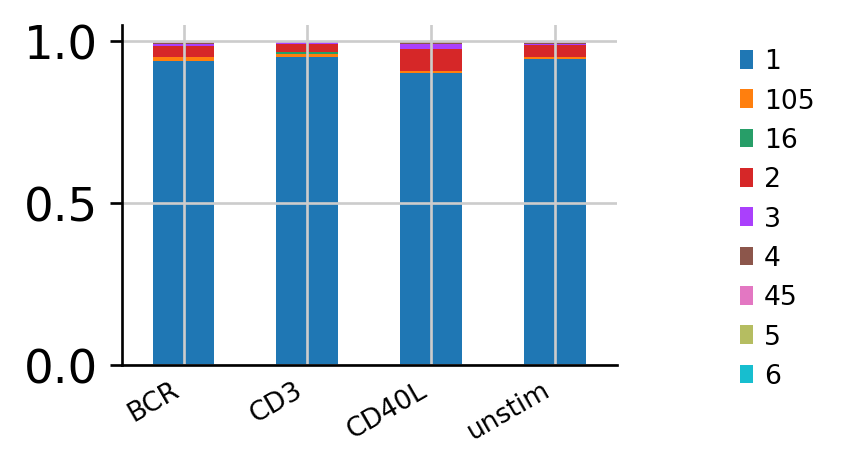

In [8]:
ir.pl.clonal_expansion(adata, groupby="CVID_status", clip_at=1000, normalize=True)
ir.pl.clonal_expansion(adata, groupby="cell_type_final", clip_at=1000, normalize=True)
ir.pl.clonal_expansion(adata, groupby="celltype_condition", clip_at=1000, normalize=True)
ir.pl.clonal_expansion(adata, groupby="stimulation", clip_at=1000, normalize=True)


In [61]:
adata.obs['stimulation_condition'] = [i + '_' + j for i,j in zip(adata.obs['stimulation'], adata.obs['CVID_status'])]

<AxesSubplot:>

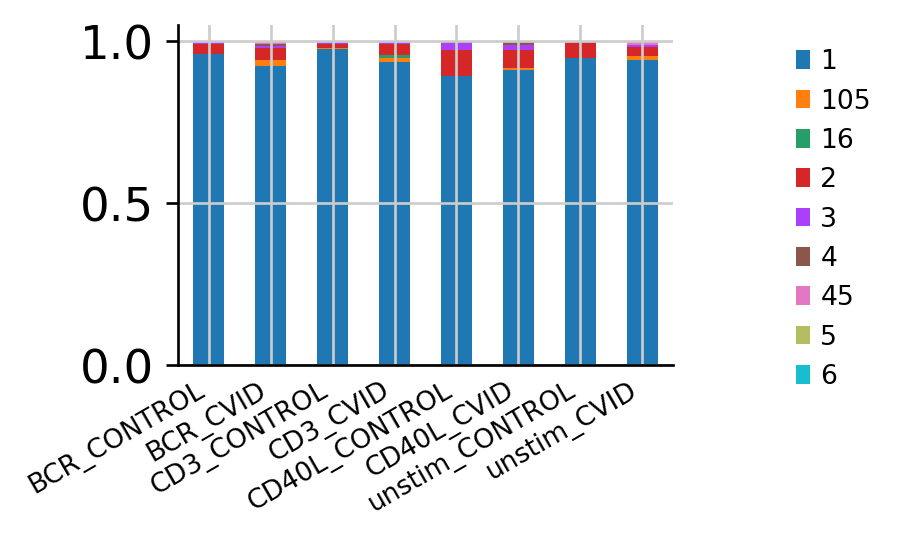

In [68]:
ir.pl.clonal_expansion(adata, groupby="stimulation_condition", clip_at=1000, normalize=True)


In [63]:
adata_twins.obs['stimulation_condition'] = [i + '_' + j for i,j in zip(adata_twins.obs['stimulation'], adata_twins.obs['CVID_status'])]

<AxesSubplot:>

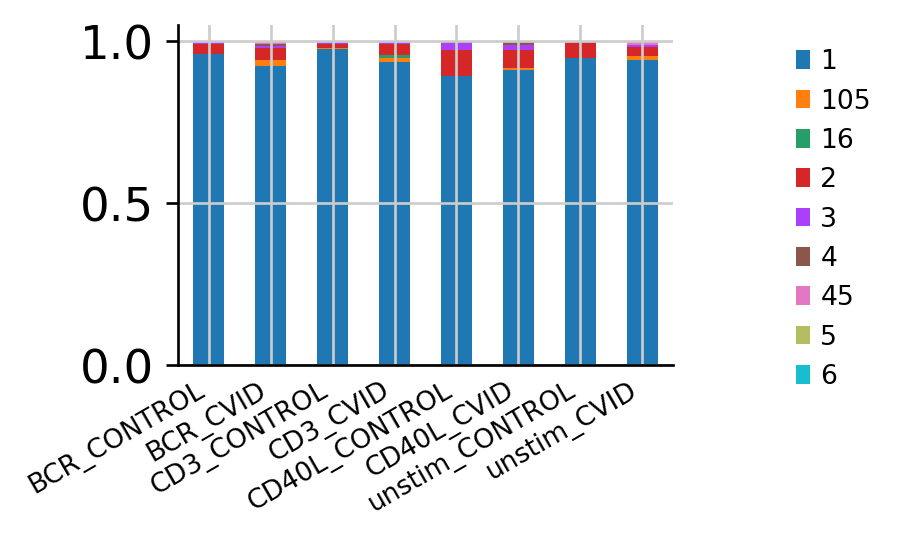

In [76]:
ir.pl.clonal_expansion(adata, groupby="stimulation_condition", clip_at=1000, normalize=True)


In [82]:
# TODO: how many clonotypes does each group contain (groups by activation and condition)
len(np.unique(adata.obs['clonotype']))

14208

In [83]:
len(np.unique(adata_twins.obs['clonotype']))

1922

<AxesSubplot:>

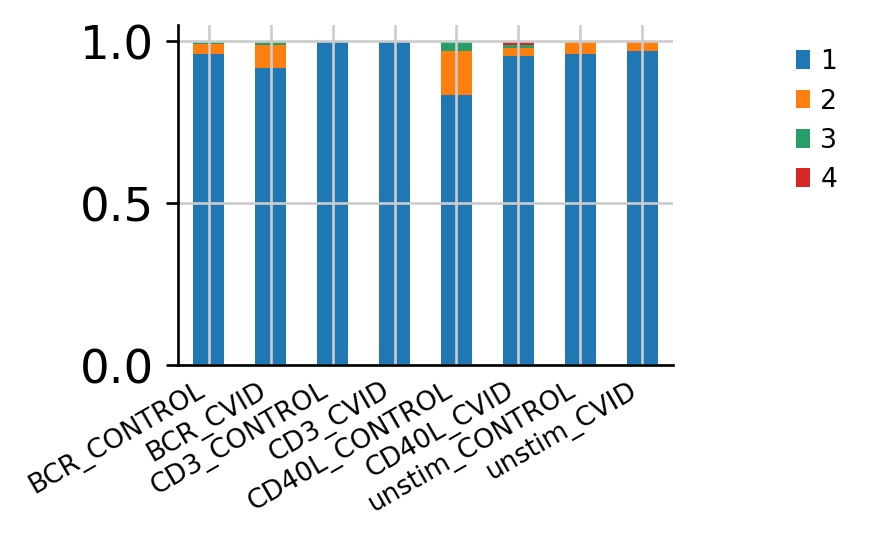

In [77]:
ir.pl.clonal_expansion(adata_twins, groupby="stimulation_condition", clip_at=1000, normalize=True)


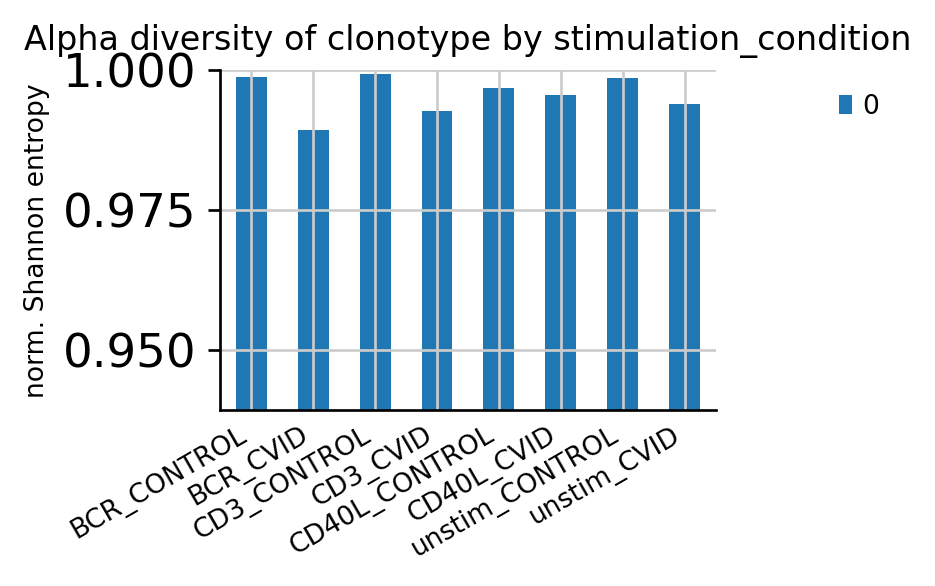

In [70]:
ax = ir.pl.alpha_diversity(adata, groupby="stimulation_condition")


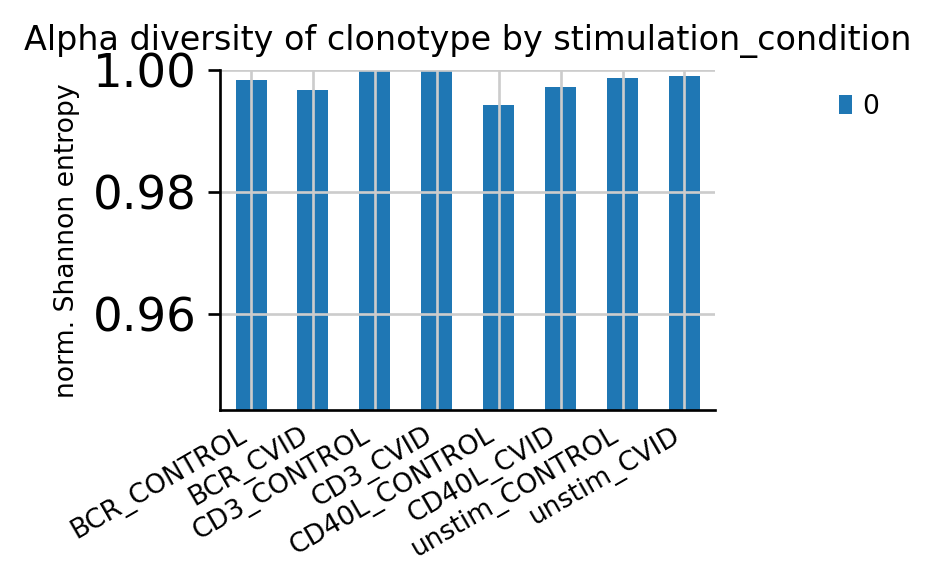

In [73]:
ax = ir.pl.alpha_diversity(adata_twins, groupby="stimulation_condition")


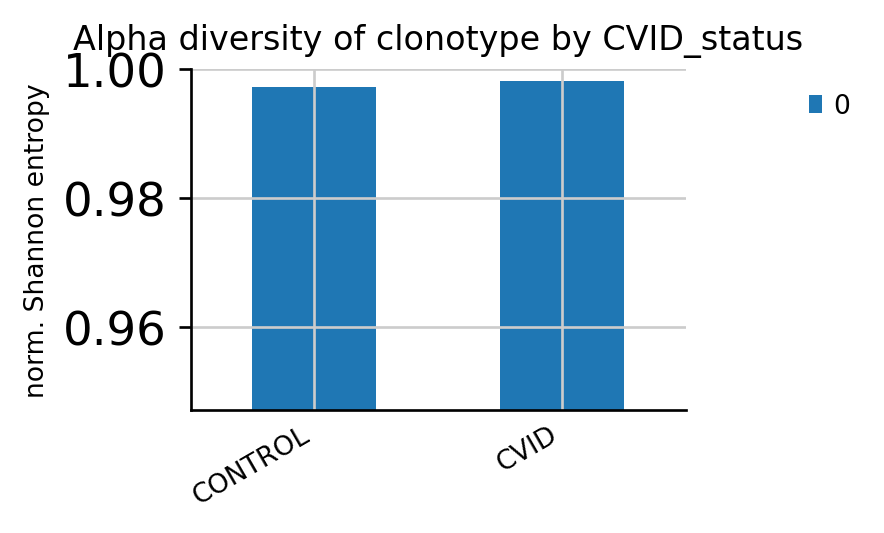

In [72]:
ax = ir.pl.alpha_diversity(adata_twins, groupby="CVID_status")


<AxesSubplot:>

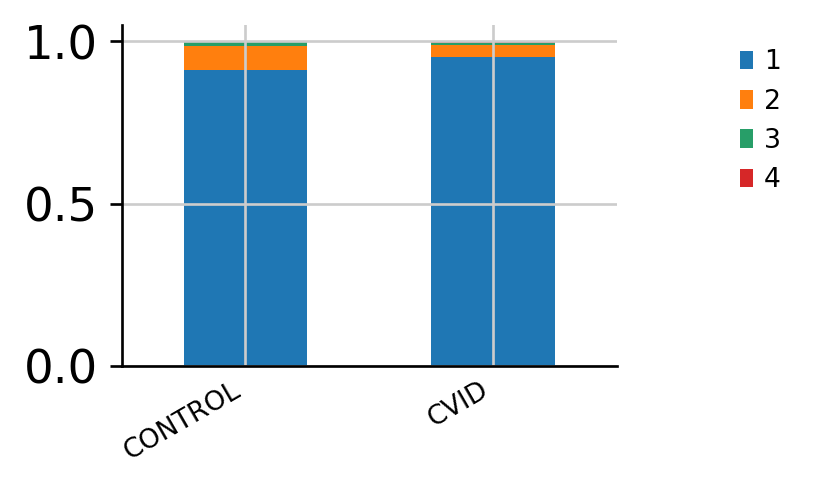

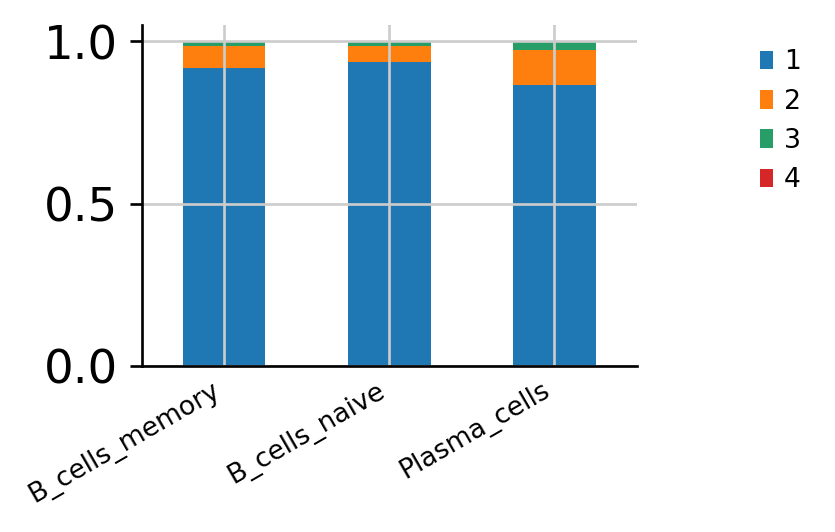

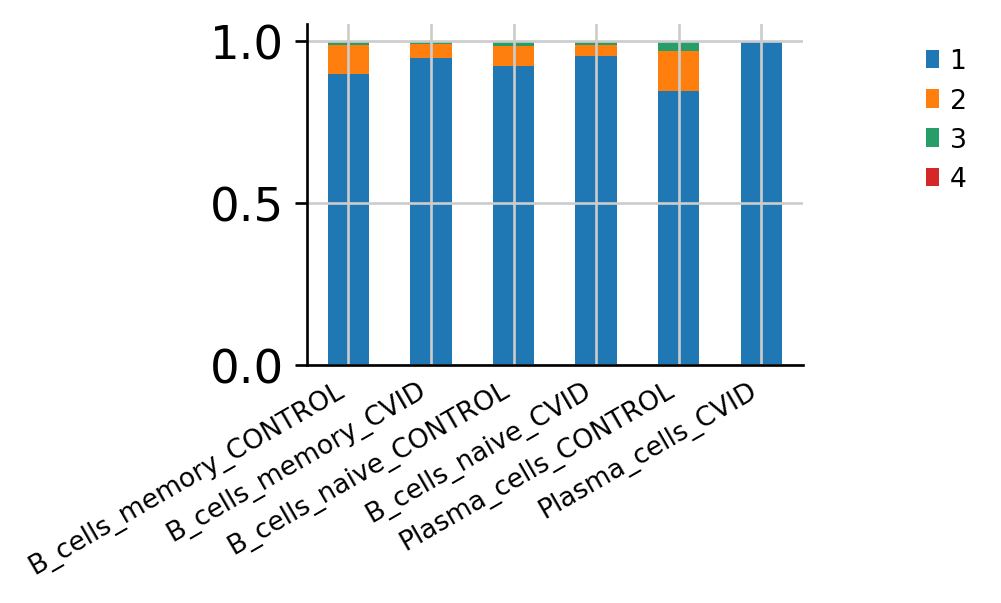

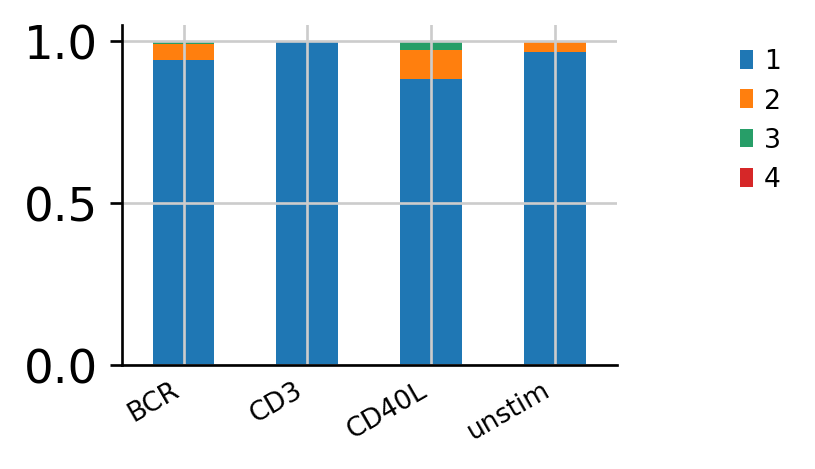

In [9]:
ir.pl.clonal_expansion(adata_twins, groupby="CVID_status", clip_at=1000, normalize=True)
ir.pl.clonal_expansion(adata_twins, groupby="cell_type_final", clip_at=1000, normalize=True)
ir.pl.clonal_expansion(adata_twins, groupby="celltype_condition", clip_at=1000, normalize=True)
ir.pl.clonal_expansion(adata_twins, groupby="stimulation", clip_at=1000, normalize=True)


In [11]:
adata.obs['clonal_expansion']

AAACCTGCAGATGGGT-1    1
AAACCTGGTAGCGATG-1    1
AAACCTGGTTAGATGA-1    1
AAACGGGAGGATTCGG-1    1
AAACGGGGTGCGCTTG-1    1
                     ..
TTTGGTTAGGTAAACT-1    1
TTTGGTTTCTACCTGC-1    1
TTTGTCAAGAAACCTA-1    1
TTTGTCACACAGCGTC-1    1
TTTGTCAGTAGTACCT-1    1
Name: clonal_expansion, Length: 14862, dtype: category
Categories (3, object): [1, 2, >= 3]

In [ ]:
adata.write(save_path + '20210113_adata_final_all_donors_with_BCR_information.h5ad')

In [ ]:
adata_twins.write(save_path + '20210113_adata_final_twins_only_with_BCR_information.h5ad')

# 2. Read in objects with all the results

In [5]:
adata = sc.read(save_path + '20210113_adata_final_all_donors_with_BCR_information.h5ad')

In [9]:
adata.obs['clonotype']

AAACCTGCAGATGGGT-1        0_BCR
AAACCTGGTAGCGATG-1        1_BCR
AAACCTGGTTAGATGA-1        2_BCR
AAACGGGAGGATTCGG-1        3_BCR
AAACGGGGTGCGCTTG-1        4_BCR
                        ...    
TTTGGTTAGGTAAACT-1    14198_BCR
TTTGGTTTCTACCTGC-1    14199_BCR
TTTGTCAAGAAACCTA-1    14200_BCR
TTTGTCACACAGCGTC-1    14201_BCR
TTTGTCAGTAGTACCT-1    14202_BCR
Name: clonotype, Length: 14862, dtype: category
Categories (14208, object): [0_BCR, 1_BCR, 2_BCR, 3_BCR, ..., 14199_BCR, 14200_BCR, 14201_BCR, 14202_BCR]

In [6]:
adata_twins = sc.read(save_path + '20210113_adata_final_twins_only_with_BCR_information.h5ad')

In [10]:
# which cells are in the expanded clonotypes (size >= 2)?
adata.obs['expanded_or_not_2_or_more'] = ['True' if value != '1' else 'False' for value in adata.obs['clonal_expansion']]
# which cells are in the expanded clonotypes (size >= 3)?
adata.obs['expanded_or_not_3_or_more'] = ['True' if value not in ['1','2'] else 'False' for value in adata.obs['clonal_expansion']]

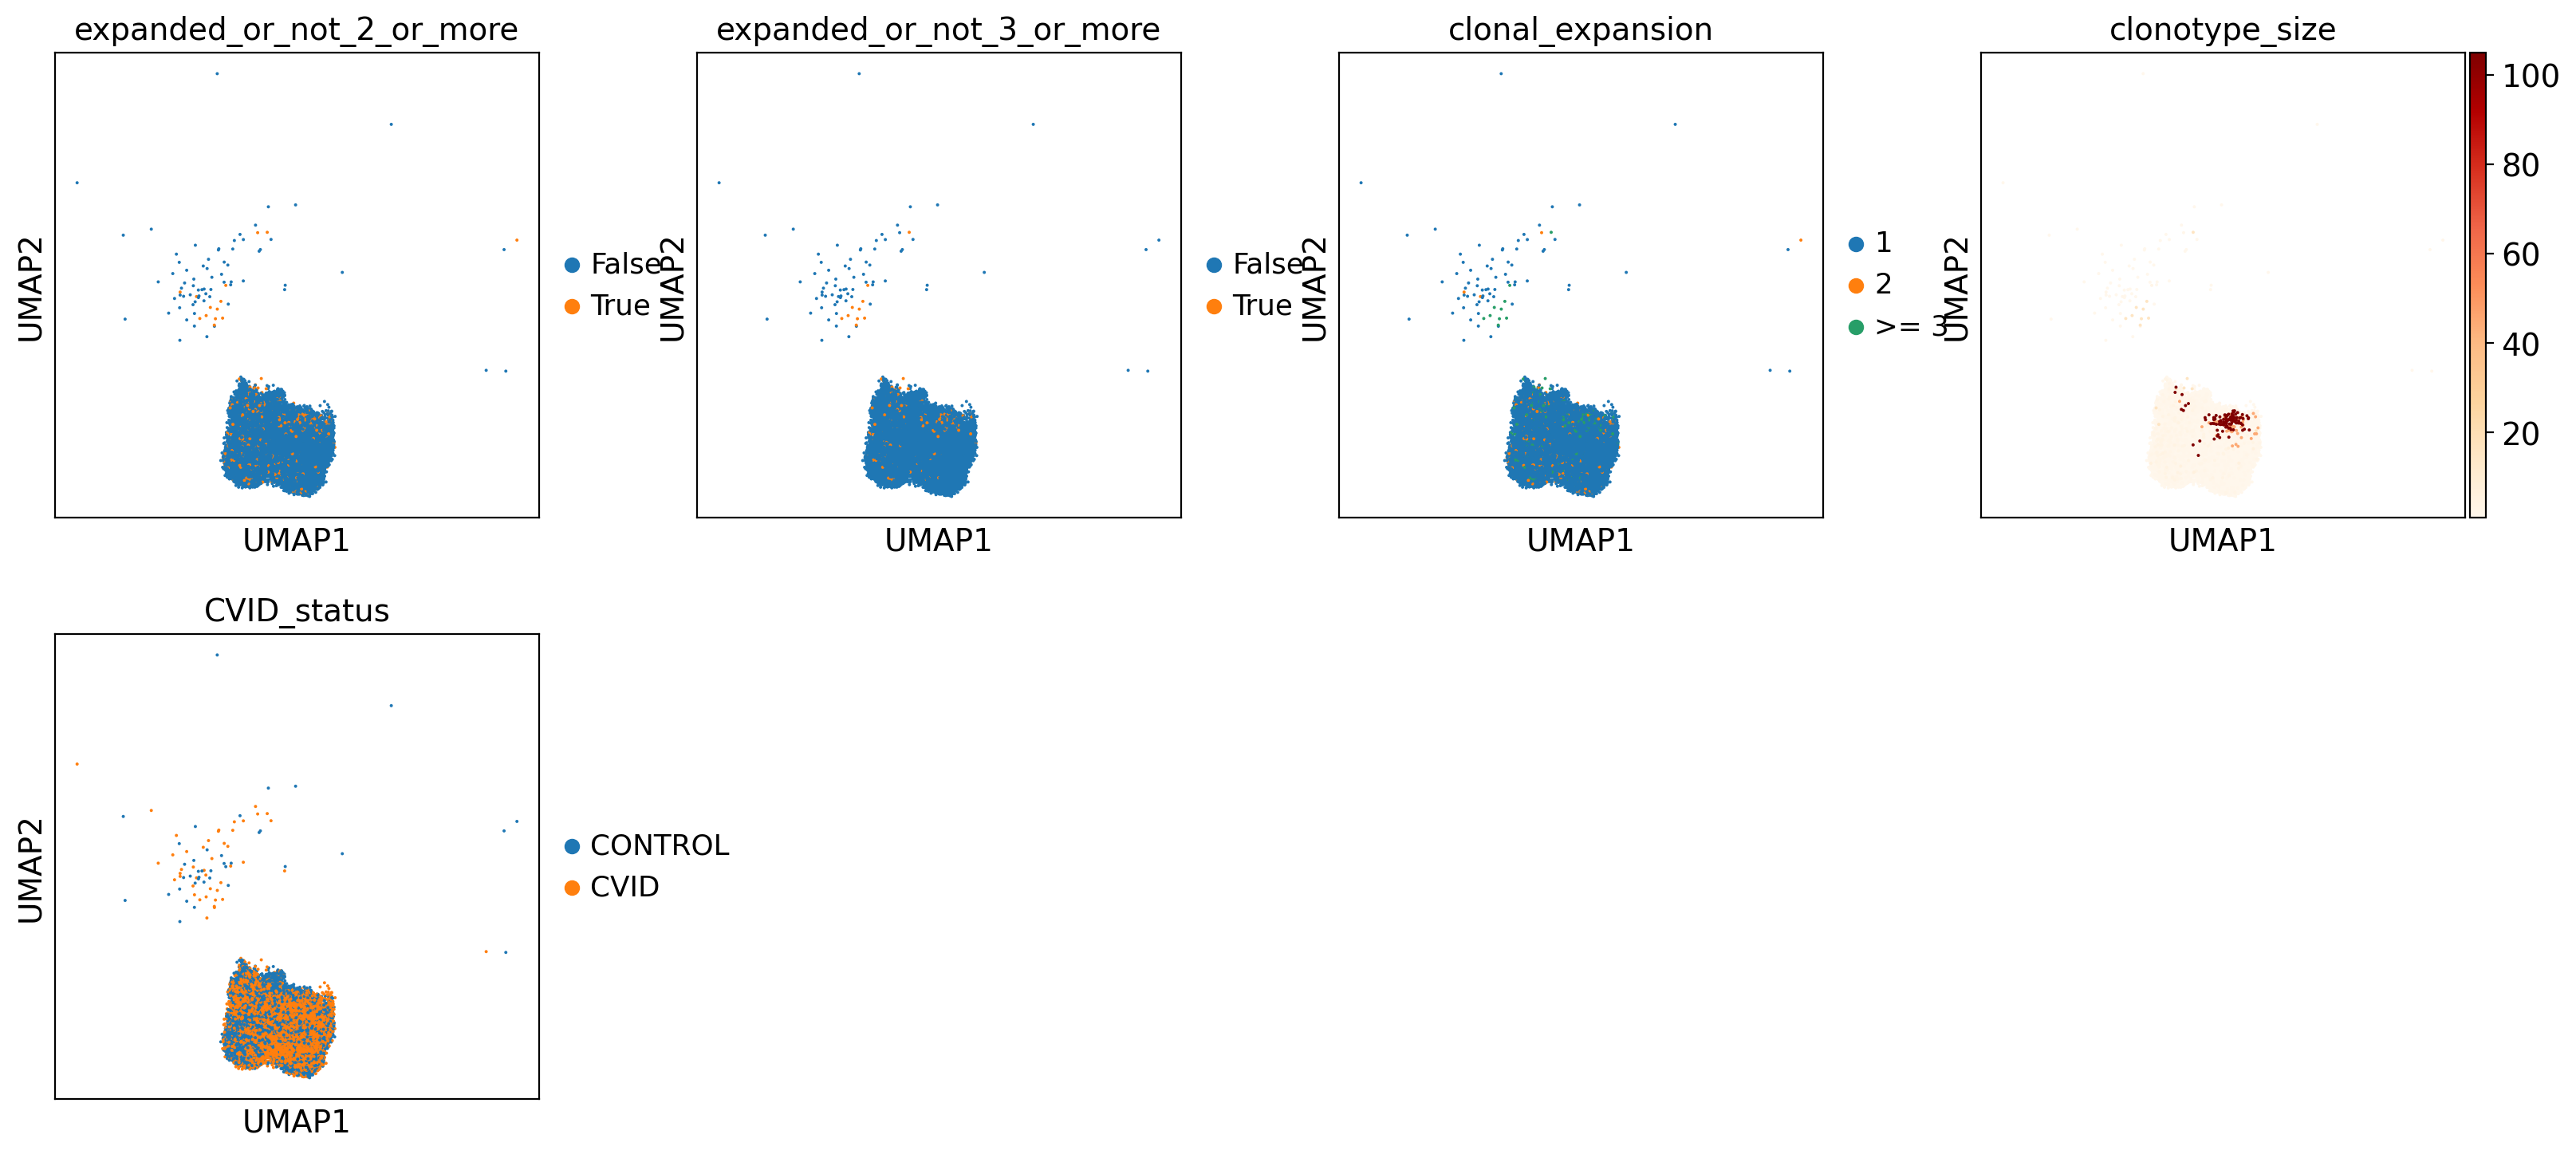

In [35]:
sc.pl.umap(adata, color=["expanded_or_not_2_or_more",
                         'expanded_or_not_3_or_more',
                         "clonal_expansion", "clonotype_size", 'CVID_status'], cmap='OrRd')


In [19]:
# which cells are in the expanded clonotypes (size >= 2)?
adata_twins.obs['expanded_or_not_2_or_more'] = ['True' if value != '1' else 'False' for value in adata_twins.obs['clonal_expansion']]
# which cells are in the expanded clonotypes (size >= 3)?
adata_twins.obs['expanded_or_not_3_or_more'] = ['True' if value not in ['1','2'] else 'False' for value in adata_twins.obs['clonal_expansion']]

... storing 'expanded_or_not' as categorical
... storing 'expanded_or_not_2_or_more' as categorical
... storing 'expanded_or_not_3_or_more' as categorical


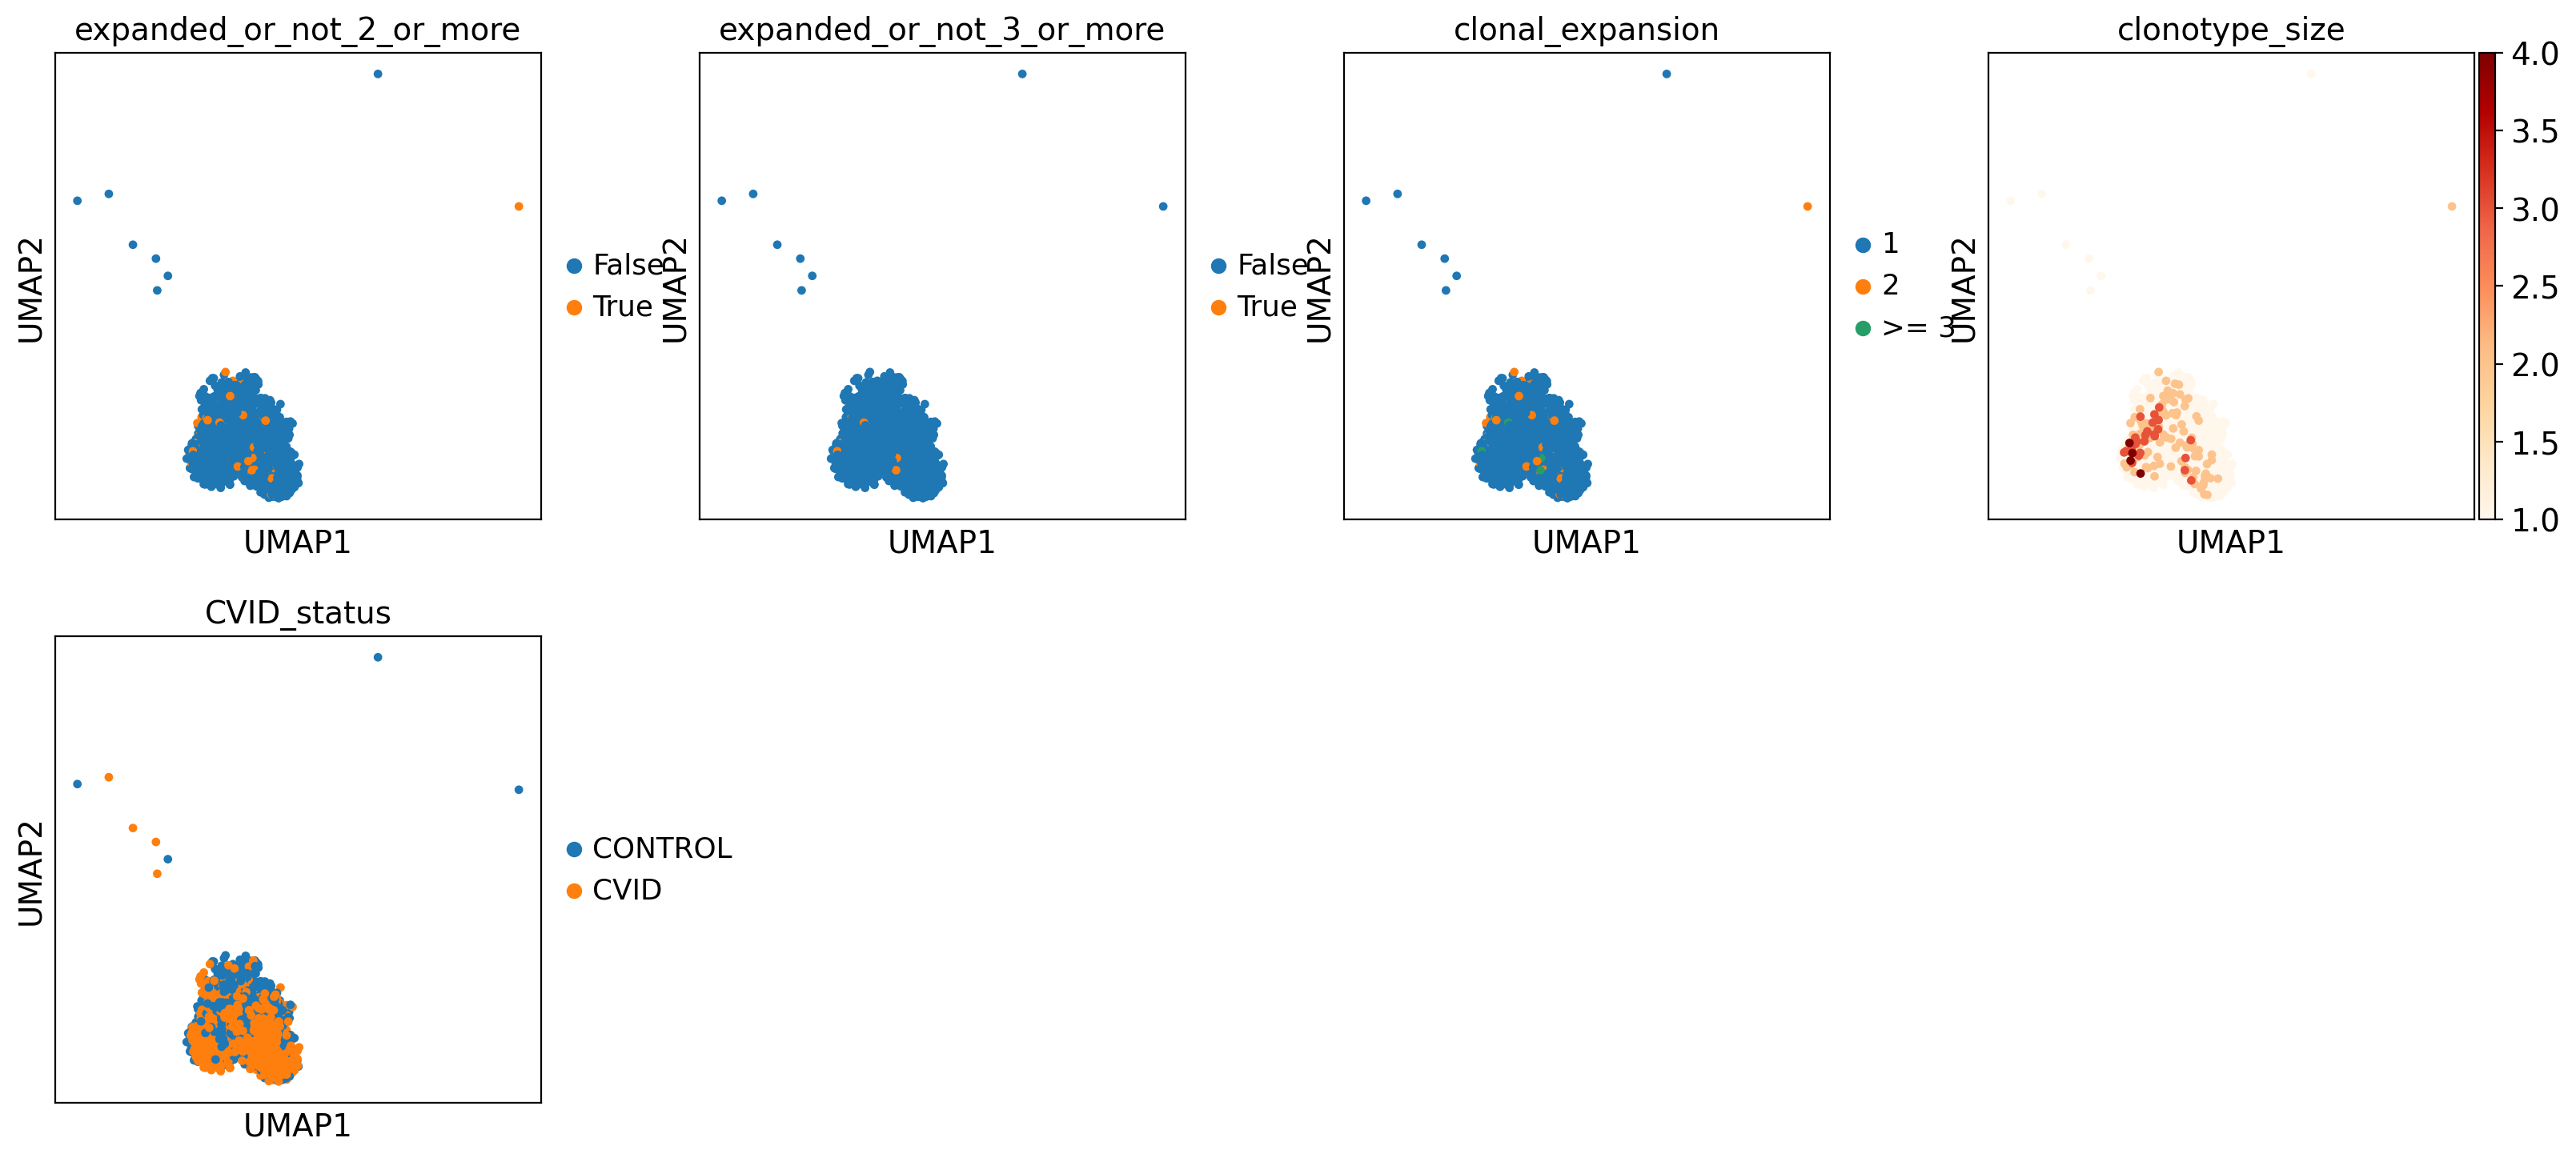

In [37]:
sc.pl.umap(adata_twins, color=["expanded_or_not_2_or_more",
                         'expanded_or_not_3_or_more',
                         "clonal_expansion", "clonotype_size", 'CVID_status'], cmap='OrRd')


In [50]:
adata_without_donor_CVID3 = adata[adata.obs['donor'] != 'CVID3'].copy()

In [51]:
adata_without_donor_CVID3[adata_without_donor_CVID3.obs['CVID_status'] == 'CONTROL'].obs['expanded_or_not_2_or_more'].value_counts()

/opt/conda/lib/python3.7/site-packages/anndata/compat/__init__.py:215: FutureWarning: During AnnData slicing, found matrix at .uns['ir_neighbors_aa_alignment']['connectivities'] that happens to be dimensioned at n_obs×n_obs (13987×13987).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/anndata/compat/__init__.py:215: FutureWarning: During AnnData slicing, found matrix at .uns['ir_neighbors_aa_alignment']['distances'] that happens to be dimensioned at n_obs×n_obs (13987×13987).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/anndata/compat/__init__.py:215: FutureWarning: During AnnData slicing, found matrix at .uns['ir_neighbors_nt_identity']['connectivities'] that happens to be dimensioned at n_obs×n_obs (13987×13987).

These matrices should no

False    5902
True      421
Name: expanded_or_not_2_or_more, dtype: int64

In [54]:
421/(421 + 5902)

0.06658231851969001

In [53]:
adata_without_donor_CVID3[adata_without_donor_CVID3.obs['CVID_status'] == 'CVID'].obs['expanded_or_not_2_or_more'].value_counts()

False    7132
True      532
Name: expanded_or_not_2_or_more, dtype: int64

In [55]:
532/(532+7132)

0.06941544885177453

In [56]:
adata_without_donor_CVID3[adata_without_donor_CVID3.obs['CVID_status'] == 'CONTROL'].obs['expanded_or_not_3_or_more'].value_counts()

False    6223
True      100
Name: expanded_or_not_3_or_more, dtype: int64

In [58]:
100 / (100 + 6223)

0.015815277558121146

In [59]:
adata_without_donor_CVID3[adata_without_donor_CVID3.obs['CVID_status'] == 'CVID'].obs['expanded_or_not_3_or_more'].value_counts()

False    7384
True      280
Name: expanded_or_not_3_or_more, dtype: int64

In [60]:
280 / (280 + 7384)

0.03653444676409186

In [38]:
adata[adata.obs['CVID_status'] == 'CONTROL'].obs['expanded_or_not_2_or_more'].value_counts()

/opt/conda/lib/python3.7/site-packages/anndata/compat/__init__.py:215: FutureWarning: During AnnData slicing, found matrix at .uns['ir_neighbors_aa_alignment']['connectivities'] that happens to be dimensioned at n_obs×n_obs (14862×14862).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/anndata/compat/__init__.py:215: FutureWarning: During AnnData slicing, found matrix at .uns['ir_neighbors_aa_alignment']['distances'] that happens to be dimensioned at n_obs×n_obs (14862×14862).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/anndata/compat/__init__.py:215: FutureWarning: During AnnData slicing, found matrix at .uns['ir_neighbors_nt_identity']['connectivities'] that happens to be dimensioned at n_obs×n_obs (14862×14862).

These matrices should no

False    5902
True      421
Name: expanded_or_not_2_or_more, dtype: int64

In [27]:
421 / (421 + 5902)

0.06658231851969001

In [39]:
adata[adata.obs['CVID_status'] == 'CVID'].obs['expanded_or_not_2_or_more'].value_counts()

False    7900
True      639
Name: expanded_or_not_2_or_more, dtype: int64

In [28]:
639 / (639 + 7900)

0.07483311863215833

In [40]:
adata_twins[adata_twins.obs['CVID_status'] == 'CONTROL'].obs['expanded_or_not_2_or_more'].value_counts()

/opt/conda/lib/python3.7/site-packages/anndata/compat/__init__.py:215: FutureWarning: During AnnData slicing, found matrix at .uns['ir_neighbors_aa_alignment']['connectivities'] that happens to be dimensioned at n_obs×n_obs (1999×1999).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/anndata/compat/__init__.py:215: FutureWarning: During AnnData slicing, found matrix at .uns['ir_neighbors_aa_alignment']['distances'] that happens to be dimensioned at n_obs×n_obs (1999×1999).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/anndata/compat/__init__.py:215: FutureWarning: During AnnData slicing, found matrix at .uns['ir_neighbors_nt_identity']['connectivities'] that happens to be dimensioned at n_obs×n_obs (1999×1999).

These matrices should now be s

False    1052
True      103
Name: expanded_or_not_2_or_more, dtype: int64

In [29]:
103 / (103 + 1052)

0.08917748917748917

In [41]:
adata_twins[adata_twins.obs['CVID_status'] == 'CVID'].obs['expanded_or_not_2_or_more'].value_counts()

False    803
True      41
Name: expanded_or_not_2_or_more, dtype: int64

In [30]:
41 / (41 + 803)

0.0485781990521327

In [42]:
adata[adata.obs['CVID_status'] == 'CONTROL'].obs['expanded_or_not_3_or_more'].value_counts()

False    6223
True      100
Name: expanded_or_not_3_or_more, dtype: int64

In [46]:
100 / (100 + 6223)

0.015815277558121146

In [43]:
adata[adata.obs['CVID_status'] == 'CVID'].obs['expanded_or_not_3_or_more'].value_counts()

False    8253
True      286
Name: expanded_or_not_3_or_more, dtype: int64

In [47]:
286 / (286 + 8253)

0.033493383300152245

In [44]:
adata_twins[adata_twins.obs['CVID_status'] == 'CONTROL'].obs['expanded_or_not_3_or_more'].value_counts()

False    1137
True       18
Name: expanded_or_not_3_or_more, dtype: int64

In [48]:
18 / (18 + 1137)

0.015584415584415584

In [45]:
adata_twins[adata_twins.obs['CVID_status'] == 'CVID'].obs['expanded_or_not_3_or_more'].value_counts()

False    834
True      10
Name: expanded_or_not_3_or_more, dtype: int64

In [49]:
10 / (10 + 834)

0.011848341232227487

In [16]:
# another metric that we could compare: the number of expanded clonotypes
len(np.unique(adata[(adata.obs['expanded_or_not_2_or_more'] == 'True')
                   & (adata.obs['CVID_status'] == 'CVID')].obs['clonotype']))

/opt/conda/lib/python3.7/site-packages/anndata/compat/__init__.py:215: FutureWarning: During AnnData slicing, found matrix at .uns['ir_neighbors_aa_alignment']['connectivities'] that happens to be dimensioned at n_obs×n_obs (14862×14862).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/anndata/compat/__init__.py:215: FutureWarning: During AnnData slicing, found matrix at .uns['ir_neighbors_aa_alignment']['distances'] that happens to be dimensioned at n_obs×n_obs (14862×14862).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/anndata/compat/__init__.py:215: FutureWarning: During AnnData slicing, found matrix at .uns['ir_neighbors_nt_identity']['connectivities'] that happens to be dimensioned at n_obs×n_obs (14862×14862).

These matrices should no

228

In [17]:
# another metric that we could compare: the number of expanded clonotypes
len(np.unique(adata[(adata.obs['expanded_or_not_2_or_more'] == 'True')
                   & (adata.obs['CVID_status'] == 'CONTROL')].obs['clonotype']))

208

In [20]:
# another metric that we could compare: the number of expanded clonotypes
len(np.unique(adata_twins[(adata_twins.obs['expanded_or_not_2_or_more'] == 'True')
                   & (adata_twins.obs['CVID_status'] == 'CVID')].obs['clonotype']))

/opt/conda/lib/python3.7/site-packages/anndata/compat/__init__.py:215: FutureWarning: During AnnData slicing, found matrix at .uns['ir_neighbors_aa_alignment']['connectivities'] that happens to be dimensioned at n_obs×n_obs (1999×1999).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/anndata/compat/__init__.py:215: FutureWarning: During AnnData slicing, found matrix at .uns['ir_neighbors_aa_alignment']['distances'] that happens to be dimensioned at n_obs×n_obs (1999×1999).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/anndata/compat/__init__.py:215: FutureWarning: During AnnData slicing, found matrix at .uns['ir_neighbors_nt_identity']['connectivities'] that happens to be dimensioned at n_obs×n_obs (1999×1999).

These matrices should now be s

19

In [22]:
# another metric that we could compare: the number of expanded clonotypes
len(np.unique(adata_twins[(adata_twins.obs['expanded_or_not_2_or_more'] == 'True')
                   & (adata_twins.obs['CVID_status'] == 'CONTROL')].obs['clonotype']))

49

## Clonotype abundance


In [87]:
adata.obs['donor']

AAACCTGCAGATGGGT-1        CONTROL4
AAACCTGGTAGCGATG-1    CONTROL_twin
AAACCTGGTTAGATGA-1        CONTROL4
AAACGGGAGGATTCGG-1           CVID3
AAACGGGGTGCGCTTG-1           CVID3
                          ...     
TTTGGTTAGGTAAACT-1        CONTROL8
TTTGGTTTCTACCTGC-1          CVID36
TTTGTCAAGAAACCTA-1        CONTROL7
TTTGTCACACAGCGTC-1          CVID37
TTTGTCAGTAGTACCT-1        CONTROL7
Name: donor, Length: 18069, dtype: category
Categories (21, object): ['CONTROL1', 'CONTROL2', 'CONTROL3', 'CONTROL4', ..., 'CVID34', 'CVID36', 'CVID37', 'CVID_twin']

<AxesSubplot:title={'center':'Number of cells in CVID_status by donor'}, xlabel='CVID_status', ylabel='Number of cells'>

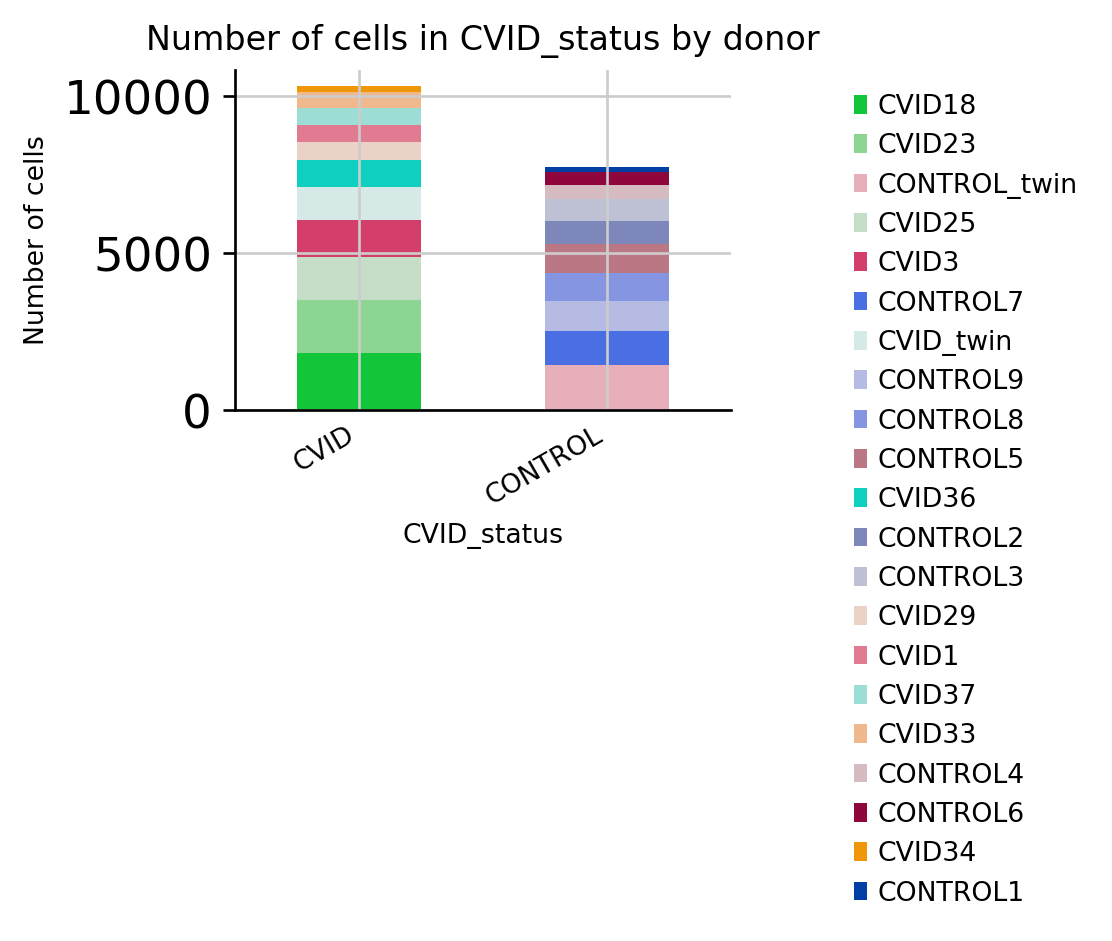

In [91]:
ir.pl.group_abundance(adata, groupby="CVID_status", target_col="donor", max_cols=20)


<AxesSubplot:title={'center':'Fraction of CVID_status in each clonotype'}, xlabel='clonotype', ylabel='Fraction of cells in sample'>

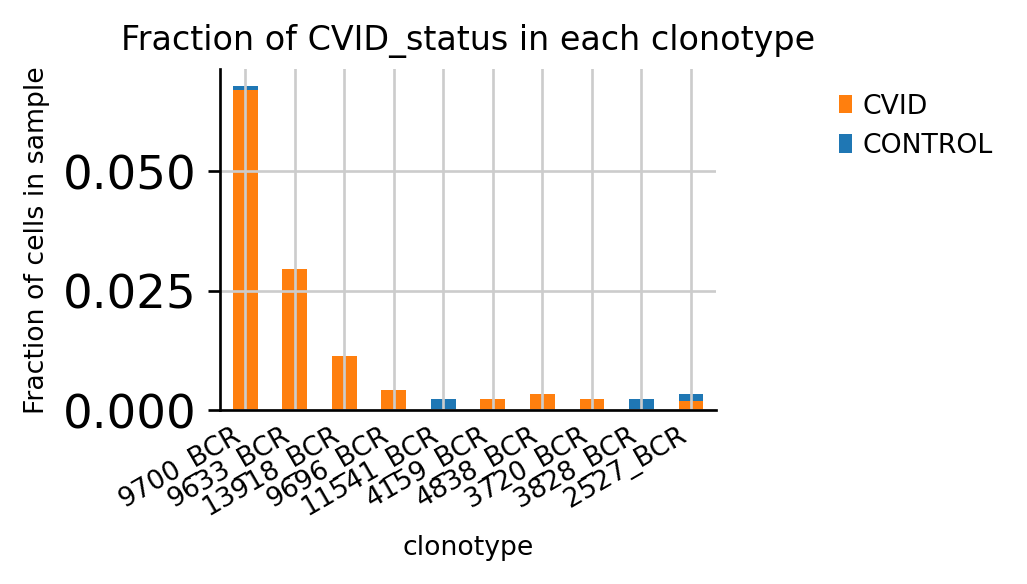

In [92]:
ir.pl.group_abundance(
    adata, groupby="clonotype", target_col="CVID_status", max_cols=10, normalize="sample"
)

# Gene usage


<AxesSubplot:title={'center':'Fraction of CVID_status in each IR_VJ_1_v_gene'}, xlabel='IR_VJ_1_v_gene', ylabel='Fraction of cells in CVID_status'>

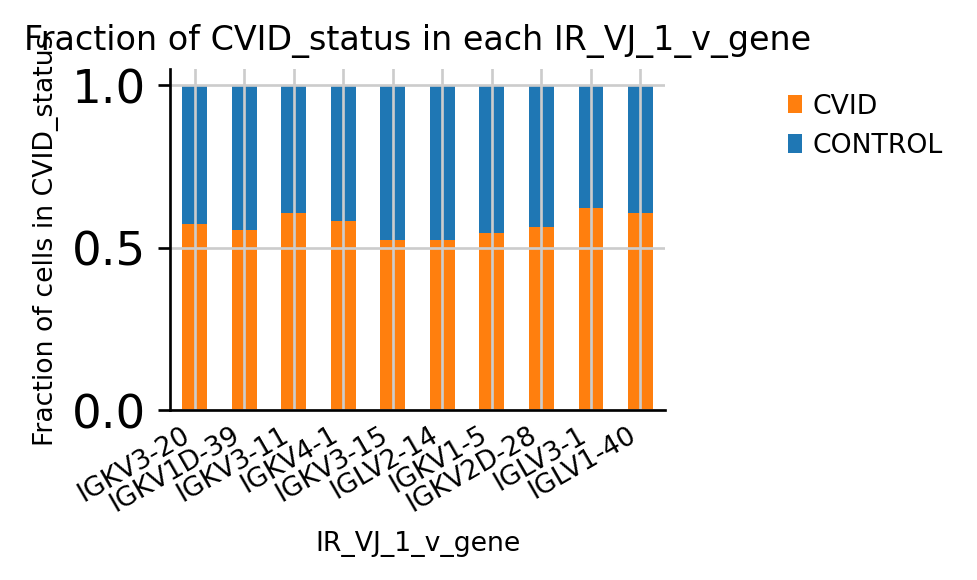

In [95]:
ir.pl.group_abundance(
    adata, groupby="IR_VJ_1_v_gene", target_col="CVID_status", normalize=True, max_cols=10
)

In [97]:
ir.pl.group_abundance(
    adata[
        adata.obs["IR_VDJ_1_v_gene"].isin(
            ["TRBV20-1", "TRBV7-2", "TRBV28", "TRBV5-1", "TRBV7-9"]
        ),
        :,
    ],
    groupby="cluster",
    target_col="IR_VDJ_1_v_gene",
    normalize=True,
)

ValueError: cannot call `vectorize` on size 0 inputs unless `otypes` is set

<AxesSubplot:>

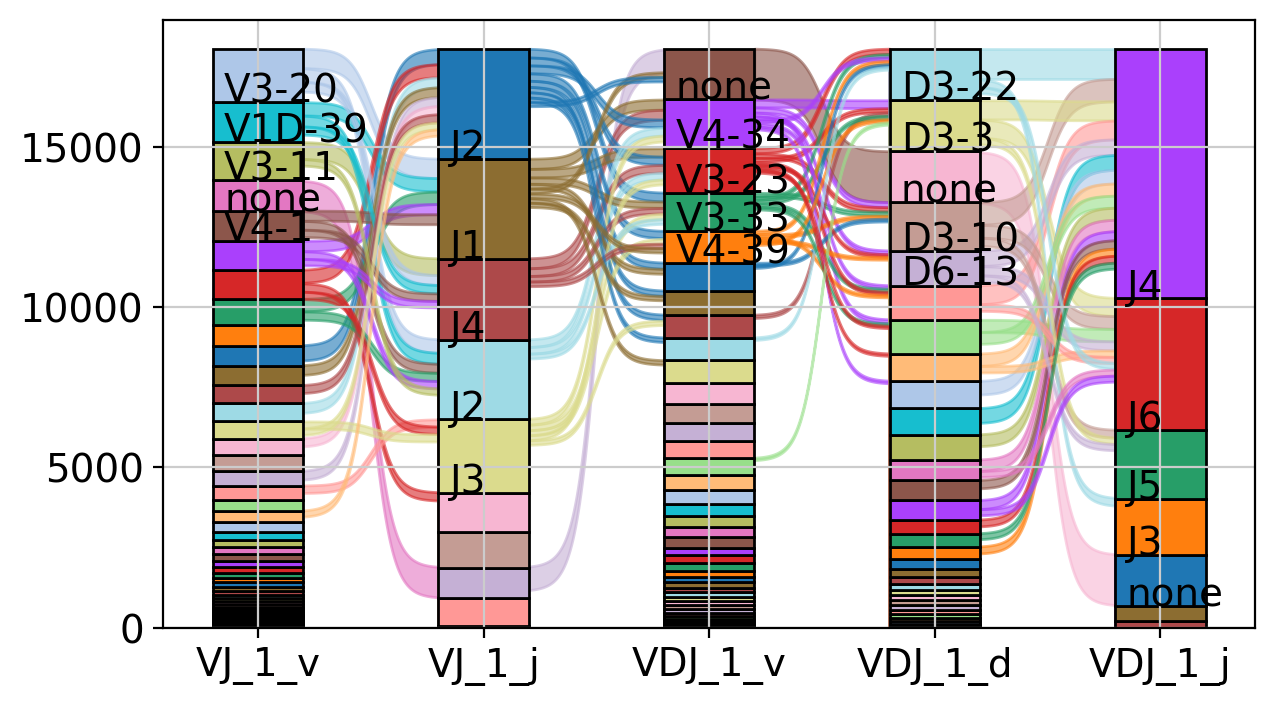

In [98]:
ir.pl.vdj_usage(adata, full_combination=False, max_segments=None, max_ribbons=30)


In [99]:
df, dst, lk = ir.tl.repertoire_overlap(adata, "sample", inplace=False)
df.head()

clonotype                                        0_BCR  1_BCR  2_BCR  3_BCR  \
sample                                                                        
35008_CV005_RV9039258_and_35008_CV005_RV9039282    1.0    1.0    1.0    1.0   
35008_CV005_RV9039259_and_35008_CV005_RV9039283    0.0    0.0    0.0    0.0   
35008_CV005_RV9039260_and_35008_CV005_RV9039284    0.0    0.0    0.0    0.0   
35008_CV005_RV9039261_and_35008_CV005_RV9039285    0.0    0.0    0.0    0.0   
35008_CV005_RV9039262_and_35008_CV005_RV9039286    0.0    0.0    0.0    0.0   

clonotype                                        4_BCR  5_BCR  6_BCR  7_BCR  \
sample                                                                        
35008_CV005_RV9039258_and_35008_CV005_RV9039282    1.0    1.0    1.0    1.0   
35008_CV005_RV9039259_and_35008_CV005_RV9039283    0.0    0.0    0.0    0.0   
35008_CV005_RV9039260_and_35008_CV005_RV9039284    0.0    0.0    0.0    0.0   
35008_CV005_RV9039261_and_35008_CV005_RV9039285    0.0    0.0    0.0    0.0   
35008_CV005_RV9039262_and_35008_CV005_RV9039286    0.0    0.0    0.0    0.0   

clonotype                                        8_BCR  9_BCR  ...  17132_BCR  \
sample                                                         ...              
35008_CV005_RV9039258_and_35008_CV005_RV9039282    1.0    1.0  ...        0.0   
35008_CV005_RV9039259_and_35008_CV005_RV9039283    0.0    0.0  ...        0.0   
35008_CV005_RV9039260_and_35008_CV005_RV9039284    0.0    0.0  ...        0.0   
35008_CV005_RV9039261_and_35008_CV005_RV9039285    0.0    0.0  ...        0.0   
35008_CV005_RV9039262_and_35008_CV005_RV9039286    0.0    0.0  ...        0.0   

clonotype                                        17133_BCR  17134_BCR  \
sample                                                                  
35008_CV005_RV9039258_and_35008_CV005_RV9039282        0.0        0.0   
35008_CV005_RV9039259_and_35008_CV005_RV9039283        0.0        0.0   
35008_CV005_RV9039260_and_35008_CV005_RV9039284        0.0        0.0   
35008_CV005_RV9039261_and_35008_CV005_RV9039285        0.0        0.0   
35008_CV005_RV9039262_and_35008_CV005_RV9039286        0.0        0.0   

clonotype                                        17135_BCR  17136_BCR  \
sample                                                                  
35008_CV005_RV9039258_and_35008_CV005_RV9039282        0.0        0.0   
35008_CV005_RV9039259_and_35008_CV005_RV9039283        0.0        0.0   
35008_CV005_RV9039260_and_35008_CV005_RV9039284        0.0        0.0   
35008_CV005_RV9039261_and_35008_CV005_RV9039285        0.0        0.0   
35008_CV005_RV9039262_and_35008_CV005_RV9039286        0.0        0.0   

clonotype                                        17137_BCR  17138_BCR  \
sample                                                                  
35008_CV005_RV9039258_and_35008_CV005_RV9039282        0.0        0.0   
35008_CV005_RV9039259_and_35008_CV005_RV9039283        0.0        0.0   
35008_CV005_RV9039260_and_35008_CV005_RV9039284        0.0        0.0   
35008_CV005_RV9039261_and_35008_CV005_RV9039285        0.0        0.0   
35008_CV005_RV9039262_and_35008_CV005_RV9039286        0.0        0.0   

clonotype                                        17139_BCR  17140_BCR  \
sample                                                                  
35008_CV005_RV9039258_and_35008_CV005_RV9039282        0.0        0.0   
35008_CV005_RV9039259_and_35008_CV005_RV9039283        0.0        0.0   
35008_CV005_RV9039260_and_35008_CV005_RV9039284        0.0        0.0   
35008_CV005_RV9039261_and_35008_CV005_RV9039285        0.0        0.0   
35008_CV005_RV9039262_and_35008_CV005_RV9039286        0.0        0.0   

clonotype                                        17141_BCR  
sample                                                      
35008_CV005_RV9039258_and_35008_CV005_RV9039282        0.0  
35008_CV005_RV9039259_and_35008_CV005_RV9039283        0.0  
35008_CV005_RV9039260_and_35008_

/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


ValueError: cannot reshape array of size 104 into shape (2,80)

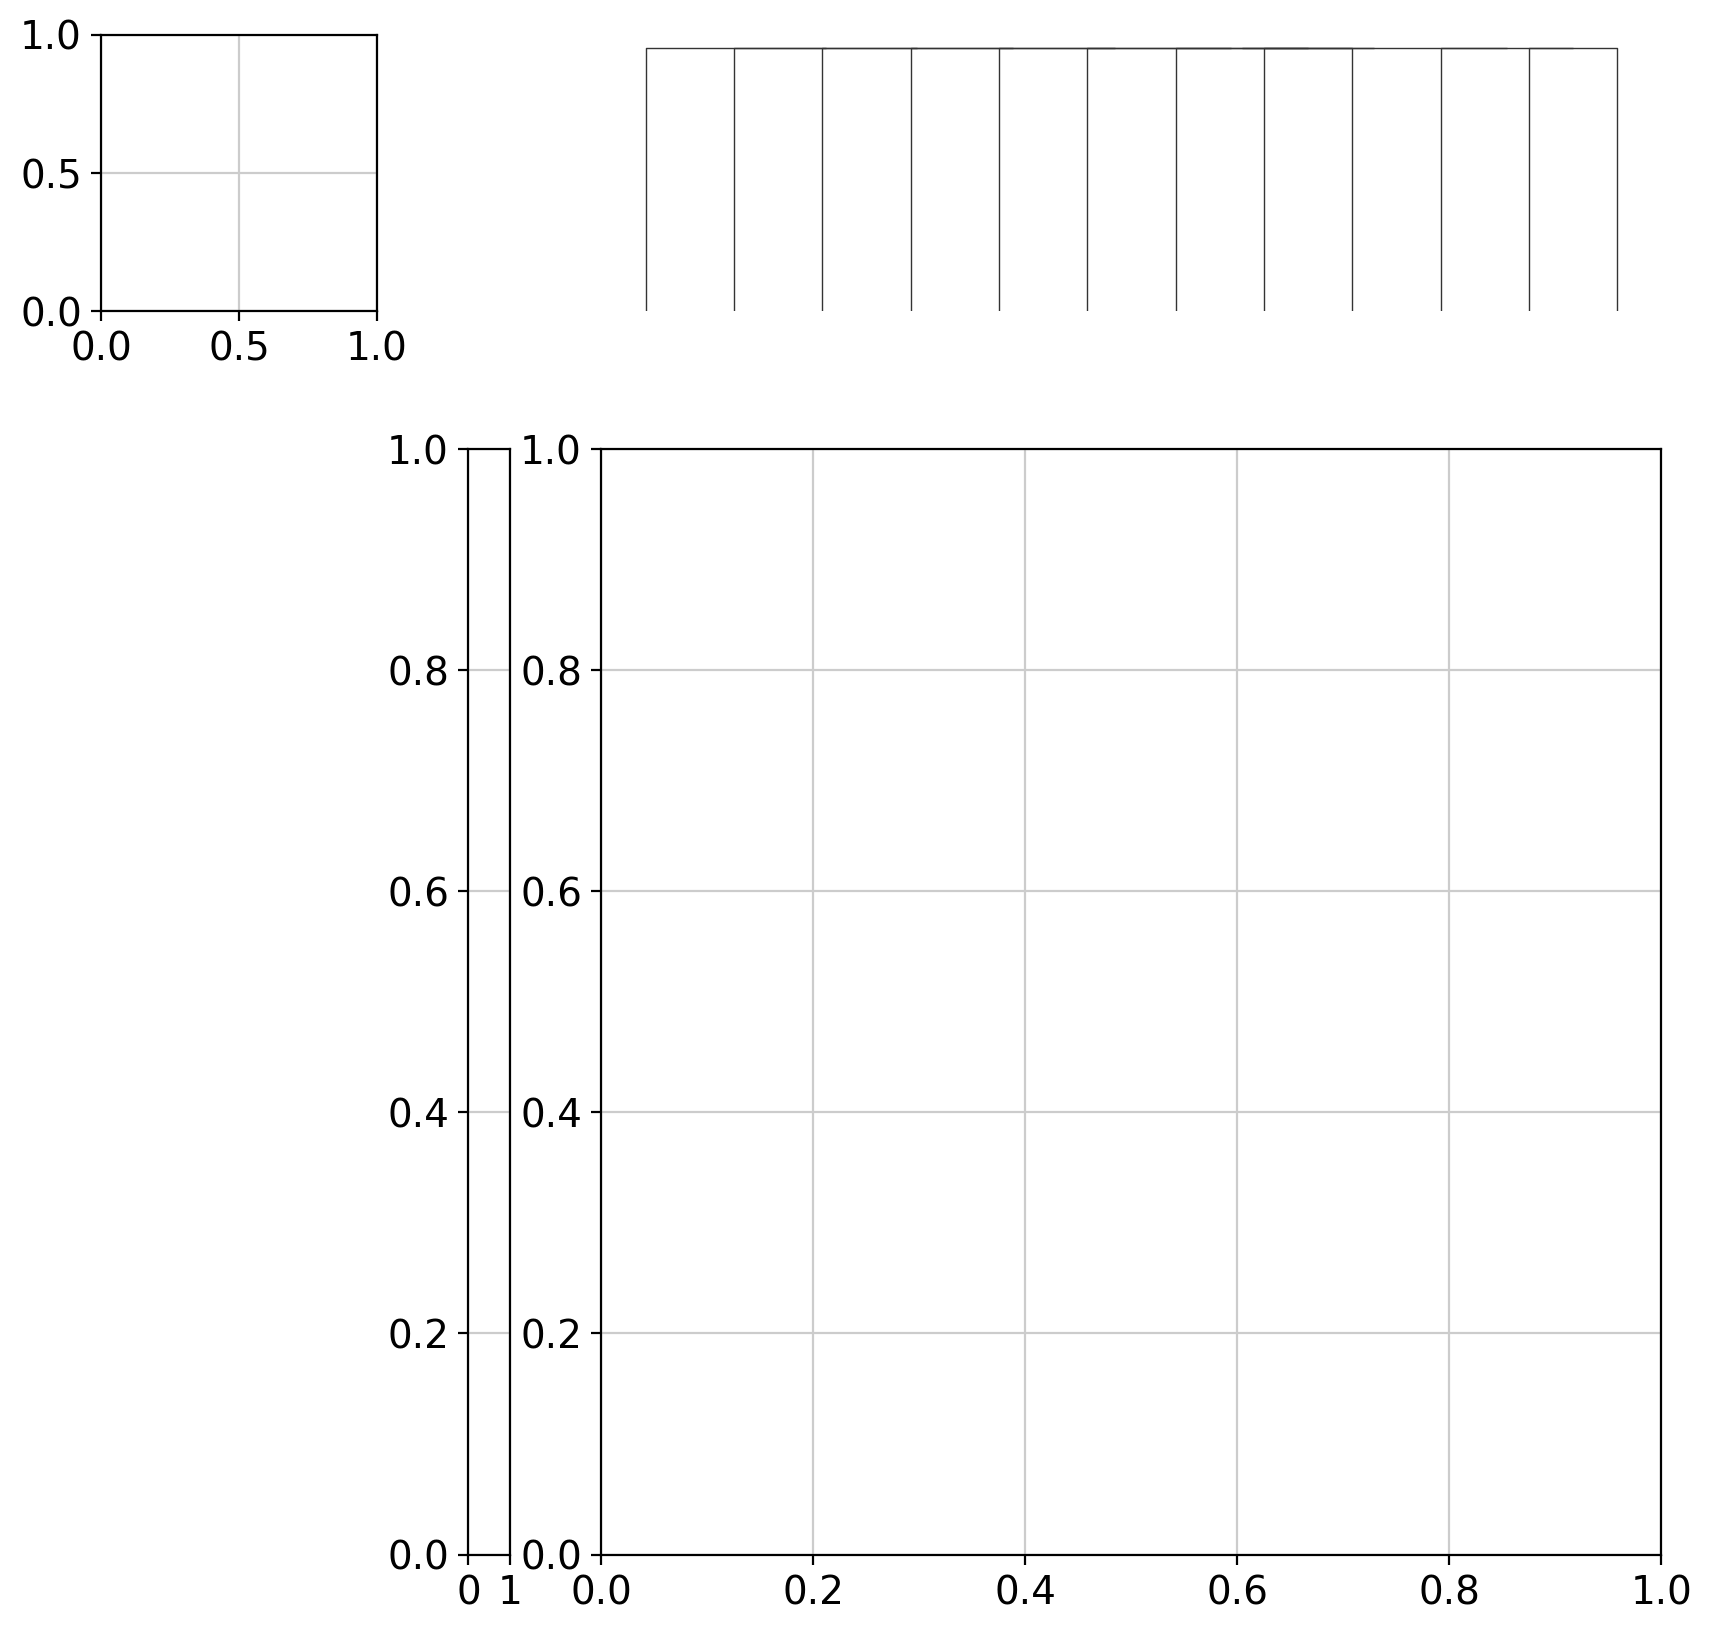

In [101]:
ir.pl.repertoire_overlap(adata, "sample", heatmap_cats=["donor", "CVID_status"])


In [103]:
freq, stat = ir.tl.clonotype_imbalance(
    adata,
    replicate_col="sample",
    groupby="CVID_status",
    case_label="CVID",
    control_label="CONTROL",
    inplace=False,
)
top_differential_clonotypes = stat["clonotype"].tolist()[:5]

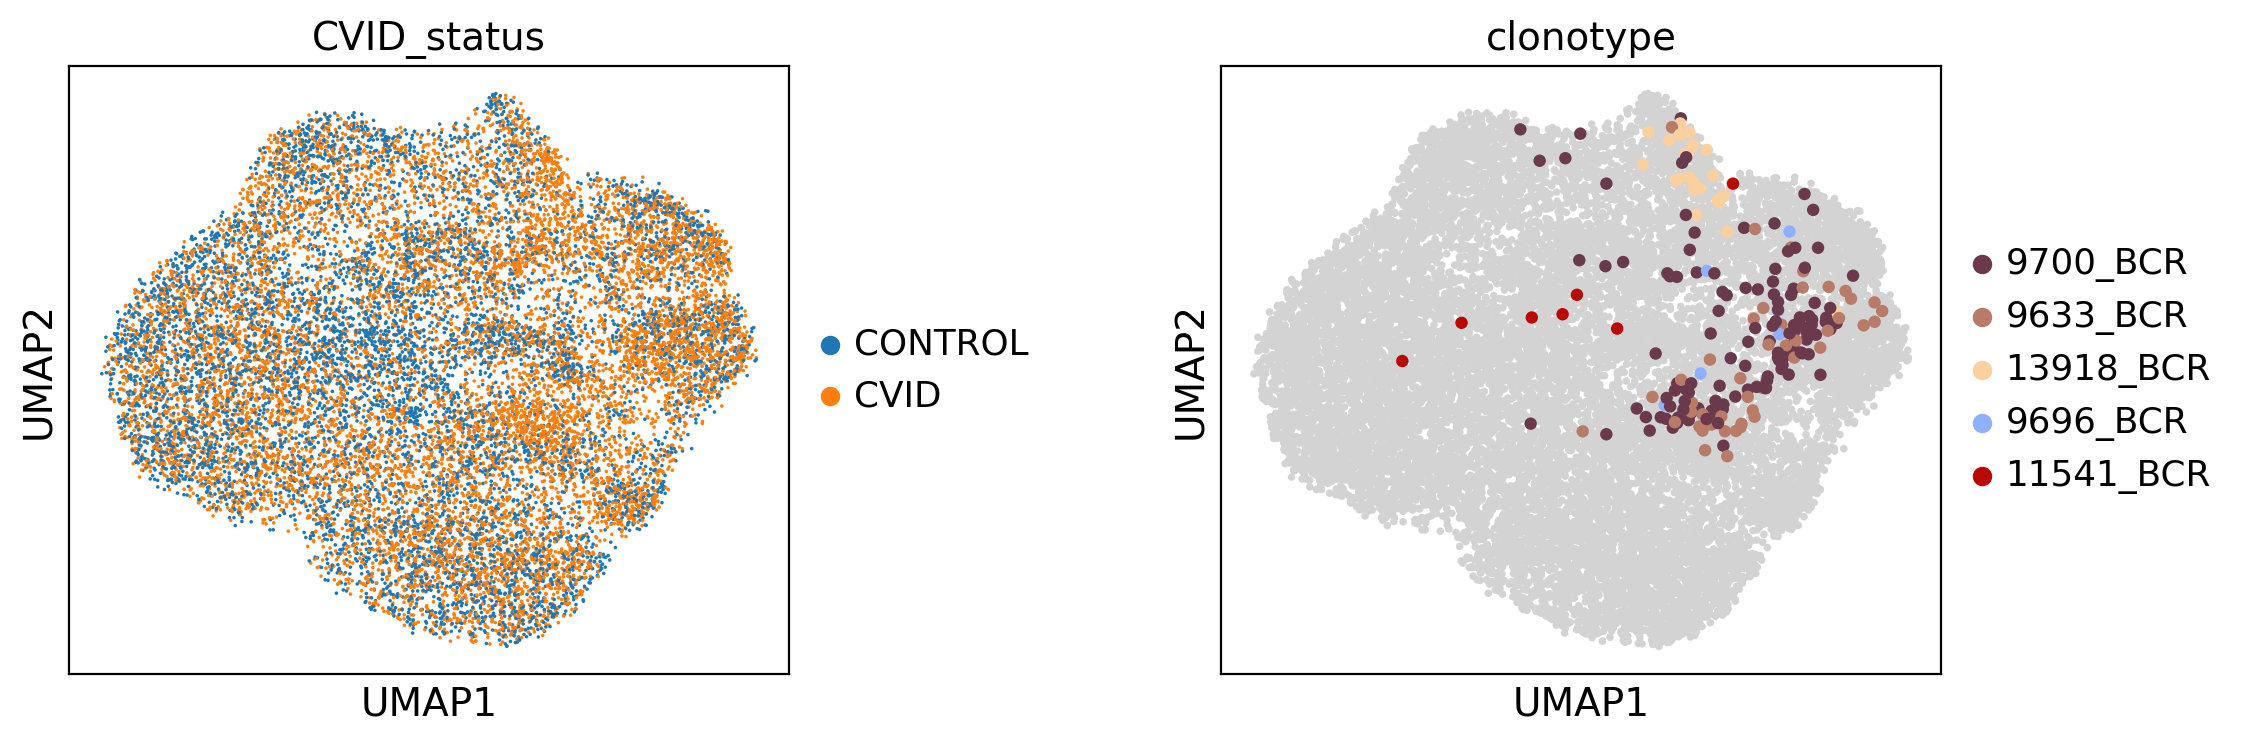

In [105]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={"wspace": 0.6})
sc.pl.umap(adata, color="CVID_status", ax=ax1, show=False)
sc.pl.umap(
    adata,
    color="clonotype",
    groups=top_differential_clonotypes,
    ax=ax2,
    # increase size of highlighted dots
    size=[
        80 if c in top_differential_clonotypes else 30 for c in adata.obs["clonotype"]
    ],
)

No handles with labels found to put in legend.


<AxesSubplot:title={'center':'Repertoire overlap between CVID and CONTROL'}, xlabel='Clonotype size in CVID', ylabel='Clonotype size in CONTROL'>

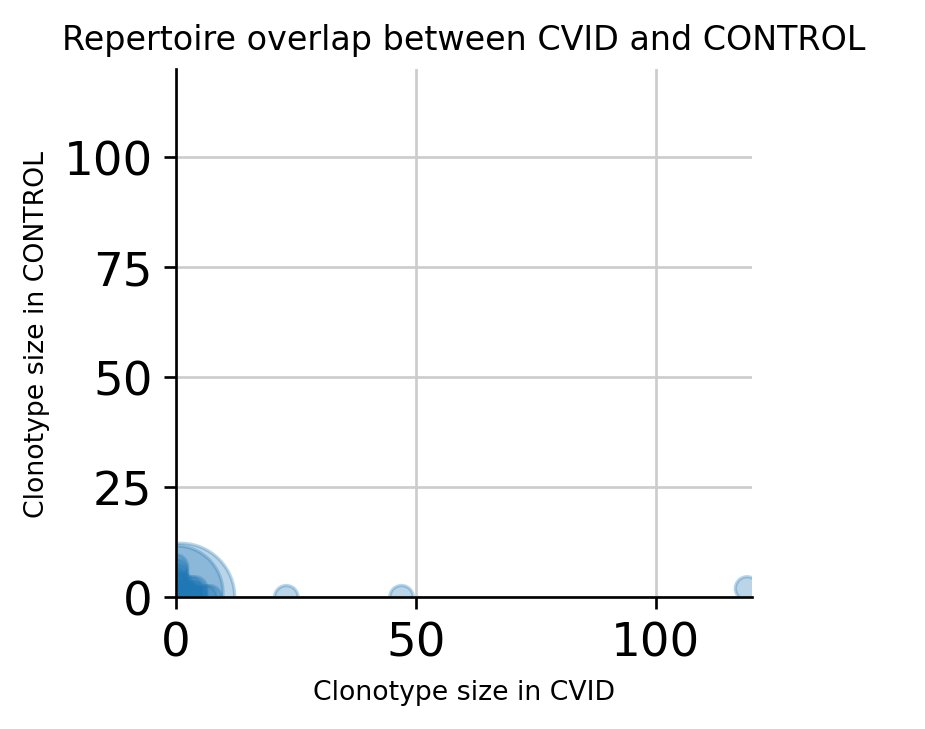

In [108]:
ir.tl.repertoire_overlap(adata, "CVID_status")
ir.pl.repertoire_overlap(
    adata, "CVID_status", pair_to_plot=["CVID", "CONTROL"], fig_kws={"dpi": 120}
)

In [112]:
# saving all calculated BCR information / metrics into a csv file
BCR_info_B_cells = pd.DataFrame(adata.obs.loc[:,['IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 
                 'IR_VJ_1_cdr3', 'IR_VJ_2_cdr3', 'IR_VDJ_1_cdr3', 'IR_VDJ_2_cdr3', 'IR_VJ_1_cdr3_nt', 
                 'IR_VJ_2_cdr3_nt', 'IR_VDJ_1_cdr3_nt', 'IR_VDJ_2_cdr3_nt', 'IR_VJ_1_expr', 
                 'IR_VJ_2_expr', 'IR_VDJ_1_expr', 'IR_VDJ_2_expr', 'IR_VJ_1_expr_raw', 
                 'IR_VJ_2_expr_raw', 'IR_VDJ_1_expr_raw', 'IR_VDJ_2_expr_raw', 'IR_VJ_1_v_gene', 
                 'IR_VJ_2_v_gene', 'IR_VDJ_1_v_gene', 'IR_VDJ_2_v_gene', 'IR_VJ_1_d_gene', 'IR_VJ_2_d_gene', 
                 'IR_VDJ_1_d_gene', 'IR_VDJ_2_d_gene', 'IR_VJ_1_j_gene', 'IR_VJ_2_j_gene', 'IR_VDJ_1_j_gene', 
                 'IR_VDJ_2_j_gene', 'IR_VJ_1_c_gene', 'IR_VJ_2_c_gene', 'IR_VDJ_1_c_gene', 'IR_VDJ_2_c_gene', 
                 'IR_VJ_1_junction_ins', 'IR_VJ_2_junction_ins', 'IR_VDJ_1_junction_ins', 'IR_VDJ_2_junction_ins', 
                 'has_ir', 'multi_chain', 'receptor_type', 'receptor_subtype', 'chain_pairing', 'clonotype', 
                 'clonotype_size', 'ct_cluster_aa_alignment', 'ct_cluster_aa_alignment_size', 
                 'ct_cluster_aa_alignment_same_v', 'ct_cluster_aa_alignment_same_v_size', 'clonal_expansion']])

BCR_info_B_cells.to_csv(save_path + '20210106_B_cells_BCR_metrics_scirpy.csv')

In [113]:
BCR_info_B_cells

IR_VJ_1_locus IR_VJ_2_locus IR_VDJ_1_locus IR_VDJ_2_locus  \
AAACCTGCAGATGGGT-1           IGL           nan            nan            nan   
AAACCTGGTAGCGATG-1           IGL           nan            IGH            nan   
AAACCTGGTTAGATGA-1           IGL           nan            IGH            nan   
AAACGGGAGGATTCGG-1           IGL           nan            IGH            nan   
AAACGGGGTGCGCTTG-1           IGL           nan            IGH            nan   
...                          ...           ...            ...            ...   
TTTGGTTAGGTAAACT-1           IGL           nan            IGH            nan   
TTTGGTTTCTACCTGC-1           IGK           nan            IGH            nan   
TTTGTCAAGAAACCTA-1           IGL           IGK            IGH            nan   
TTTGTCACACAGCGTC-1           IGL           nan            IGH            nan   
TTTGTCAGTAGTACCT-1           IGK           nan            IGH            nan   

                      IR_VJ_1_cdr3 IR_VJ_2_cdr3            IR_VDJ_1_cdr3  \
AAACCTGCAGATGGGT-1   CQSADSSGTYRSF         None                     None   
AAACCTGGTAGCGATG-1   CYSTDSSGNQGVF         None            CAKLAVAGDFDYW   
AAACCTGGTTAGATGA-1    CSSYTSSSTWVF         None           CARVYRGALWFDPW   
AAACGGGAGGATTCGG-1    CSSYTSSSAWVF         None         CARRGVEGYYYYMDVW   
AAACGGGGTGCGCTTG-1  CQSYDSSLSGSVVF         None      CARVGDSSGYYSPDAFDIW   
...                            ...          ...                      ...   
TTTGGTTAGGTAAACT-1     CQAWDSSTVVF         None  CARDLSDYDFWSGPRGYYGMDVW   
TTTGGTTTCTACCTGC-1      CQQSYSTPTF         None          CARVDTAMVPYFDYW   
TTTGTCAAGAAACCTA-1   CSSYTSSSTLEVF  CQQRSDWPLTF             CARRKGGRVDYW   
TTTGTCACACAGCGTC-1   CGTWDSSLSAGVF         None           CASSGYYYRFFDYW   
TTTGTCAGTAGTACCT-1     CQQYGSSRGTF         None     CARTLPTVTTLHYYYYMDVW   

                   IR_VDJ_2_cdr3                             IR_VJ_1_cdr3_nt  \
AAACCTGCAGATGGGT-1          None     TGTCAATCAGCAGACAGCAGTGGTACTTATCGGAGCTTC   
AAACCTGGTAGCGATG-1          None     TGTTACTCAACAGACAGCAGTGGTAATCAGGGGGTATTC   
AAACCTGGTTAGATGA-1          None        TGCAGCTCATATACAAGCAGCAGCACTTGGGTGTTC   
AAACGGGAGGATTCGG-1          None        TGCAGCTCATATACAAGCAGCAGCGCTTGGGTGTTC   
AAACGGGGTGCGCTTG-1          None  TGCCAGTCCTATGACAGCAGCCTGAGTGGTTCTGTGGTATTC   
...                          ...                                         ...   
TTTGGTTAGGTAAACT-1          None           TGTCAGGCGTGGGACAGCAGCACTGTGGTATTC   
TTTGGTTTCTACCTGC-1          None              TGTCAACAGAGTTACAGTACCCCTACTTTT   
TTTGTCAAGAAACCTA-1          None     TGCAGCTCATATACAAGCAGCAGCACTCTCGAGGTCTTC   
TTTGTCACACAGCGTC-1          None     TGCGGAACATGGGATAGCAGCCTGAGTGCTGGGGTATTC   
TTTGTCAGTAGTACCT-1          None           TGTCAGCAGTATGGTAGCTCACGGGGGACTTTC   

                                      IR_VJ_2_cdr3_nt  ... receptor_type  \
AAACCTGCAGATGGGT-1                               None  ...           BCR   
AAACCTGGTAGCGATG-1                               None  ...           BCR   
AAACCTGGTTAGATGA-1                               None  ...           BCR   
AAACGGGAGGATTCGG-1                               None  ...           BCR   
AAACGGGGTGCGCTTG-1                               None  ...           BCR   
...                                               ...  ...           ...   
TTTGGTTAGGTAAACT-1                               None  ...           BCR   
TTTGGTTTCTACCTGC-1                               None  ...           BCR   
TTTGTCAAGAAACCTA-1  TGTCAGCAGCGTAGCGACTGGCCGCTCACTTTC  ...           BCR   
TTTGTCACACAGCGTC-1                               None  ...           BCR   
TTTGTCAGTAGTACCT-1                               None  ...           BCR   

                   receptor_subtype  chain_pairing  clonotype  clonotype_size  \
AAACCTGCAGATGGGT-1          IGH+IGL      orphan VJ      0_BCR               1   
AAACCTGGTAGCGATG-1          IGH+IGL    single pair      1_BCR               1   
AAACCTGGTTAGATGA-1          